# LAB 2.2 - CNS (Hopfield model)

Import of libraries and fix of random seed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

seed = 0
random.seed(seed)
np.random.seed(seed)

Loading of dataset.

In [2]:
def load_p_data(filename: str, dir: str = 'lab2_2_data') -> np.array:
    """
    Function able to load the dataset of filename variable.

    filename: Name of file where is the dataset.
    dir: Directory of dataset.

    returns:
        np.array: data loaded from the file.
    """
    with open(f'{dir}/{filename}.csv') as file:
        return np.array(file.read().split('\n')[:-1]).astype(np.int32)


p0 = load_p_data('p0')
p1 = load_p_data('p1')
p2 = load_p_data('p2')

Function able to show an image from its vector version.

In [3]:
def show_img(p: np.array, ax=plt) -> None:
    """
    Function able to show the image related to the p vector.

    p: Vector related to the image to plot.
    """
    ax.imshow(p.reshape(32, 32).T, cmap='gray', vmin=-1, vmax=1)

Image of 0 digit (p0 vector).

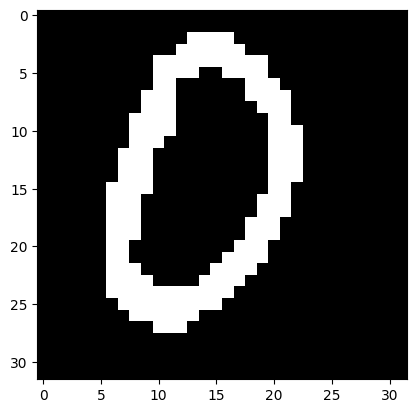

In [4]:
show_img(p0)

Image of 1 digit (p1 vector).

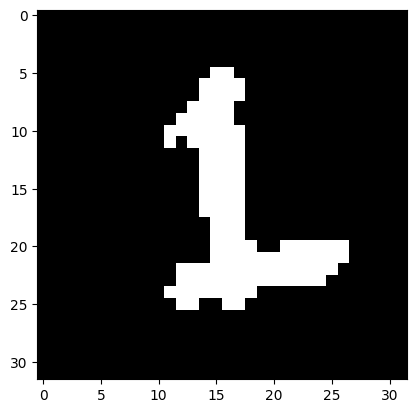

In [5]:
show_img(p1)

Image of 2 digit (p2 vector).

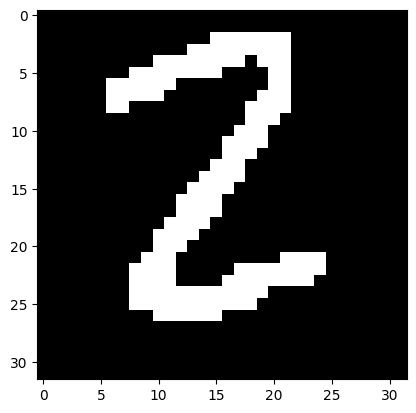

In [6]:
show_img(p2)

Function able to swap the sign of some values inside a vector given the proportion `prop` that lives between 0 and 1.

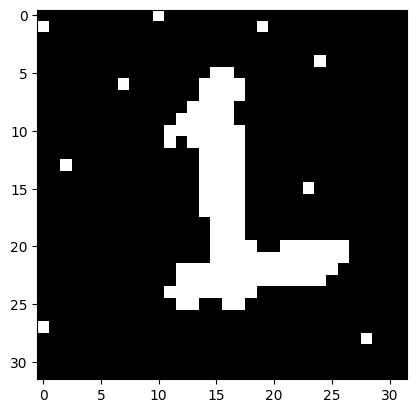

In [7]:
def distort_image(orig_img: np.array, prop: float = 0.05) -> np.array:
    """
    Function able to swap some sign of a vector in proportion to the value of prop.

    orig_img: image to distort.
    prop: Proportion of values to swap.

    returns:
        np.array: Distort version of vector.
    """
    img = orig_img.copy()
    if prop < 0 or prop > 1:
        print('Out-of-bound proportion: going to default 0.05')
        prop = 0.05
    indx = np.random.permutation(len(img))
    todist = indx[1:int(len(indx) * prop)]
    img[todist] = -img[todist]
    return img


show_img(distort_image(p1, prop=0.01))

## Model

Definition of a class for the Hopfield network model.

In [8]:
class HopfieldNetwork:
    """Class of Hopfield network model."""

    def __init__(self, patterns: np.array, bias: float = 0) -> None:
        """
        Constructor of Hopfield network model class.

        patterns: Training patterns used to initialize W matrix of weights.
        bias: Bias value of network.
        """
        self.M, self.N = patterns.shape
        self.patterns = patterns
        self.bias = bias
        self.W = self.store()

    def store(self) -> np.array:
        """
        Store function used to compute weights of network. (Hebbian learning)

        returns:
            np.array: Computed weights.
        """
        return (self.patterns.T @ self.patterns - self.M * np.eye(self.N)) / self.N

    def overlap(self, state: np.array) -> list[float]:
        """
        Overlap function that computes the similarity between patterns and a given state.

        state: State compared with patterns.

        returns:
            list[float]: Similarity of the state with all the patterns. Each value lives between -1 and +1.
        """
        return [(pattern @ state / self.N) for pattern in self.patterns]

    def energy(self, state: np.array) -> float:
        """
        Energy function of Hopfield model.

        state: State used to compute the energy.

        returns:
            float: Value of the energy.
        """
        return - state.T @ self.W @ state / 2

    def retrieval(self, state: np.array) -> list[np.array]:
        """
        Retrieval function able to run the algorithm to reconstruct a distorted vector.

        state: Distorted state to reconstruct.

        returns:
            list[np.array]: History of reconstruction of state. This contains all the intermediate states from the distorted to the reconstructed one.
        """
        states = [state.copy()]
        X, X_old = state.copy(), None
        while X_old is None or not np.array_equal(X_old, X):
            X_old = X.copy()
            perms = np.random.permutation(range(self.N))
            for j in perms:
                X[j] = np.sign(self.W[j] @ X + self.bias)
                states.append(X.copy())
        return states

Definition of discrepancy function.

In [9]:
def discrepancy(X1: np.array, X2: np.array) -> float:
    """
    Discrepancy function based on Hamming distance normalized with respect the length of the vector (so this is represented in percentage).

    X1: State one.
    X2: State two.

    returns:
        float: Hamming distance scaled. This value lives between 0 and 1. When is 0 X1 and X2 are the same.
    """
    return ((X1 - X2) != 0).sum() / X1.shape[0]

Function able to perform the retrieval phase of an Hopfield network model for each of hist pattern and some proportion of distortions.

In [10]:
def perform_retrieval(model: HopfieldNetwork, props: list[float]) -> tuple[float, dict]:
    """
    Function able to perform the retrieval part of an Hopfield model for some patterns and prop and give the mean of discrepancy.

    model: Hopfield network model.
    props: Proportion of distortion applied to each pattern to create the initial distorted state.

    returns:
        tuple[float, dict]: Tuple containing the mean of discrepancies computed for each pattern and props and the history of each state list connected to related pattern and prop.
    """
    history = []
    tot_discrepancy = 0
    for pattern_index, pattern in enumerate(model.patterns):
        for prop in props:
            # initialization
            X = distort_image(pattern, prop=prop)
            # iteration until convergence
            states = model.retrieval(X)
            # get last state that is the reconstruction of X
            X_rec = states[-1]
            # add the current discrepancy between X and X_rec
            tot_discrepancy += discrepancy(X, X_rec)
            # storing result in the history
            history.append((pattern_index, prop, states))
    mean_discrepancy = tot_discrepancy / (len(model.patterns) * len(props))
    return mean_discrepancy, history

Model selection function used to find the best bias that minimize the mean of discrepancies given the model patterns and some proportion of distortion.

In [11]:
def find_best_bias(patterns: np.array, props: list[float], attempts: int = 5) -> float:
    """
    Model selection function used to find the best bias that minimize the mean of discrepancies given patterns and props.

    patterns: Patterns to initialize the model and compute weights and used also in the retrieval phase.
    props: Proportion of distortion passed to the perform_retrieval function.
    attempts: Number of attempts of random bias initialization.

    returns:
        float: Best bias (the one that minimize the mean discrepancy).
    """
    best_bias, minimum_discrepancy = None, None
    for _ in tqdm(range(attempts)):
        # initialize bias
        bias = np.random.rand() * 2 - 1
        # initialize the model. In this phase is called also the storage function to initialize the weights.
        model = HopfieldNetwork(patterns, bias)
        # performing of retrieval phase on each pattern and props and getting of mean discrepancy
        mean_discrepancy, _ = perform_retrieval(model, props)
        if minimum_discrepancy is None or mean_discrepancy < minimum_discrepancy:
            minimum_discrepancy = mean_discrepancy
            best_bias = bias
    return best_bias

Definition of our patterns and props.

In [12]:
patterns = np.array([p.copy() for p in [p0, p1, p2]])

props: list[float] = [0.05, 0.1, 0.25]

Model selection to find the best bias

In [13]:
bias = find_best_bias(patterns, props, attempts=100)
model = HopfieldNetwork(patterns, bias)
mean_discrepancy, history = perform_retrieval(model, props)

  0%|          | 0/100 [00:00<?, ?it/s]

Plot of analysis results. For each pattern and proportion of distortion are plot energy function, overlap function and image reconstruction.

Pattern 0 - Proportion of distortion: 0.05


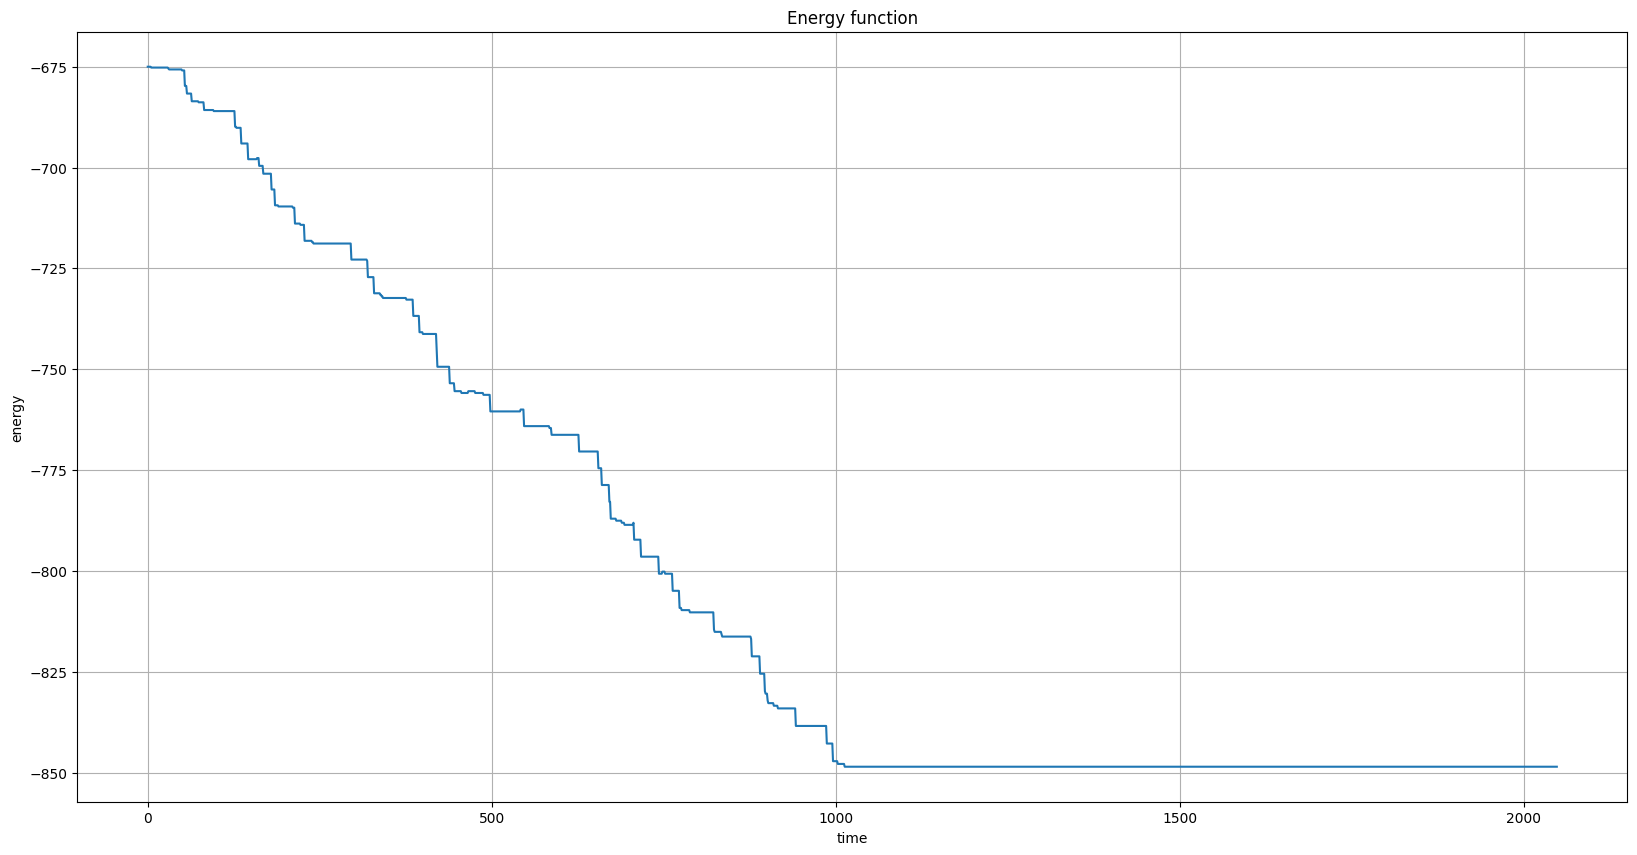

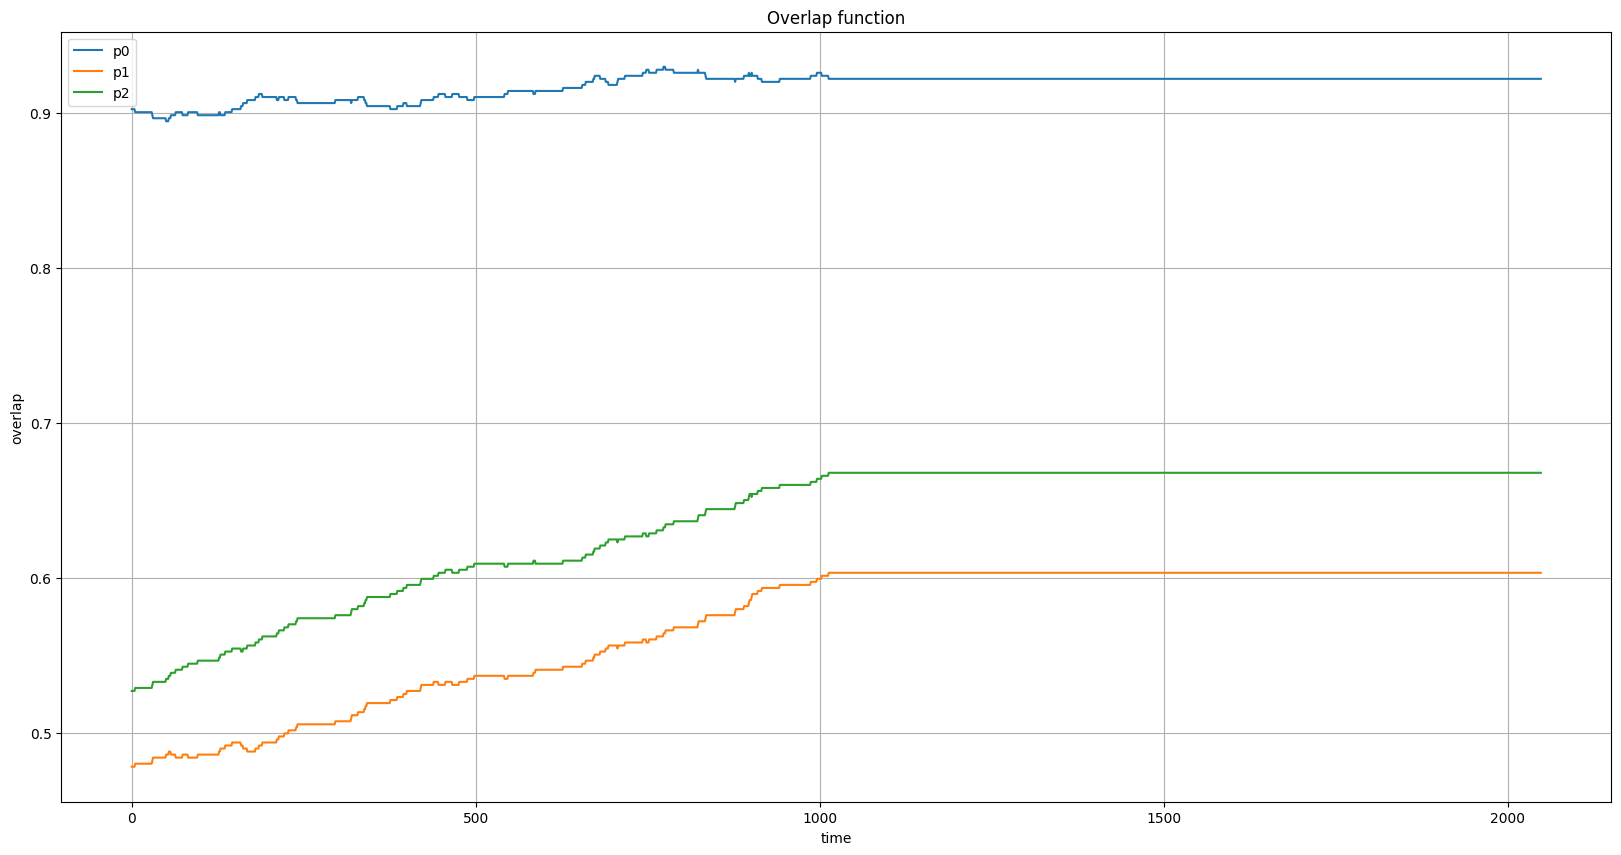

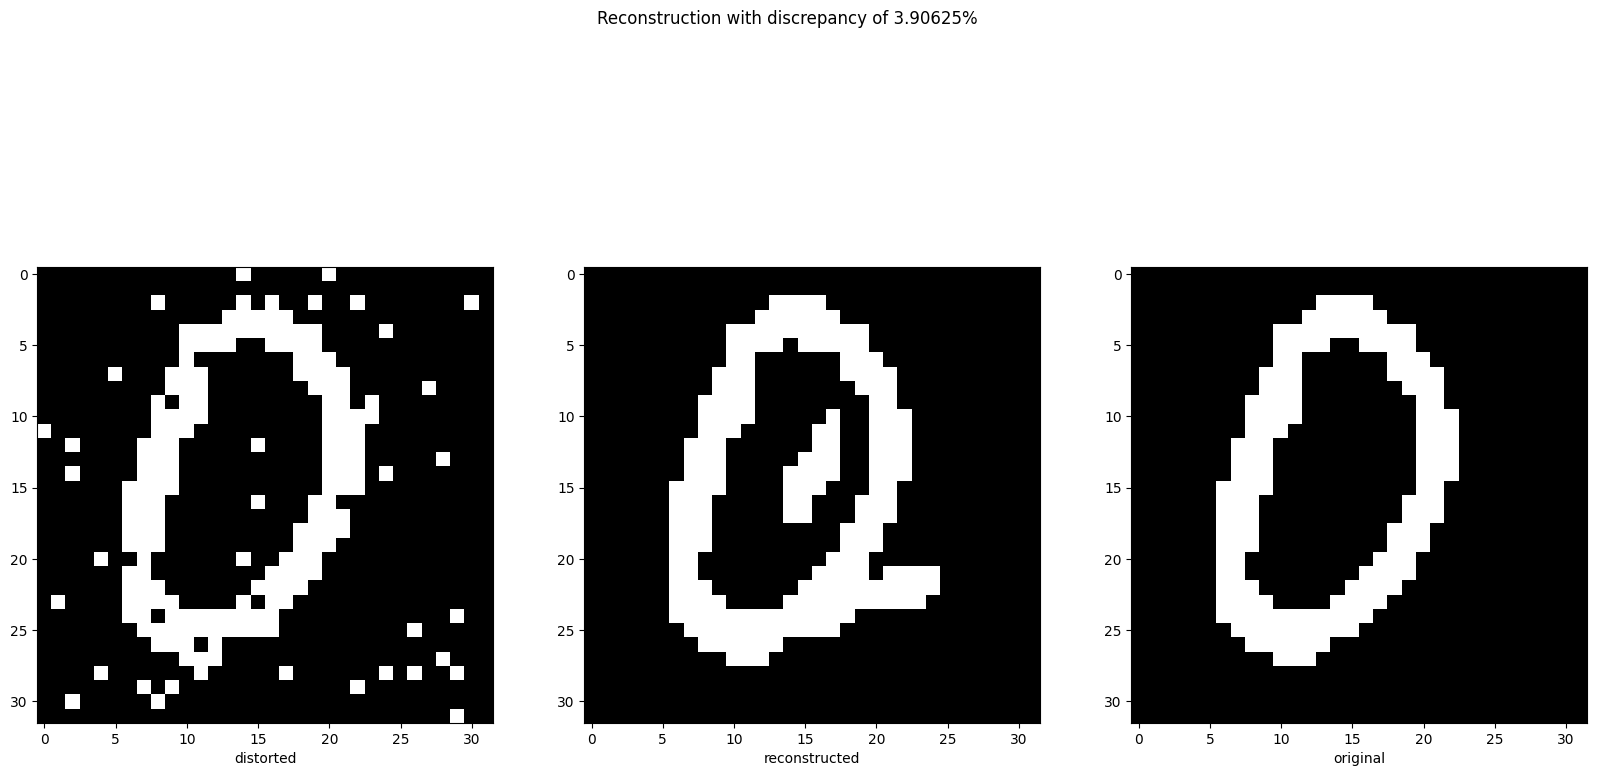

Pattern 0 - Proportion of distortion: 0.1


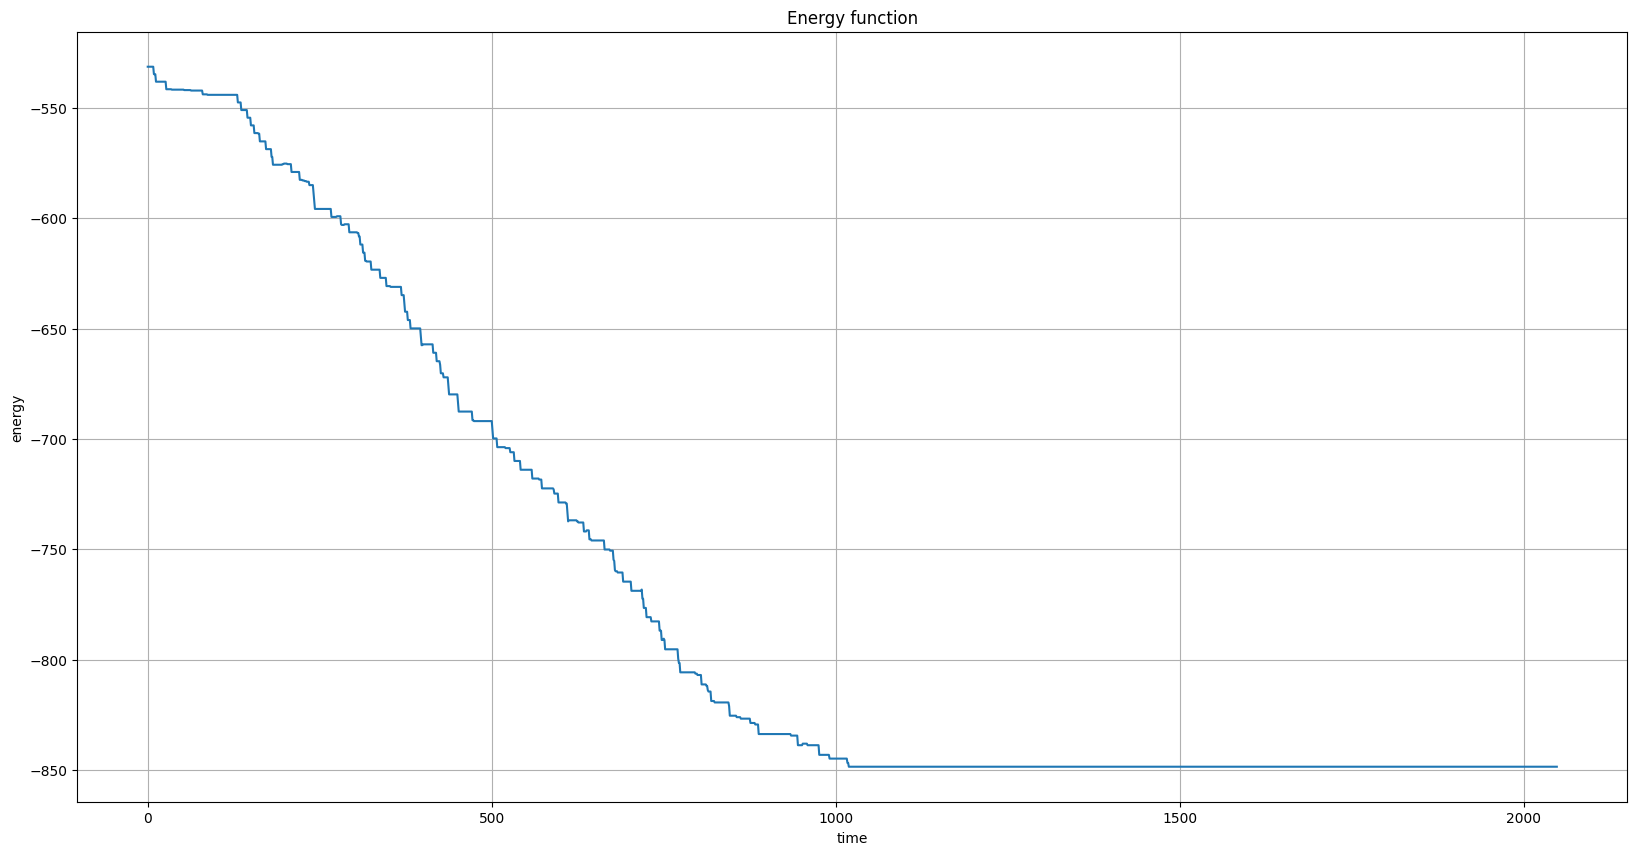

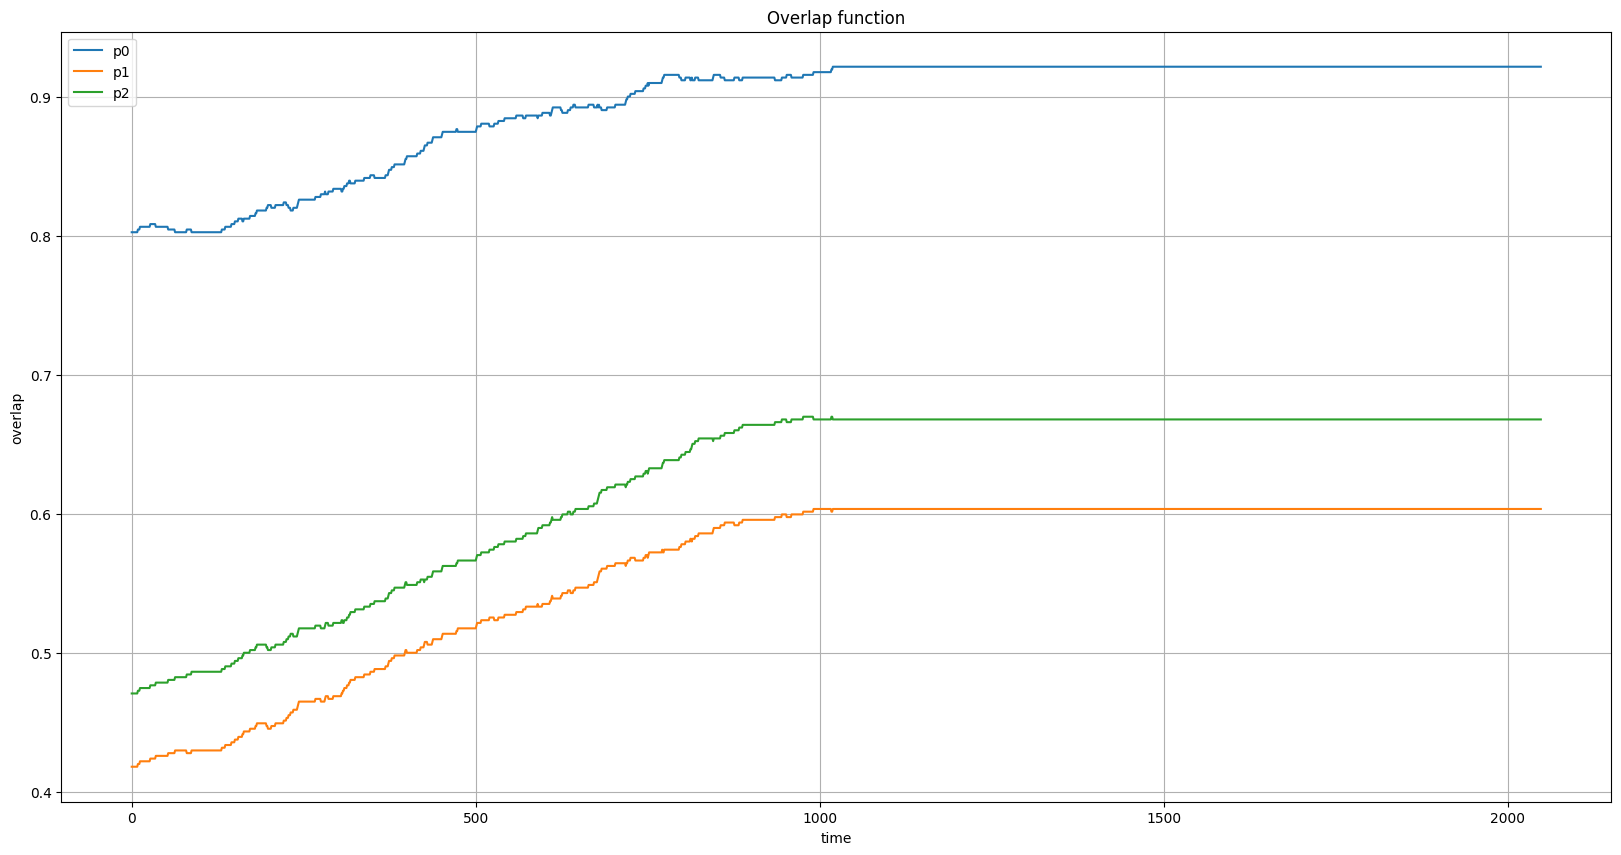

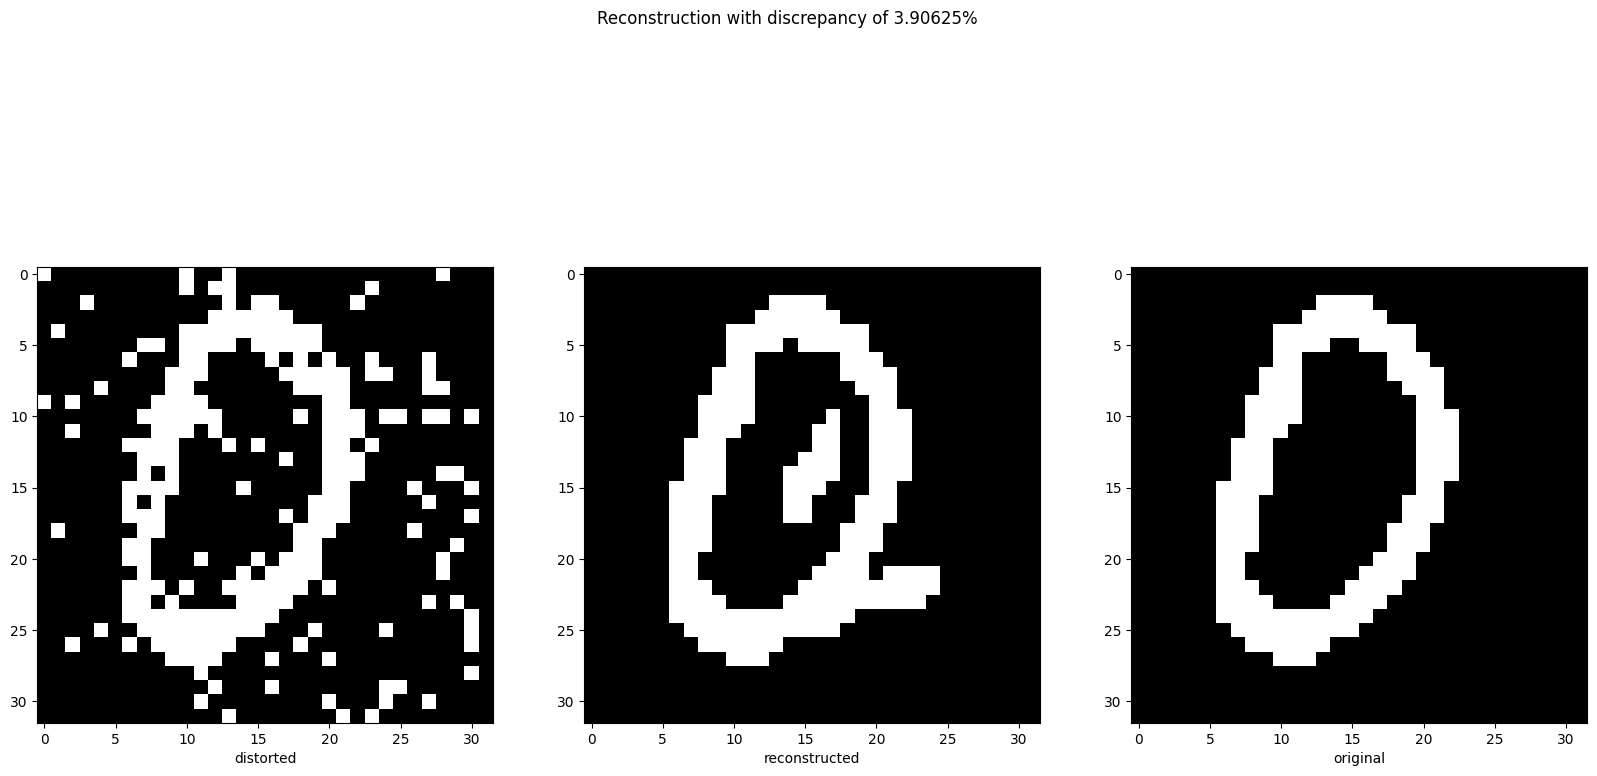

Pattern 0 - Proportion of distortion: 0.25


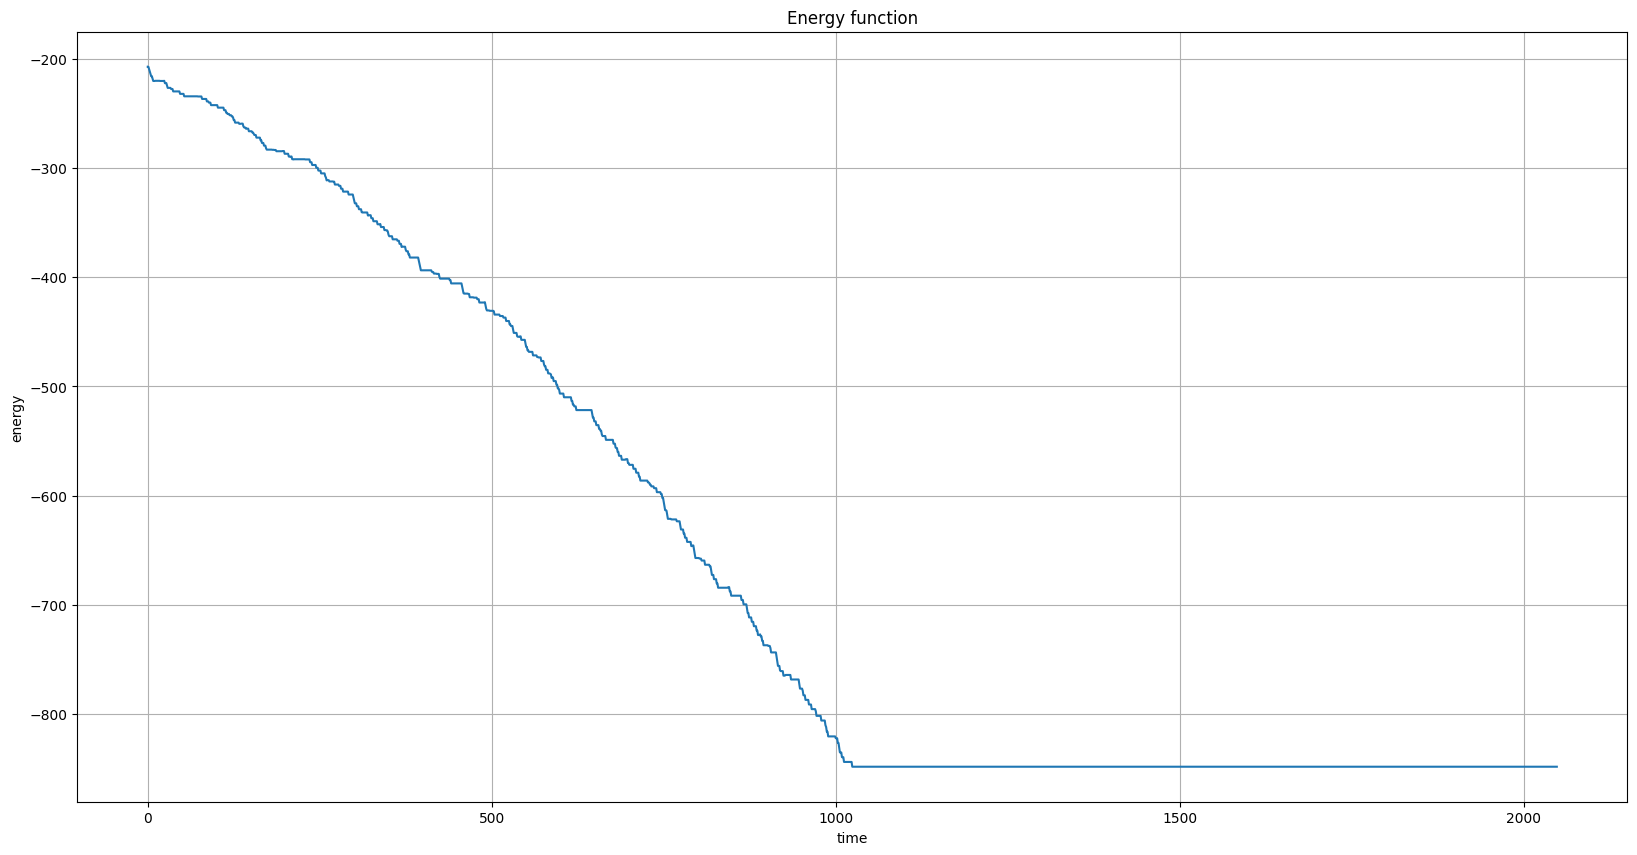

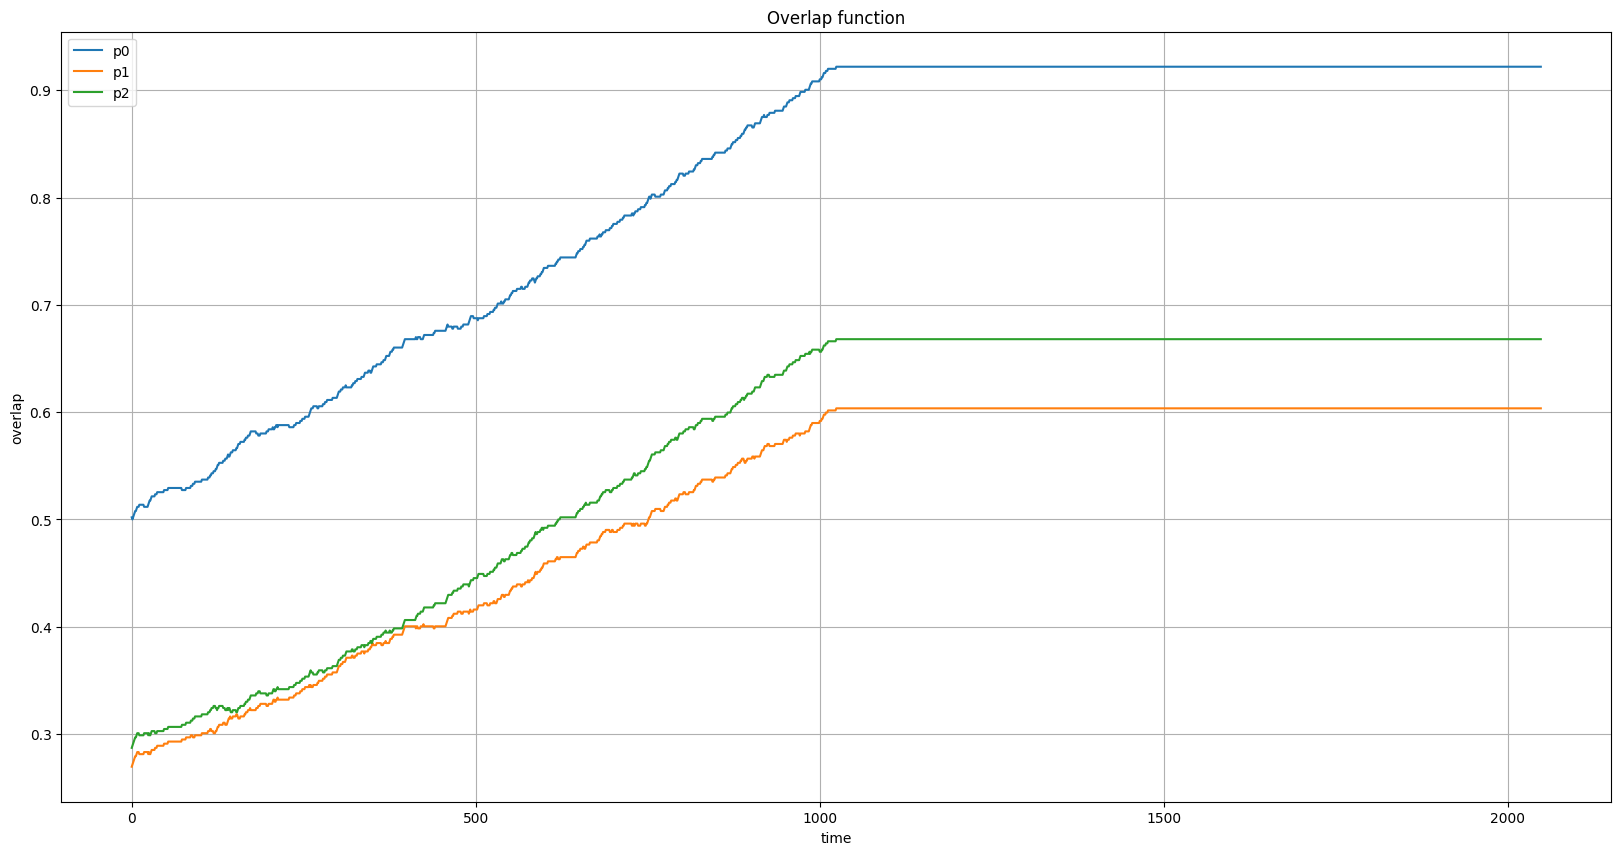

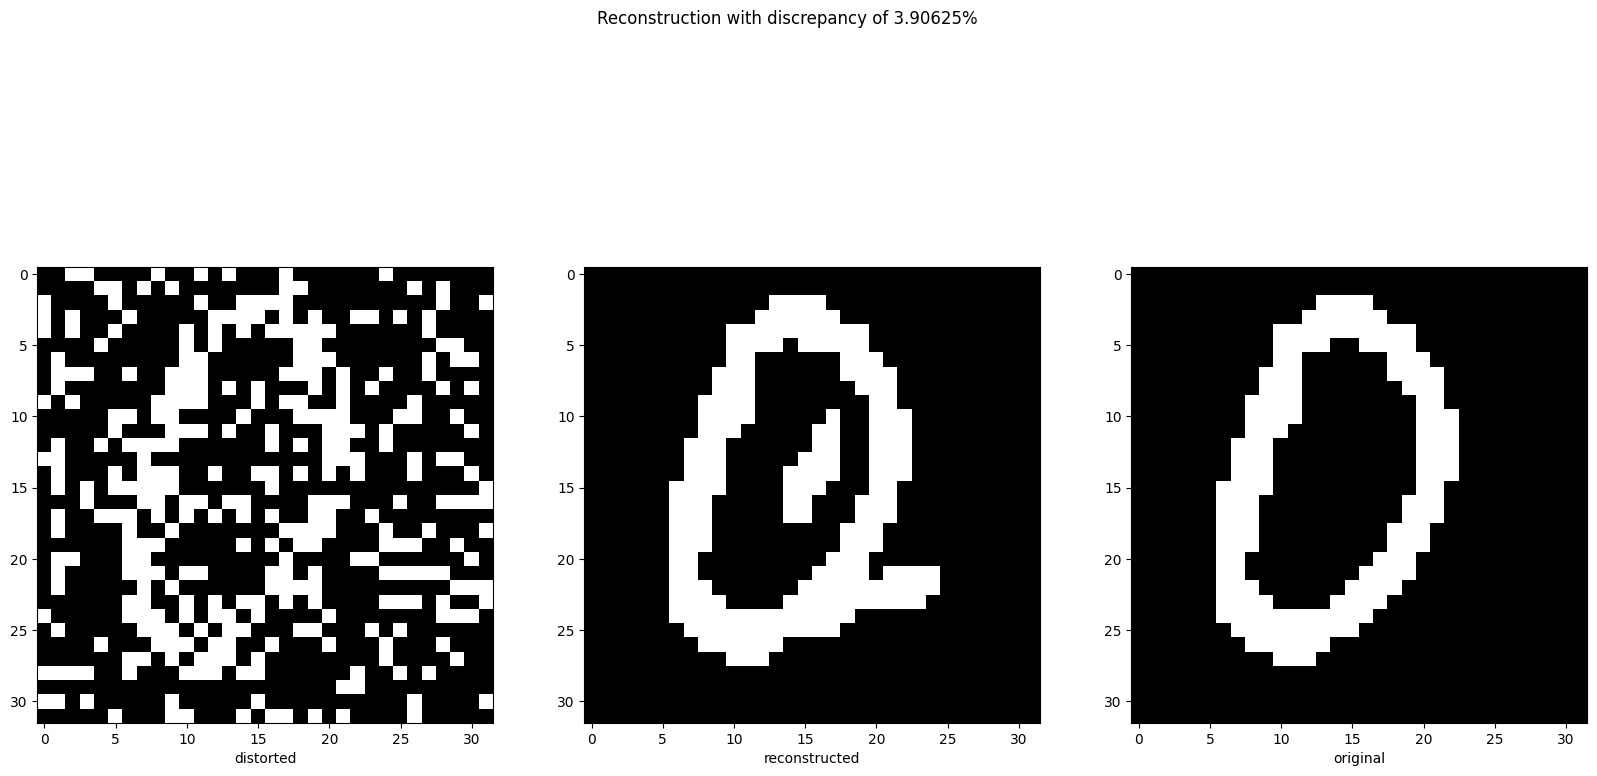

Pattern 1 - Proportion of distortion: 0.05


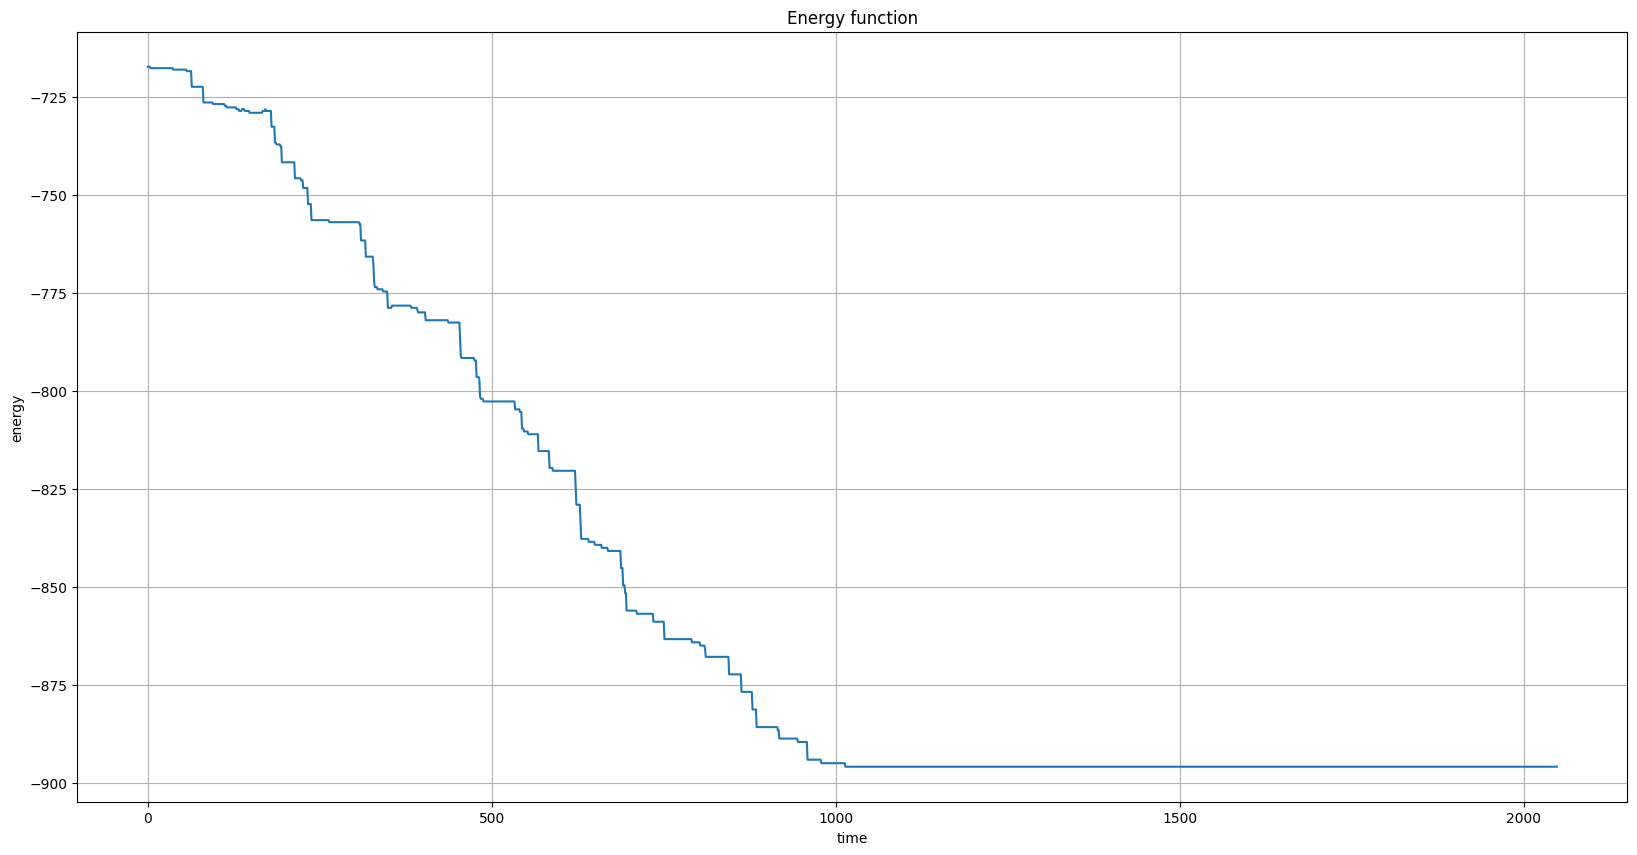

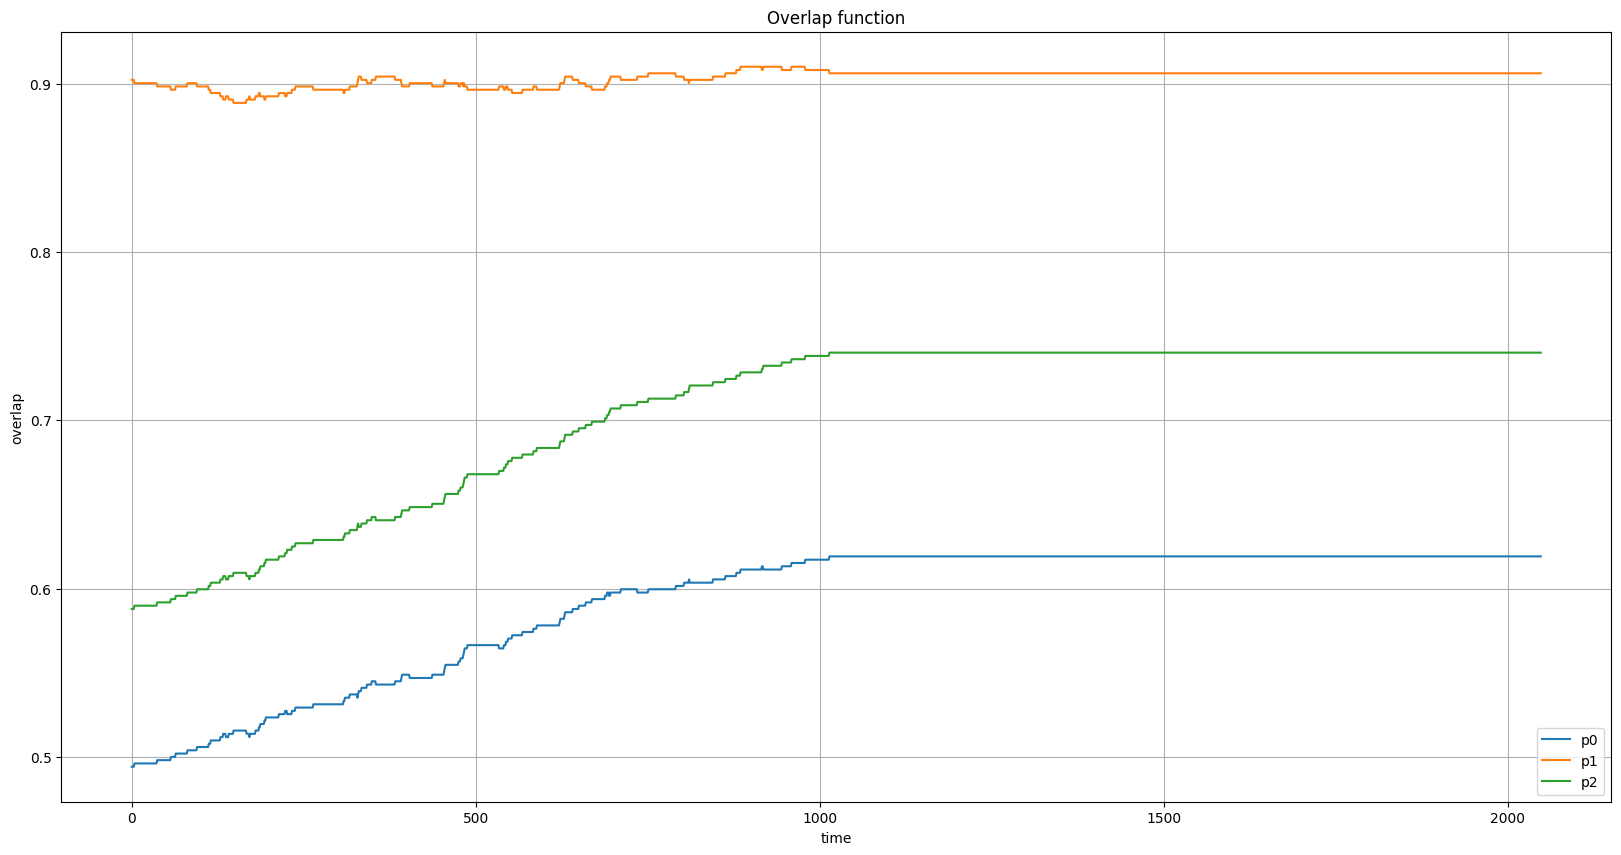

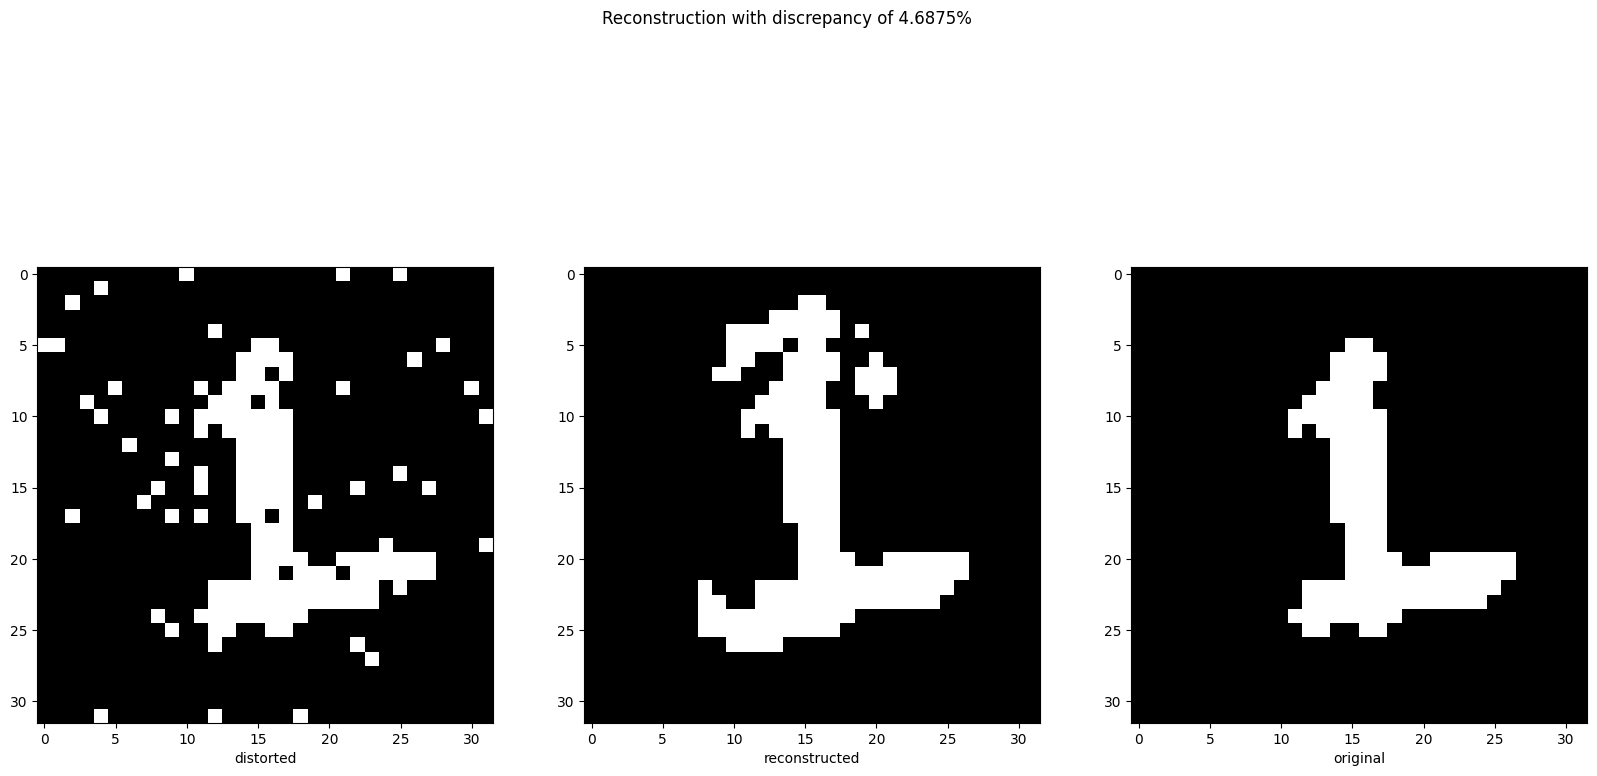

Pattern 1 - Proportion of distortion: 0.1


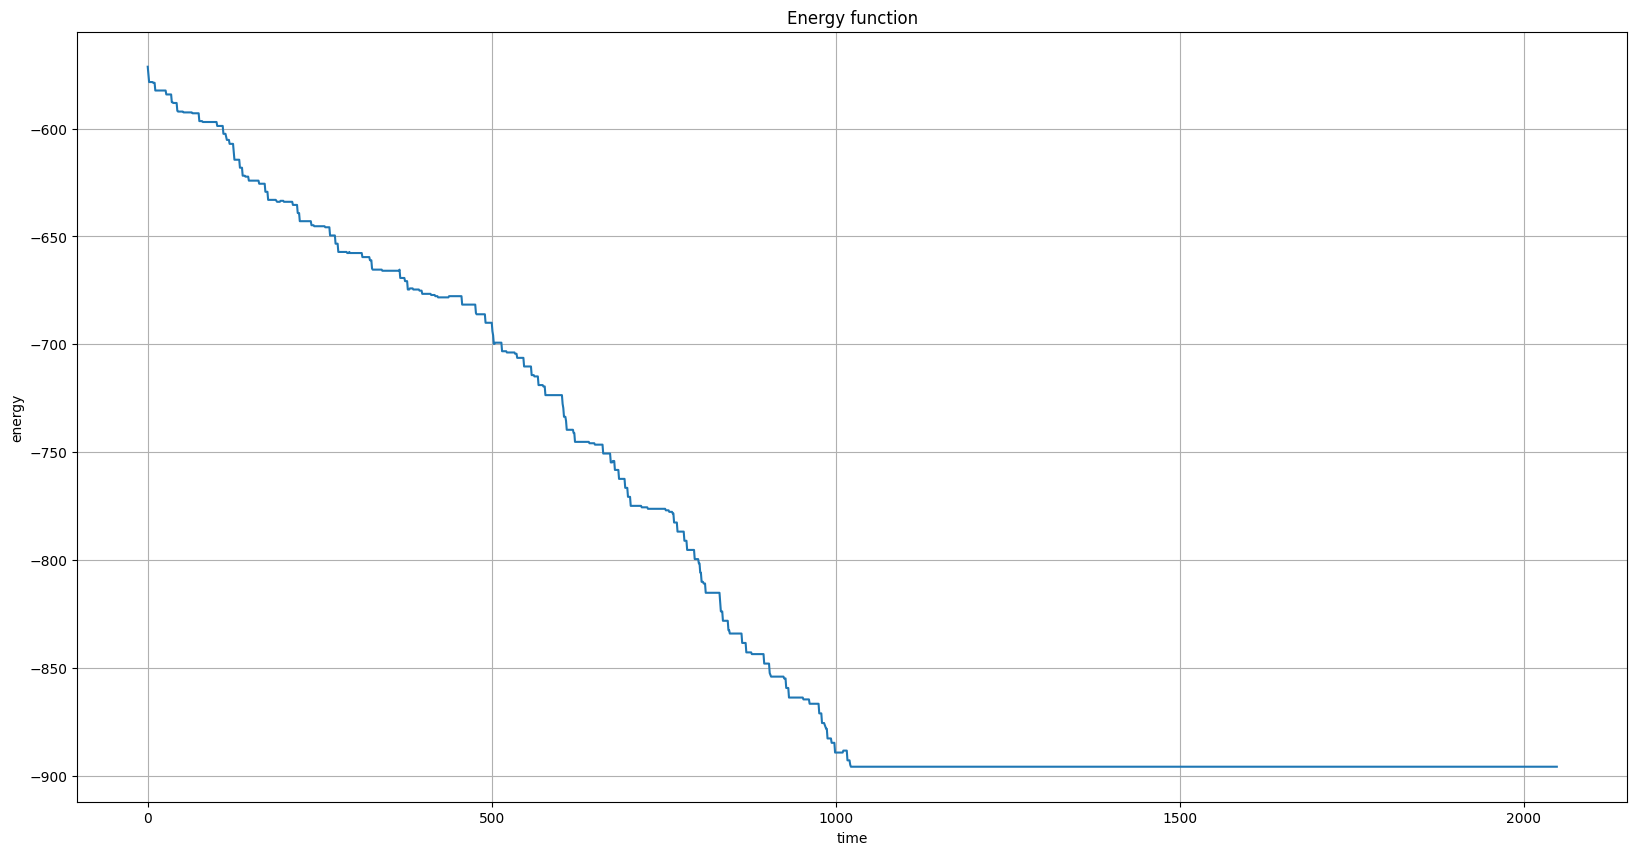

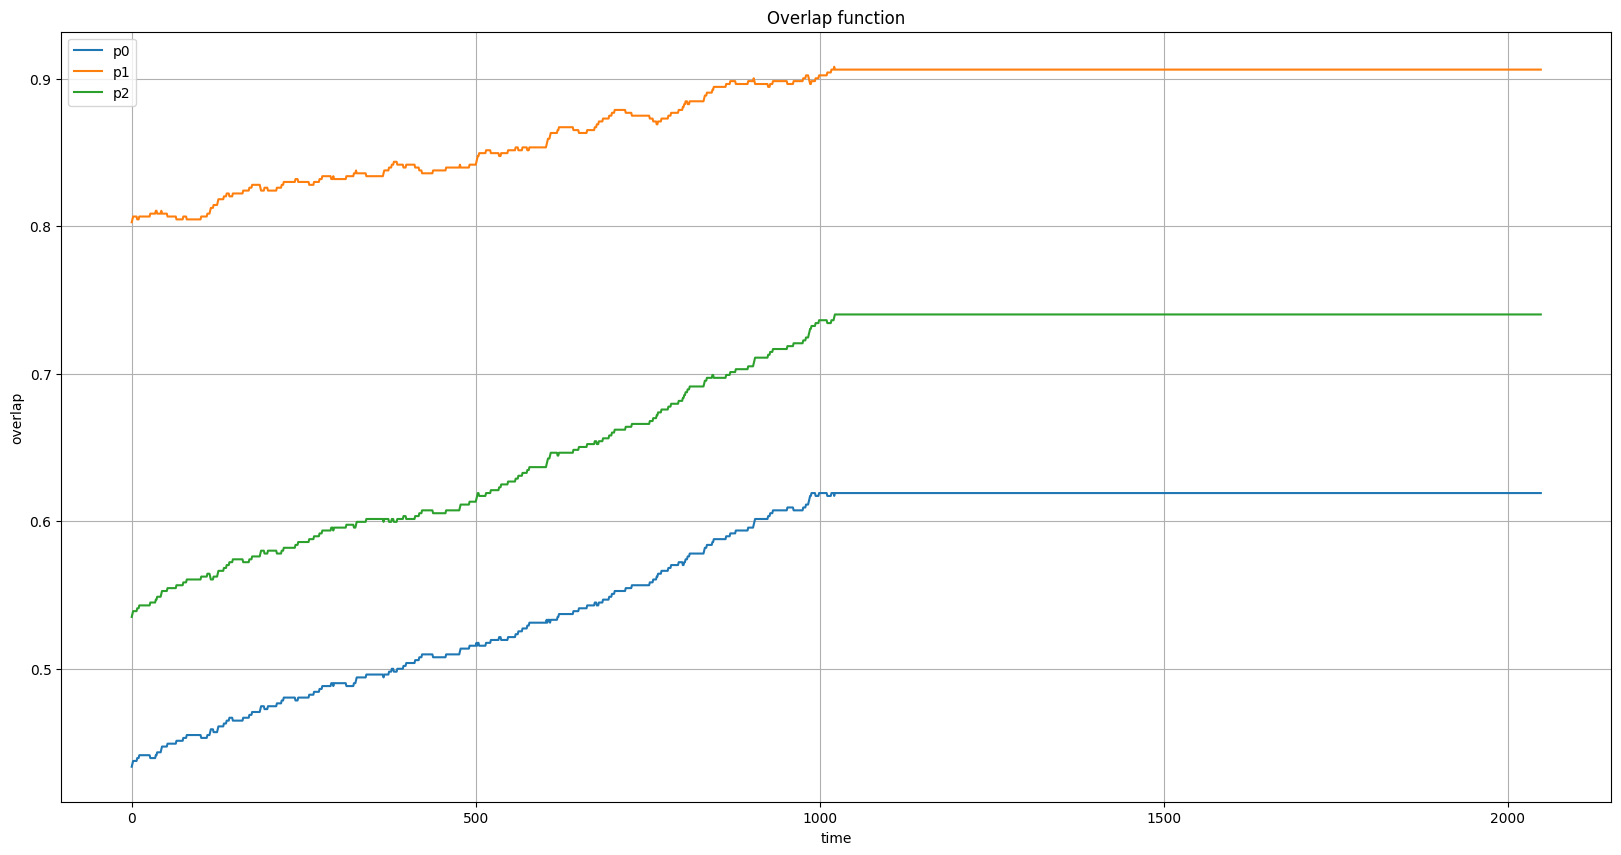

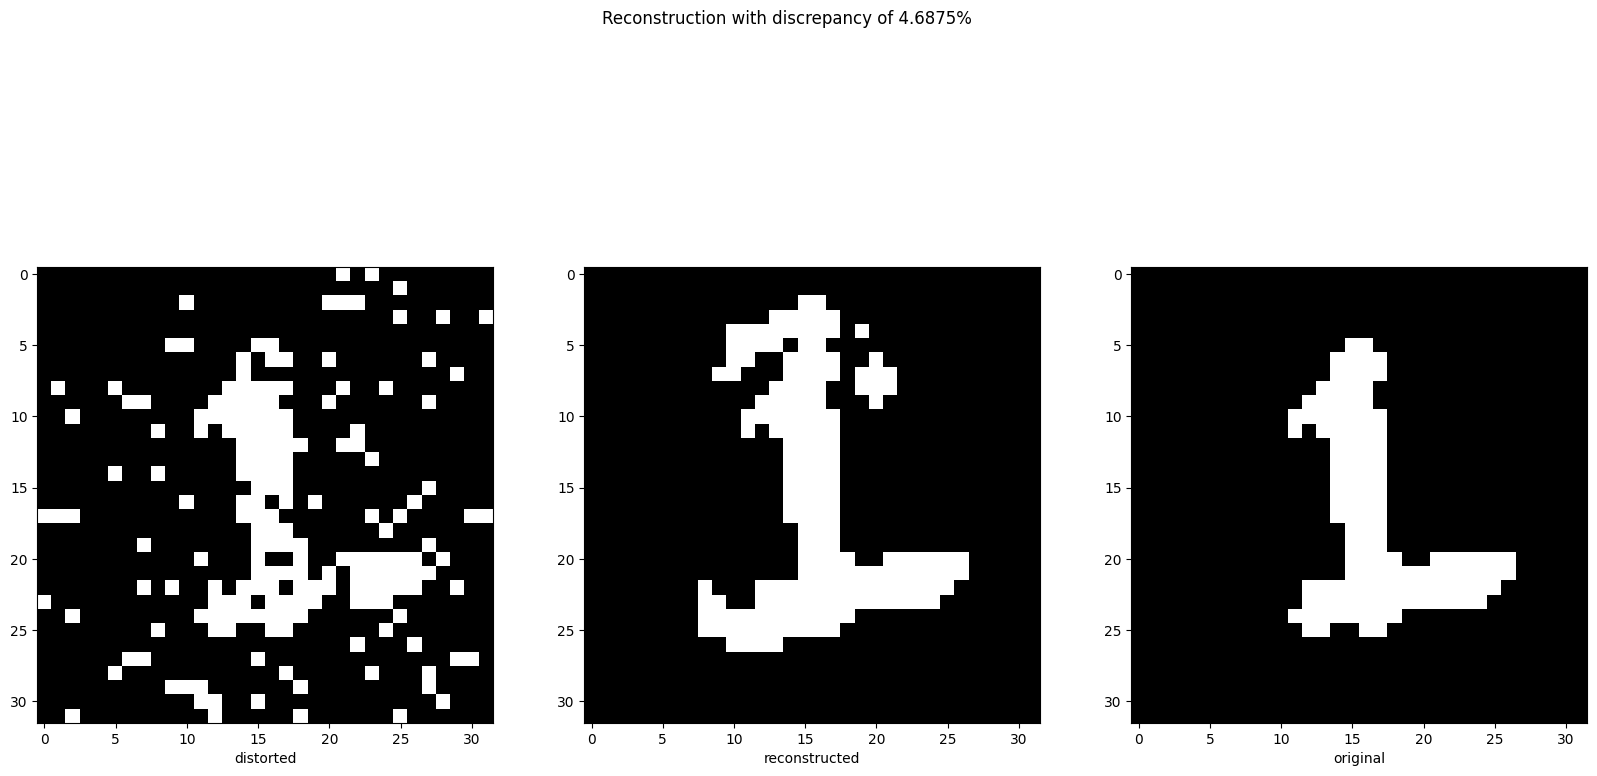

Pattern 1 - Proportion of distortion: 0.25


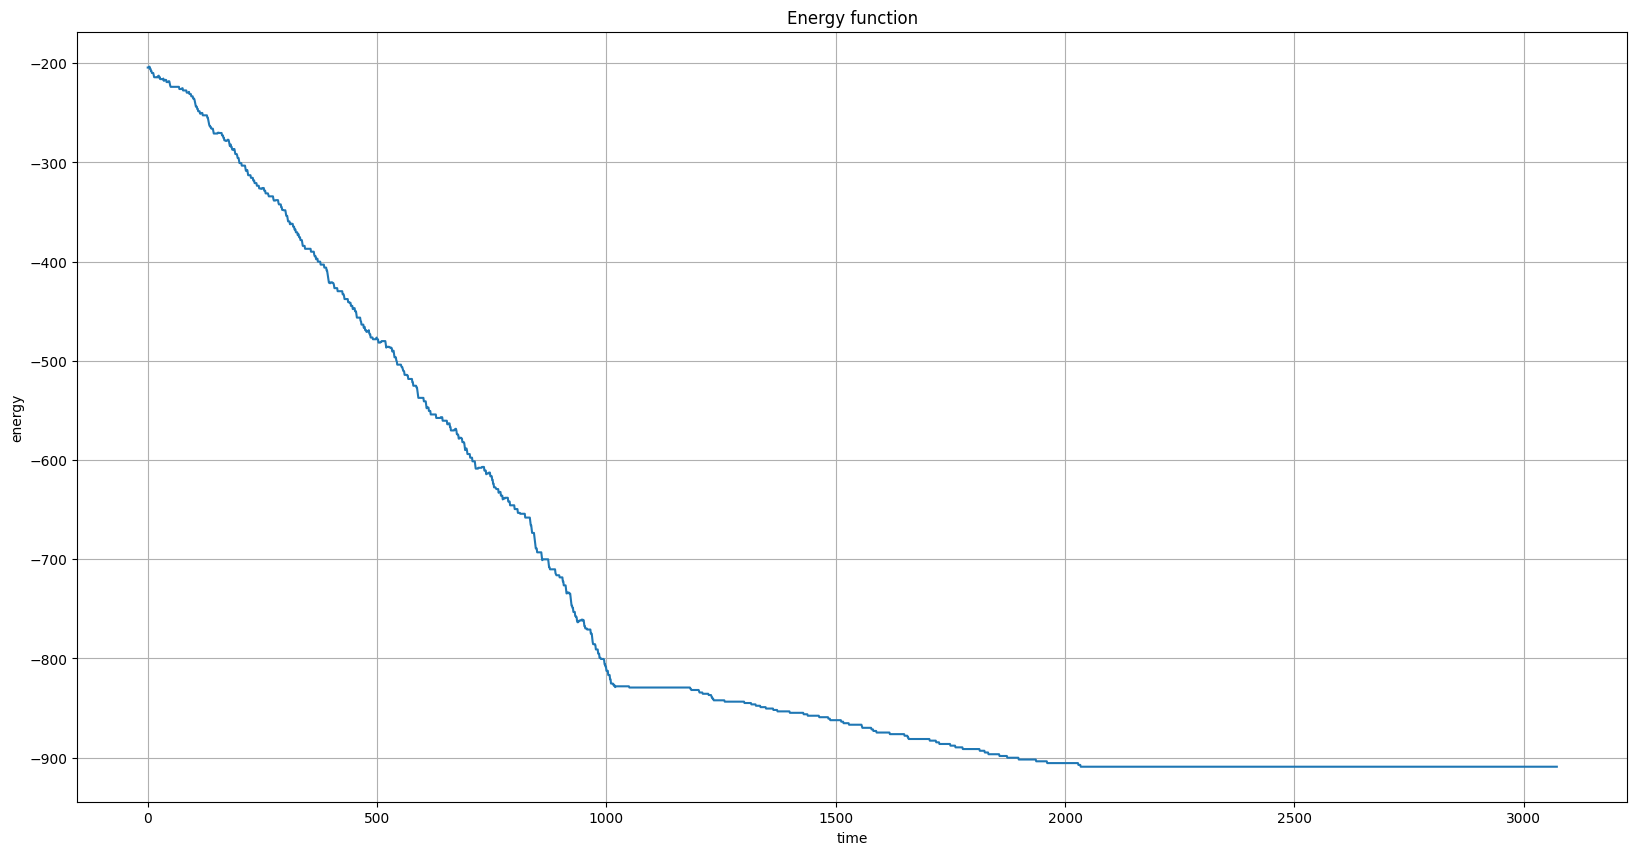

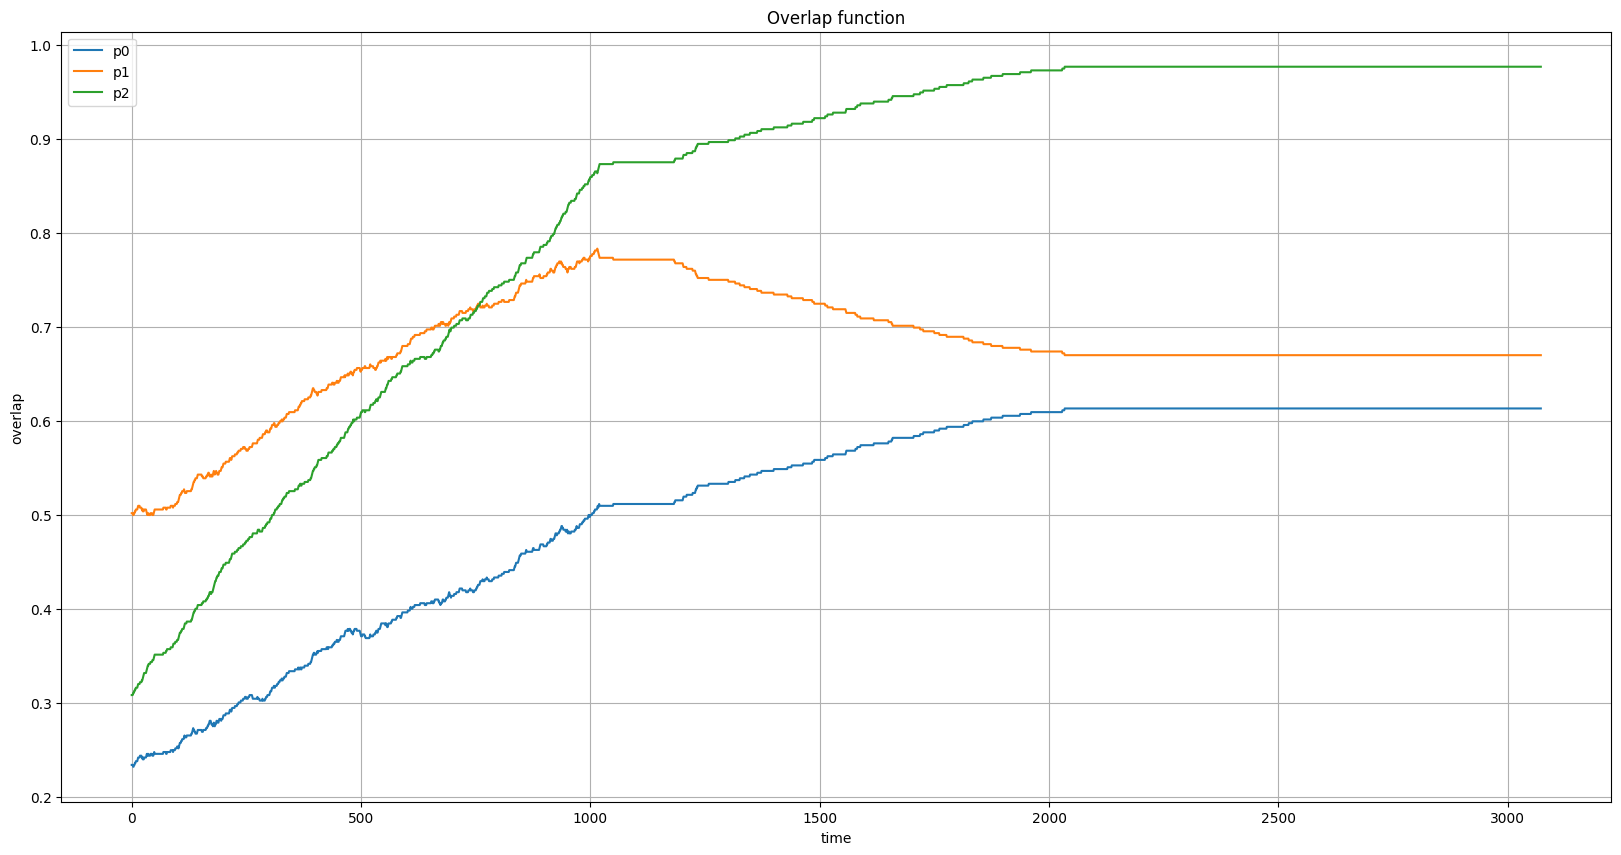

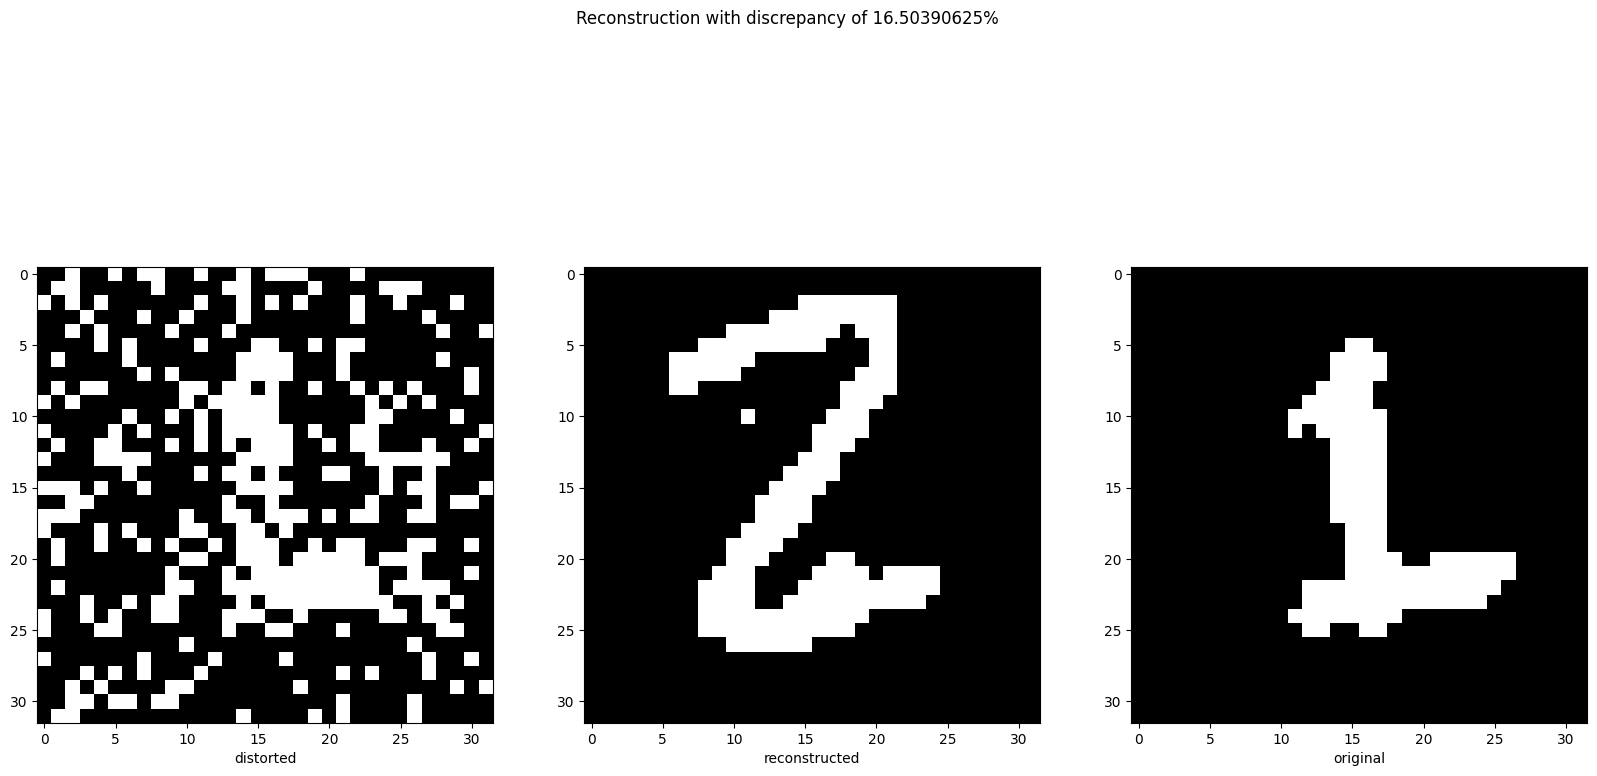

Pattern 2 - Proportion of distortion: 0.05


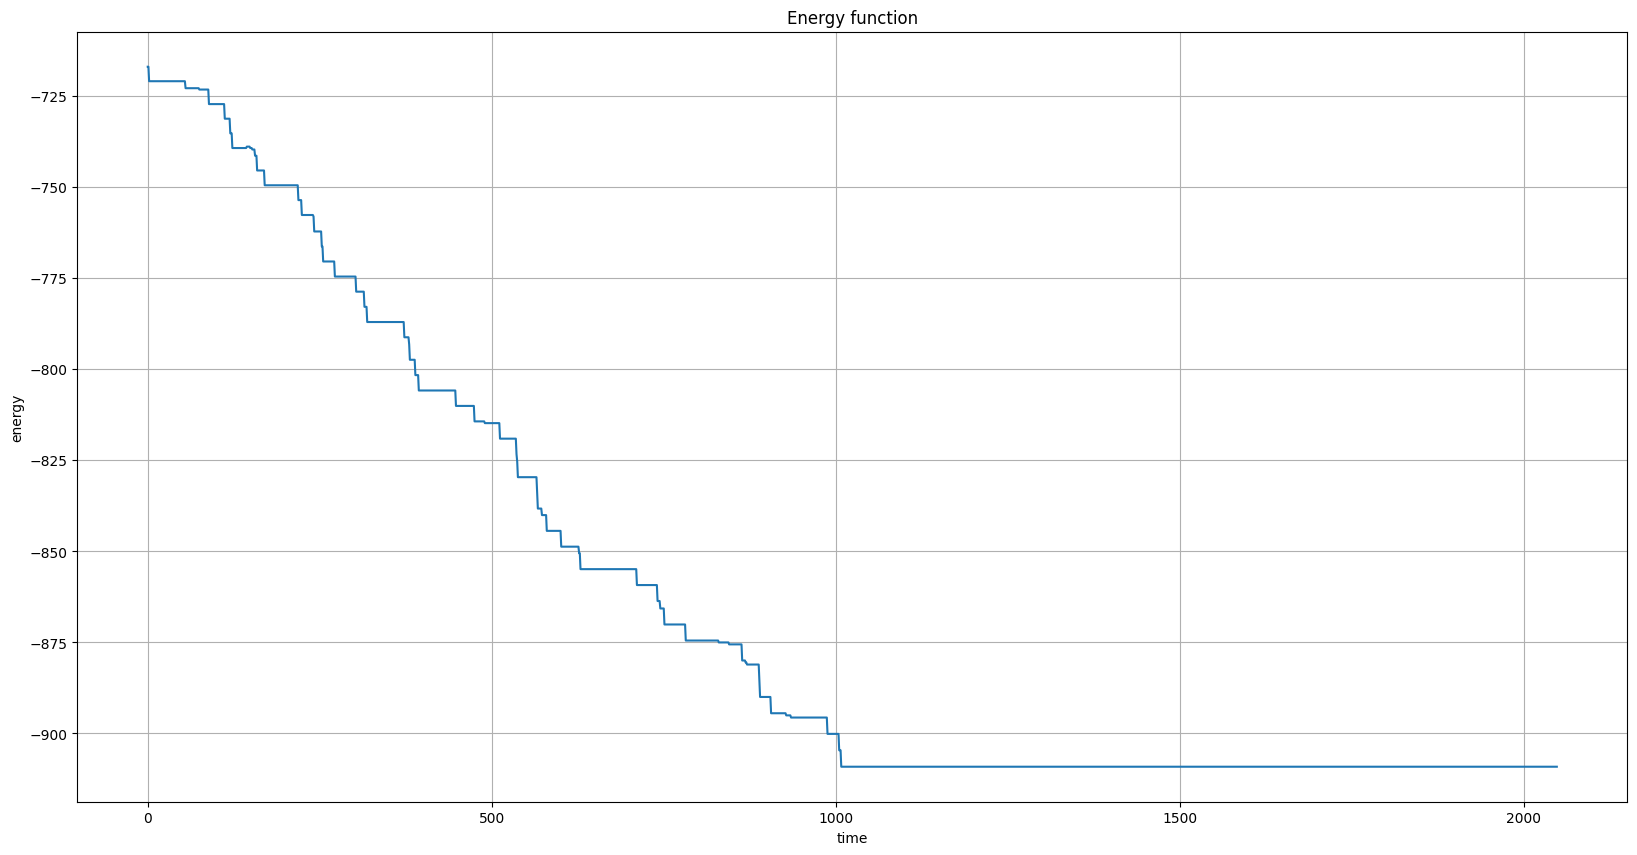

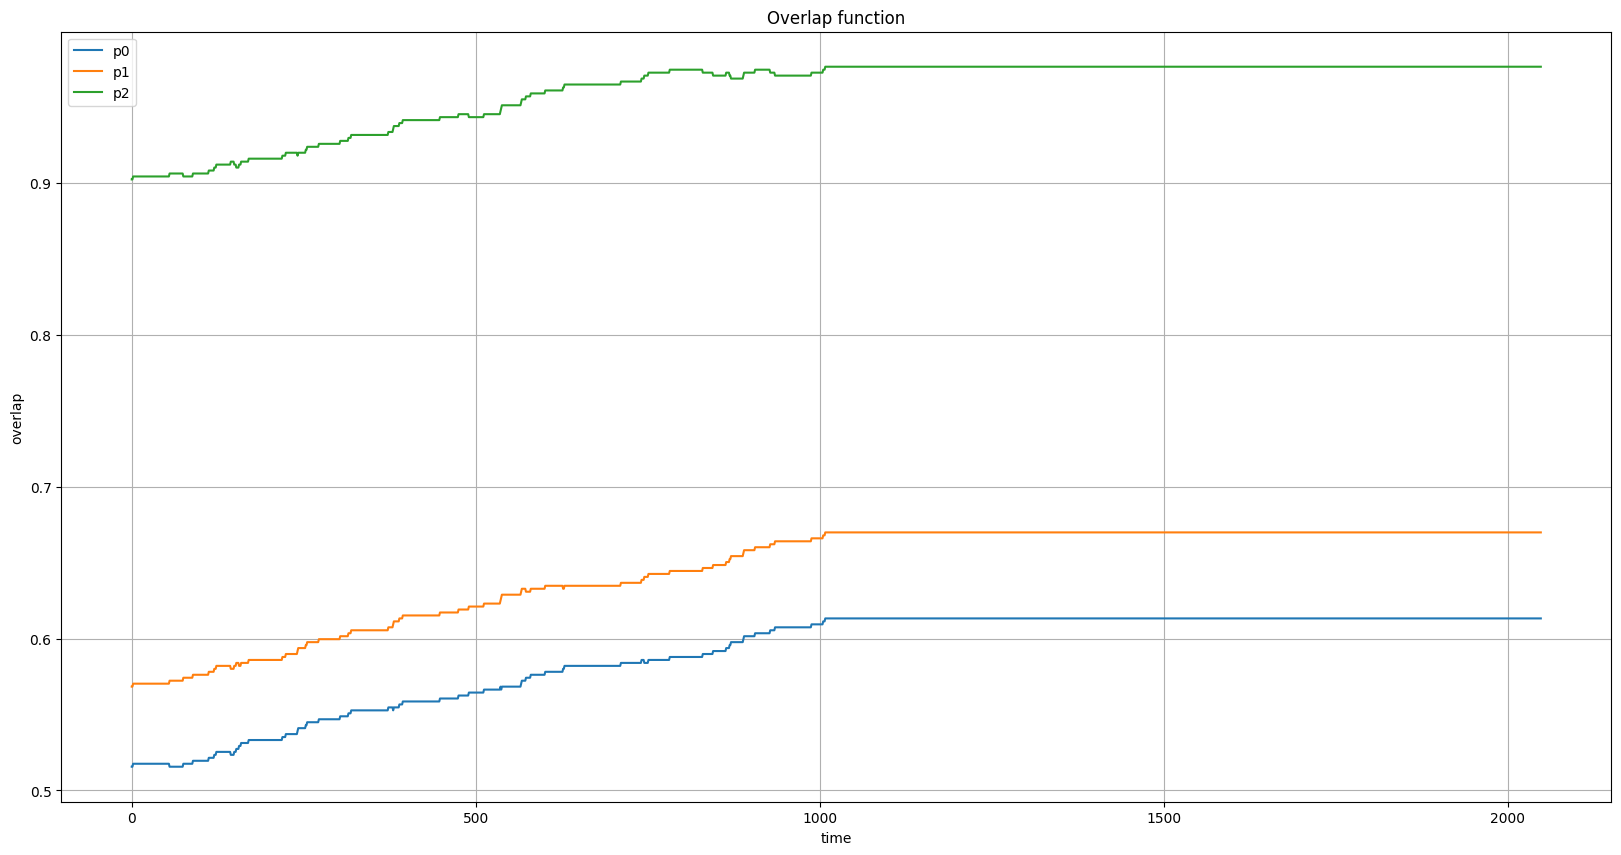

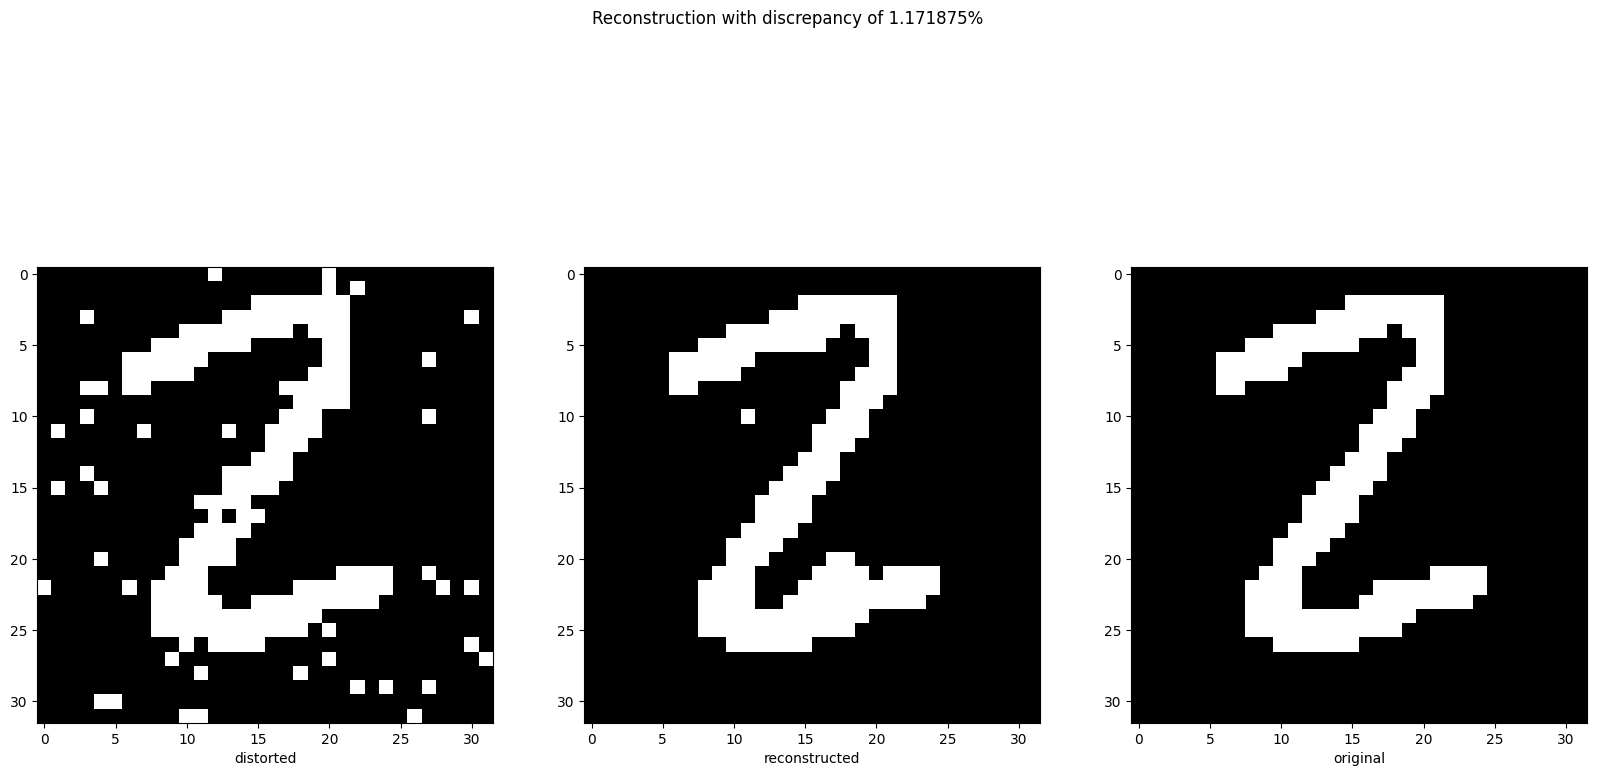

Pattern 2 - Proportion of distortion: 0.1


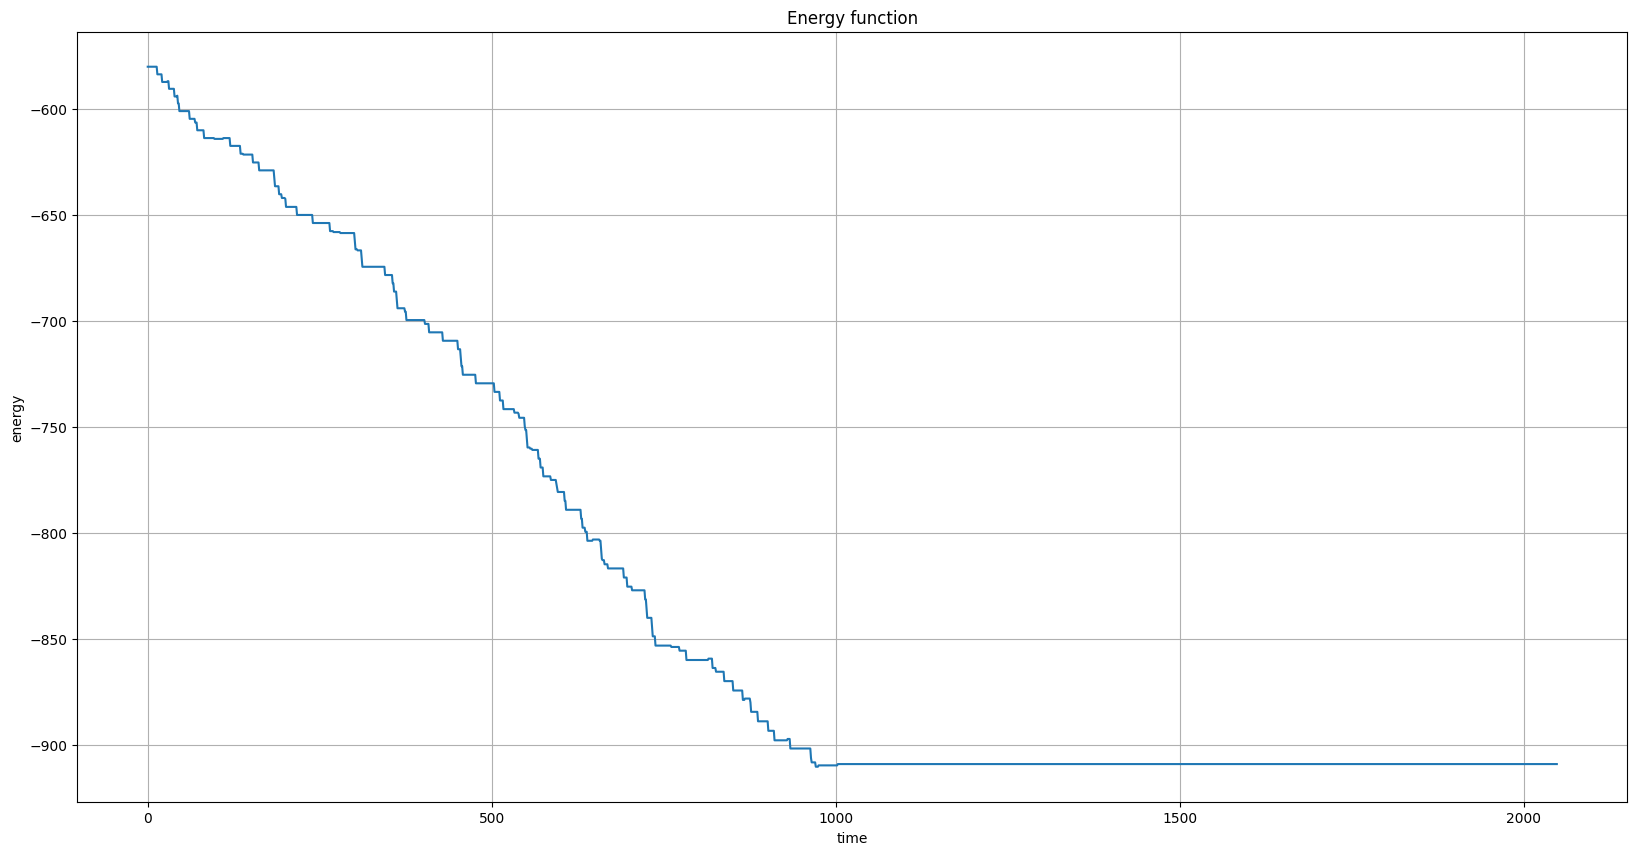

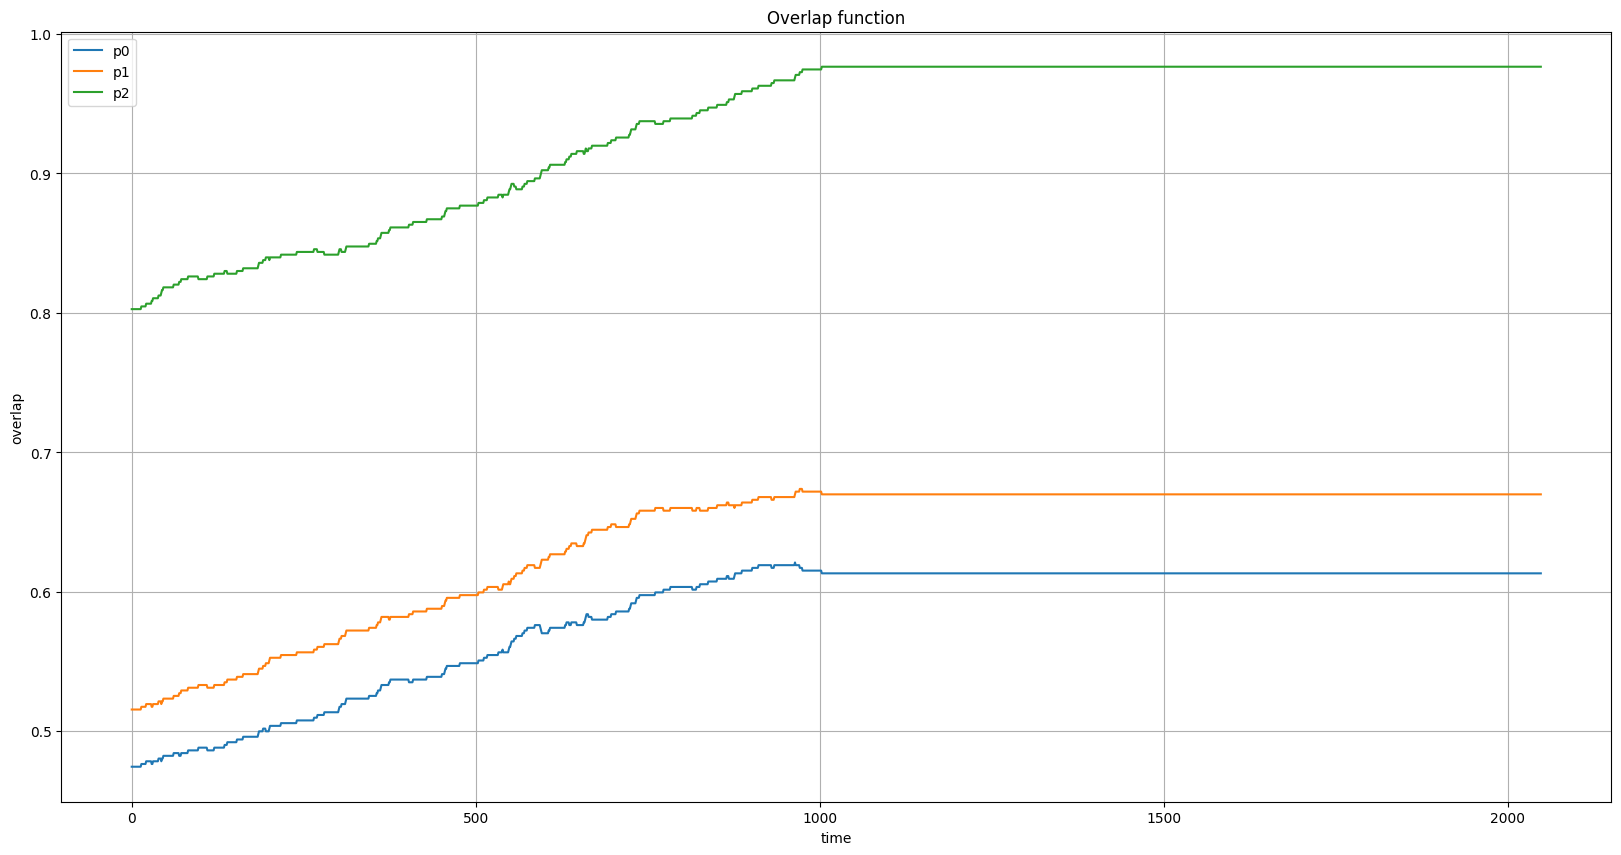

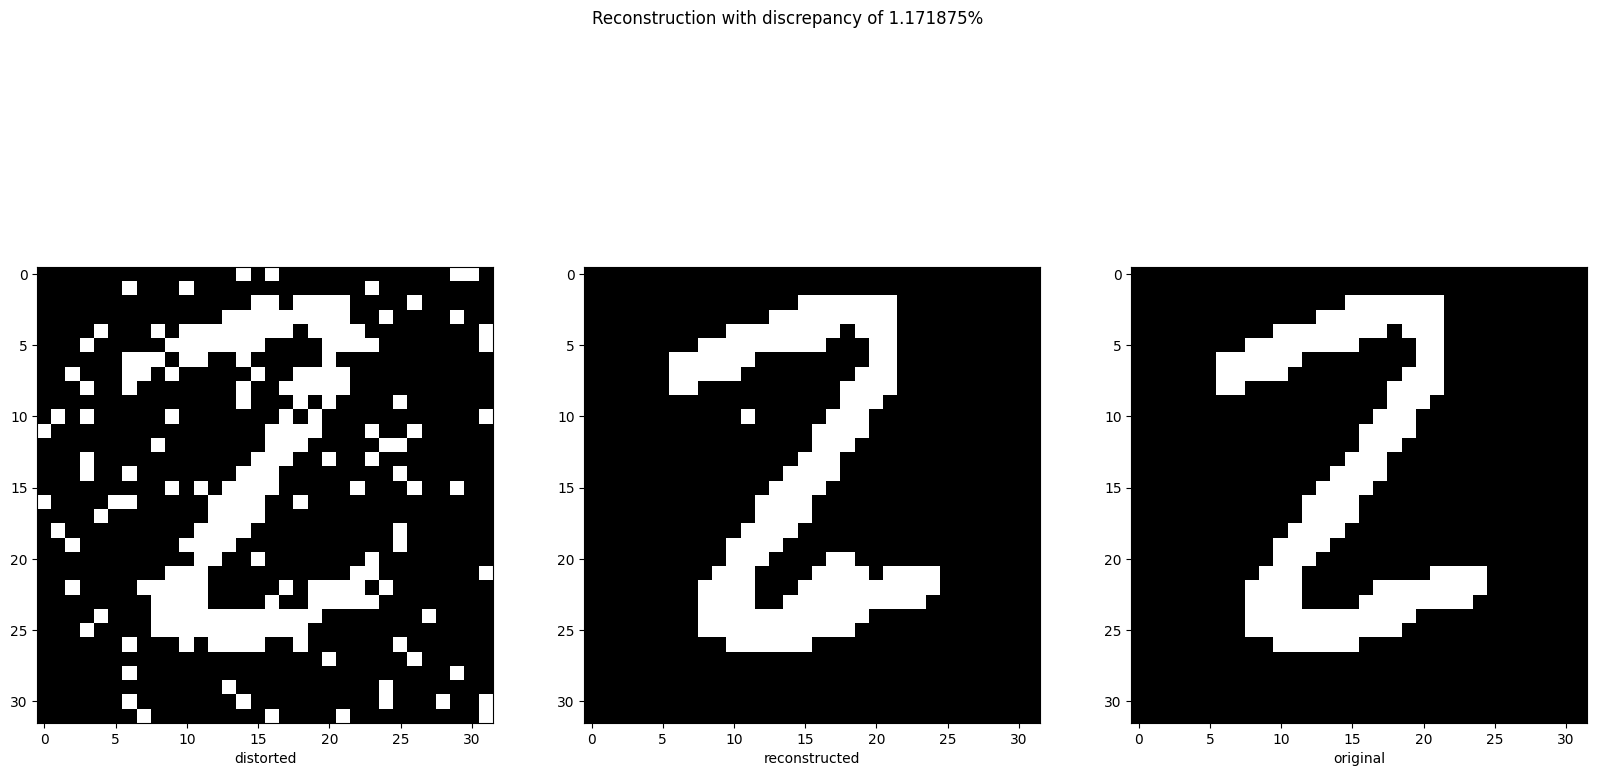

Pattern 2 - Proportion of distortion: 0.25


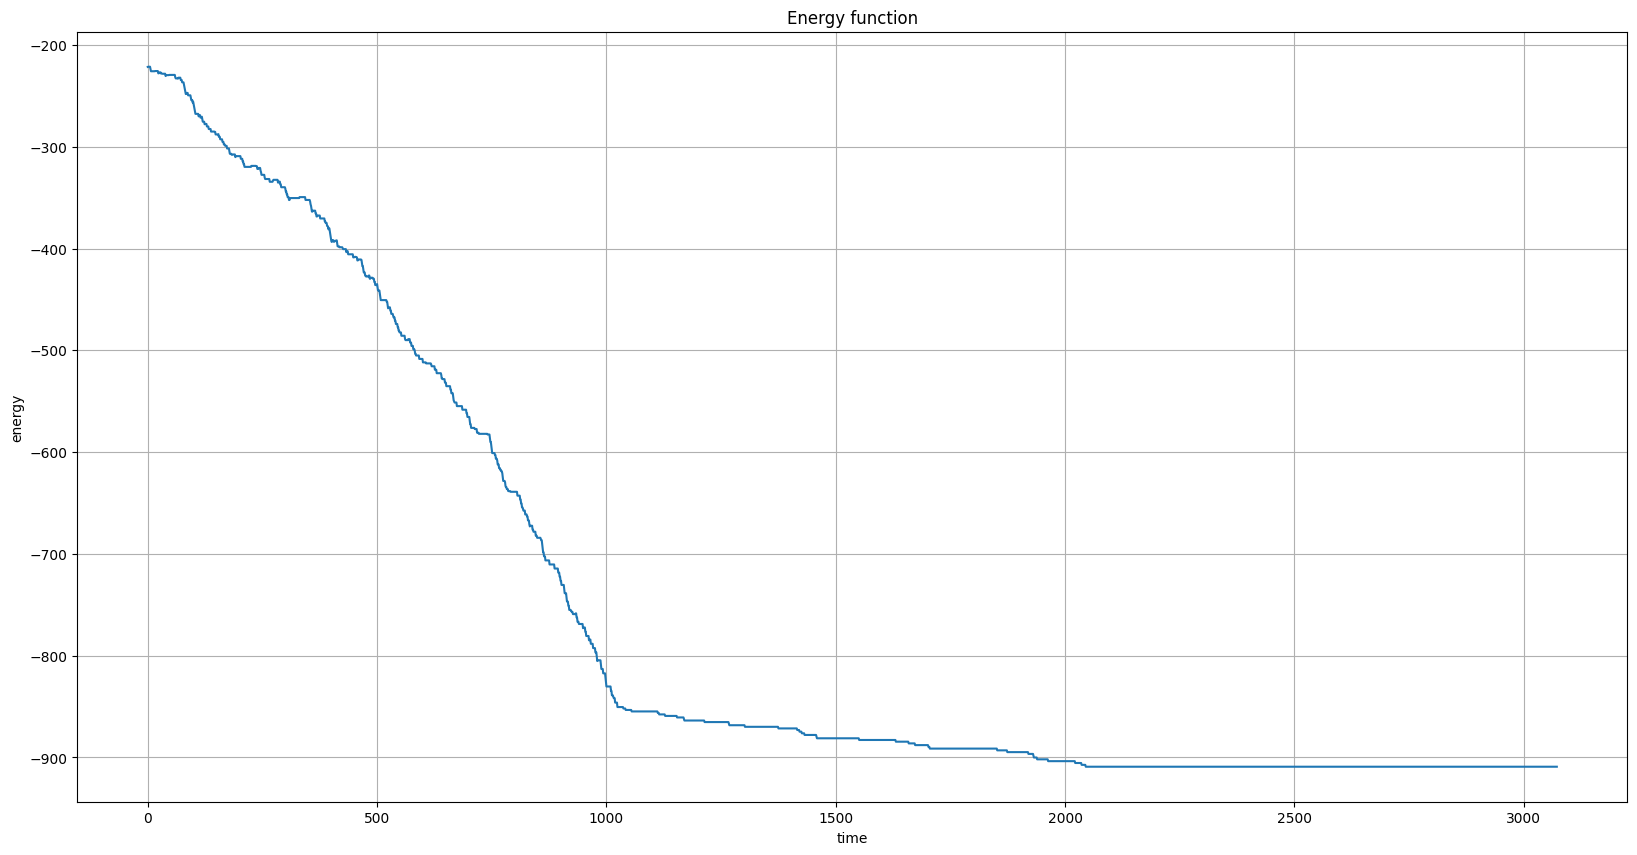

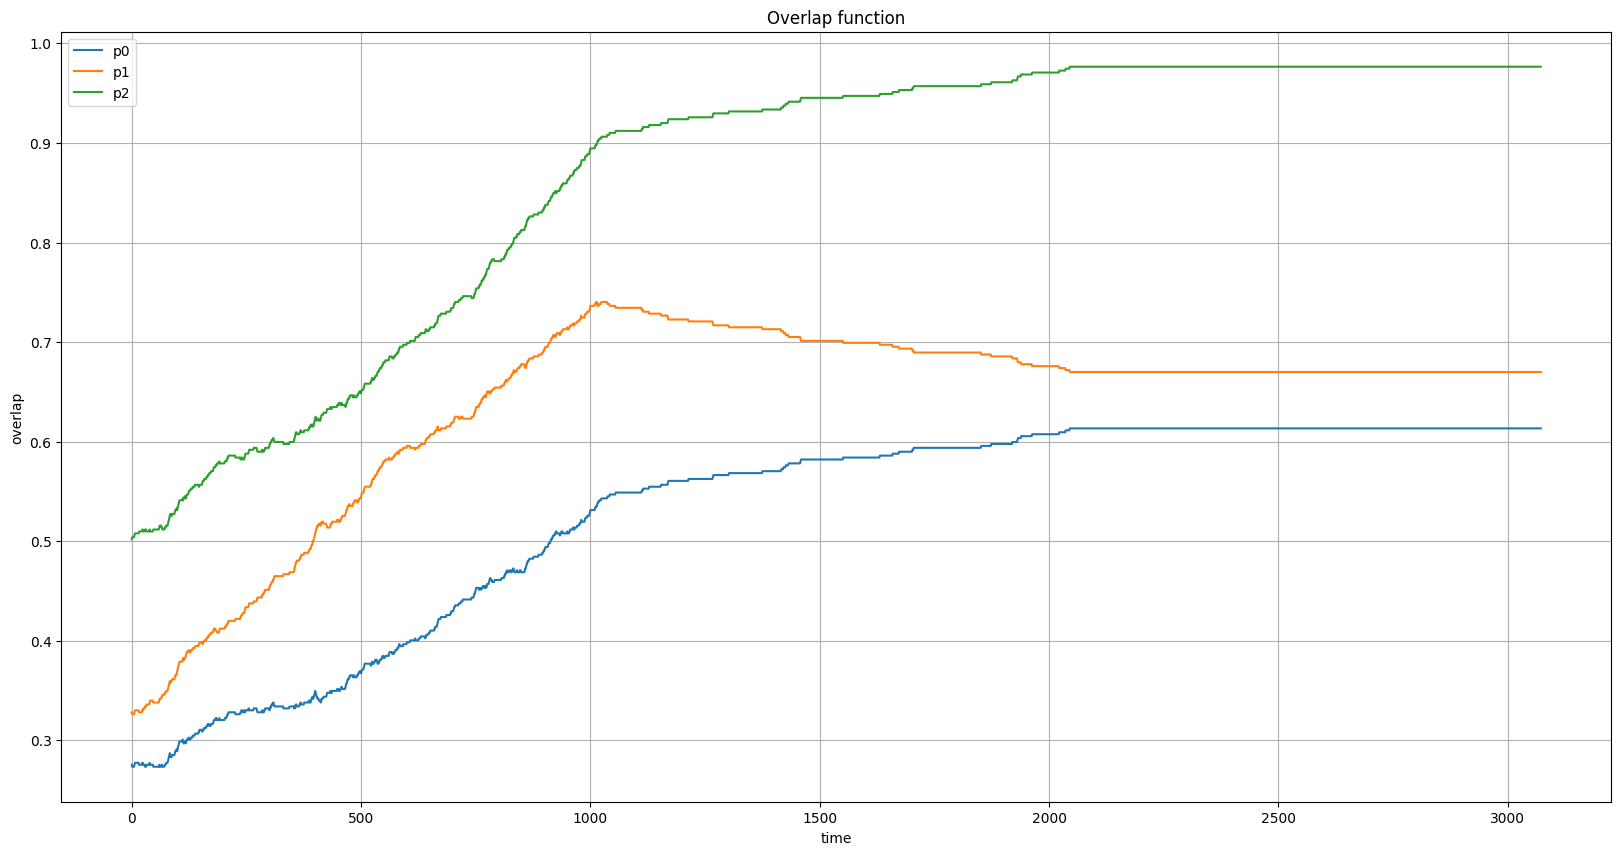

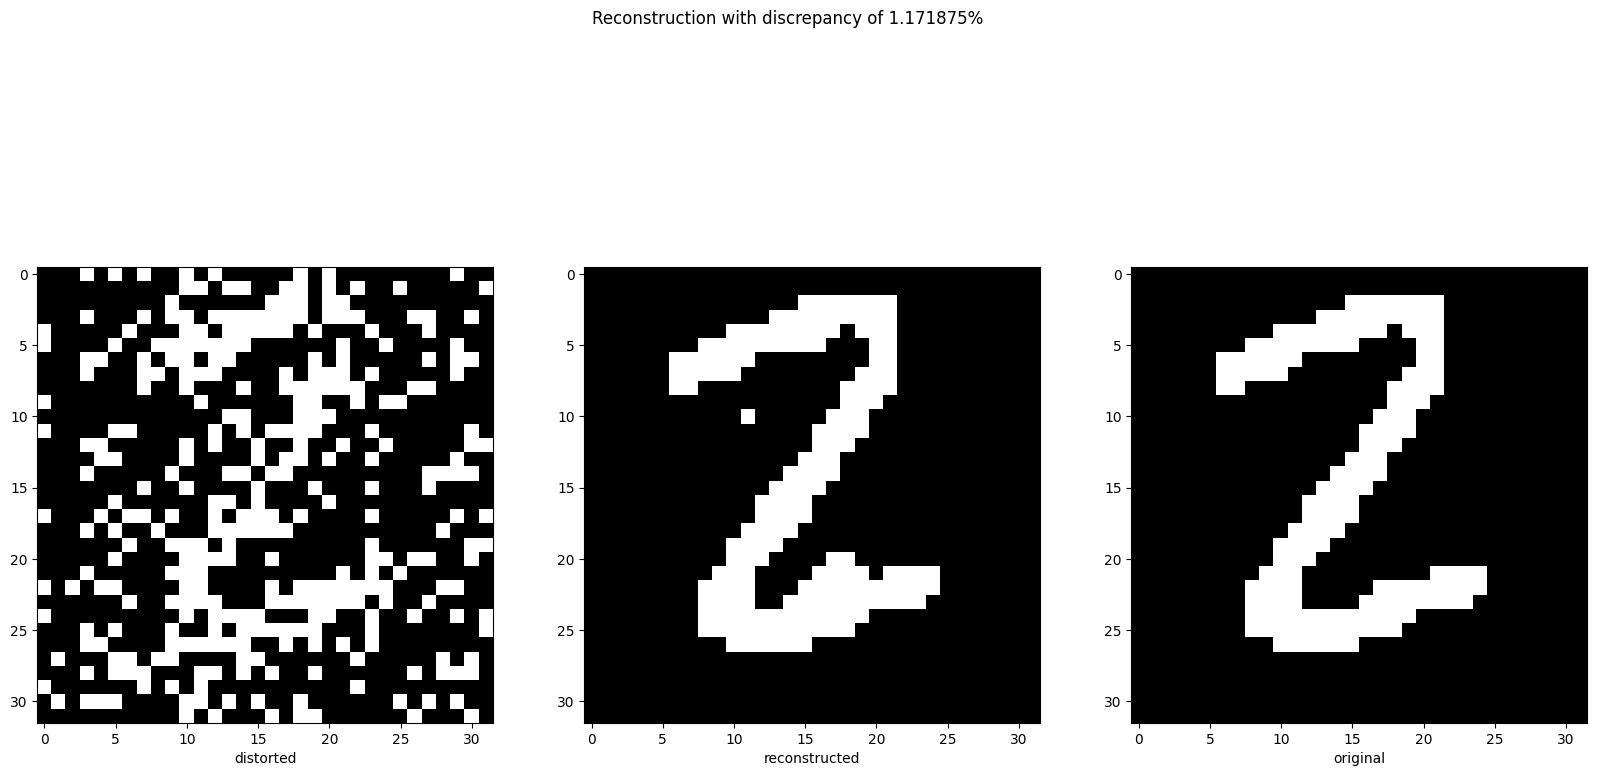

In [14]:
def plot_energy(model: HopfieldNetwork, states: list[np.array], filename: str = None) -> None:
    """
    Function able to plot the energy function.
    """
    plt.figure(figsize=(20, 10))
    plt.title('Energy function')
    plt.plot([model.energy(state) for state in states])
    plt.xlabel('time')
    plt.ylabel('energy')
    plt.grid(True)
    if filename is not None:
        plt.savefig(filename)
    plt.show()


def plot_overlap(model: HopfieldNetwork, states: list[np.array], filename: str = None) -> None:
    """
    Function able to plot the overlap function.
    """
    plt.figure(figsize=(20, 10))
    plt.title('Overlap function')
    for p, _ in enumerate(model.patterns):
        plt.plot([model.overlap(state)[p] for state in states], label=f'p{p}')
    plt.xlabel('time')
    plt.ylabel('overlap')
    plt.grid(True)
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


def plot_reconstruction(model: HopfieldNetwork, pattern_index: int, states: list[np.array],
                        filename: str = None) -> None:
    """
    Function able to plot the the images related to: distortion, reconstruction and the original pattern.
    """
    pattern = model.patterns[pattern_index]
    d = discrepancy(pattern, states[-1])
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    fig.suptitle(f'Reconstruction with discrepancy of {d * 100}%')
    show_img(states[0], ax=ax[0])
    ax[0].set_xlabel('distorted')
    show_img(states[-1], ax=ax[1])
    ax[1].set_xlabel('reconstructed')
    show_img(pattern, ax=ax[2])
    ax[2].set_xlabel('original')
    if filename is not None:
        plt.savefig(filename)
    plt.show()


def plot_from_history(model: HopfieldNetwork, history: list[tuple]) -> None:
    """
    Plot all about history.
    """
    create_filepath = lambda pattern_index, prop, func: f'hopfield_plots/distorted_{pattern_index}_{prop}_{func}.png'
    for p_index, prop, states in history:
        print('Pattern', p_index, '-', 'Proportion of distortion:', prop)
        plot_energy(model, states, filename=create_filepath(p_index, prop, 'energy'))
        plot_overlap(model, states, filename=create_filepath(p_index, prop, 'overlap'))
        plot_reconstruction(model, p_index, states, filename=create_filepath(p_index, prop, 'reconstructed'))


plot_from_history(model, history)

# Bonus track 1 - Synthetic data

Creation of new patterns.

In [15]:
p1 = np.array([-1, -1, +1, -1, +1, -1, -1, +1])
p2 = np.array([-1, -1, -1, -1, -1, +1, -1, -1])
p3 = np.array([-1, +1, +1, -1, -1, +1, -1, +1])

sd_patterns = np.array([p1, p2, p3])

Creation of distorted patterns.

In [16]:
p1d = np.array([+1, -1, +1, -1, +1, -1, -1, +1])
p2d = np.array([+1, +1, -1, -1, -1, +1, -1, -1])
p3d = np.array([+1, +1, +1, -1, +1, +1, -1, +1])

sd_d_patterns = np.array([p1d, p2d, p3d])

Creation of Hopfield network on new patterns and run of retrieval phase for each distortion of patterns until convergence.

In [17]:
sd_model = HopfieldNetwork(sd_patterns, bias=0)

sd_history = []

for i_d, pd in enumerate(sd_d_patterns):
    states = sd_model.retrieval(pd)
    sd_history.append(states)

Print results.

In [18]:
for i_d, states in enumerate(sd_history):
    print(f'Pattern {i_d + 1}')
    print('\t', 'discrepancy:', discrepancy(sd_patterns[i_d], states[-1]) * 100, '%')
    print('\t', sd_d_patterns[i_d], '\tdistorted')
    print('\t', states[-1], '\treconstructed')
    print('\t', sd_patterns[i_d], '\toriginal')

Pattern 1
	 discrepancy: 0.0 %
	 [ 1 -1  1 -1  1 -1 -1  1] 	distorted
	 [-1 -1  1 -1  1 -1 -1  1] 	reconstructed
	 [-1 -1  1 -1  1 -1 -1  1] 	original
Pattern 2
	 discrepancy: 0.0 %
	 [ 1  1 -1 -1 -1  1 -1 -1] 	distorted
	 [-1 -1 -1 -1 -1  1 -1 -1] 	reconstructed
	 [-1 -1 -1 -1 -1  1 -1 -1] 	original
Pattern 3
	 discrepancy: 37.5 %
	 [ 1  1  1 -1  1  1 -1  1] 	distorted
	 [-1 -1  1 -1  1 -1 -1  1] 	reconstructed
	 [-1  1  1 -1 -1  1 -1  1] 	original


Plots of activations for each pattern.

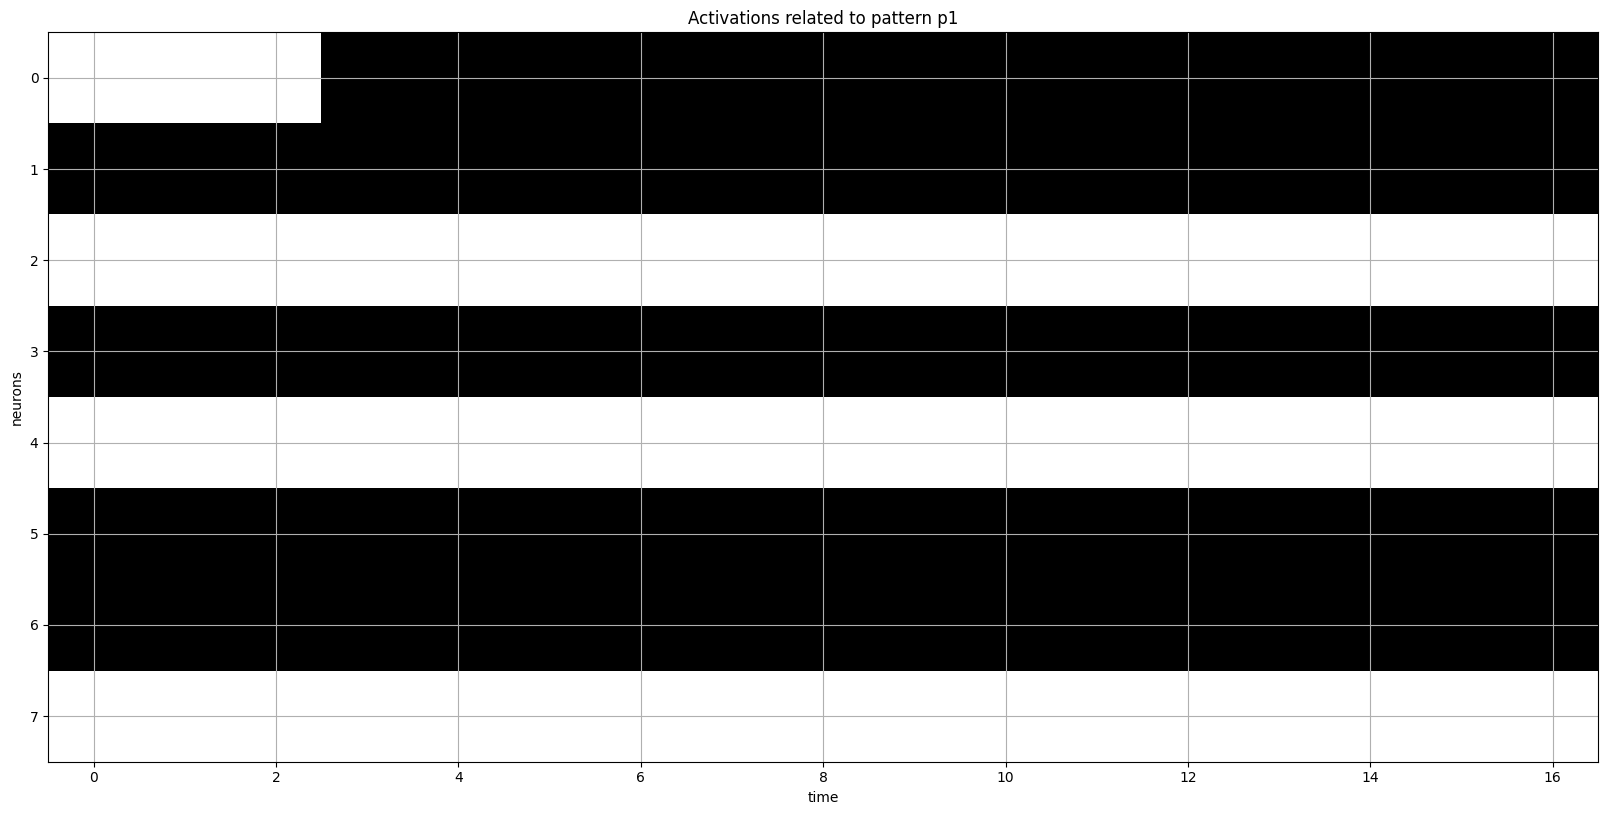

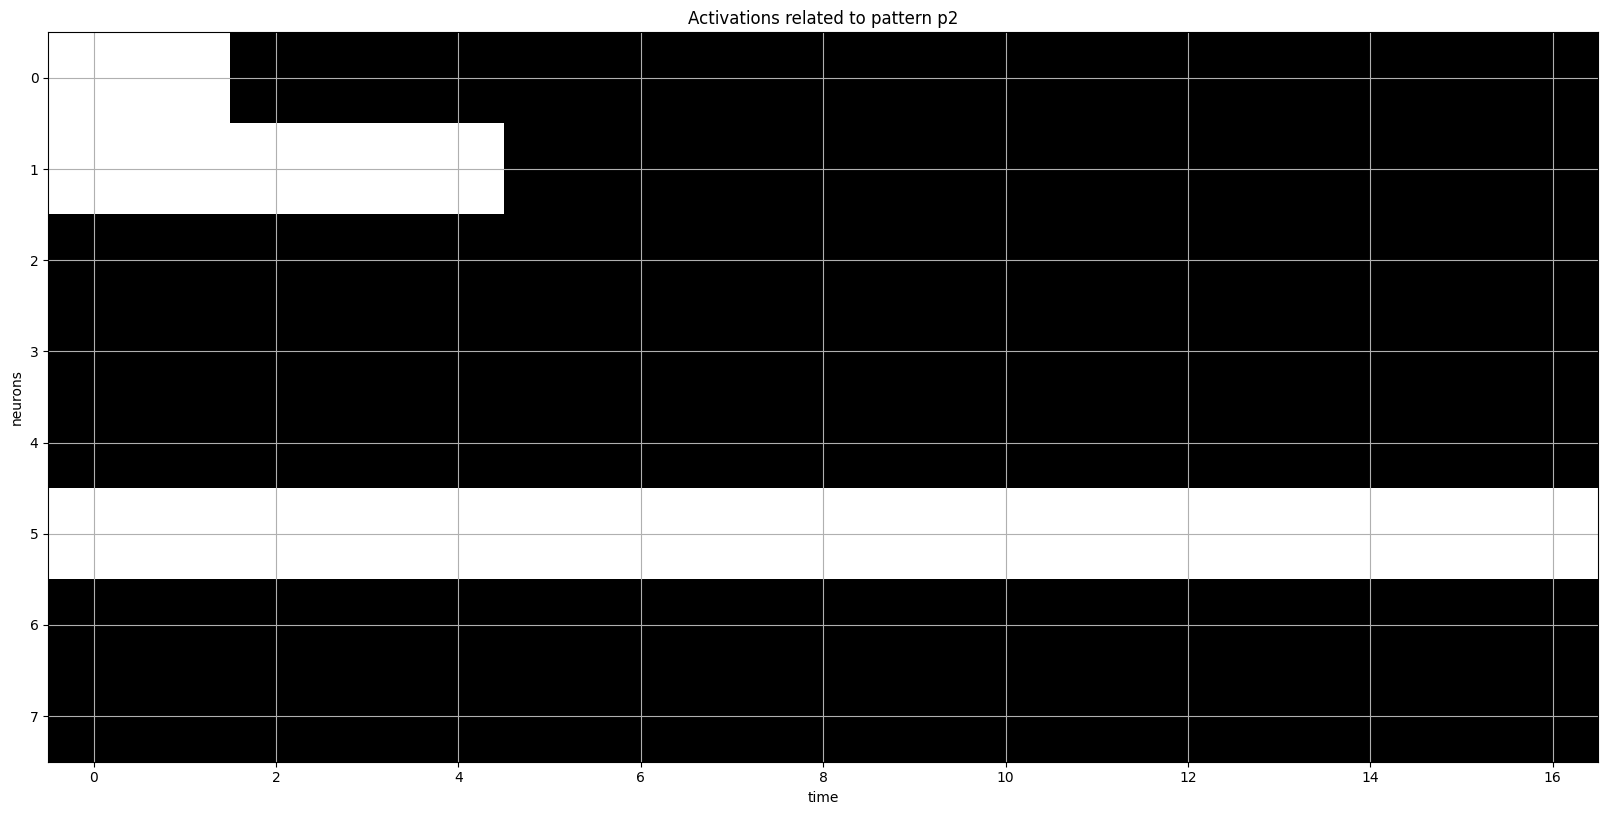

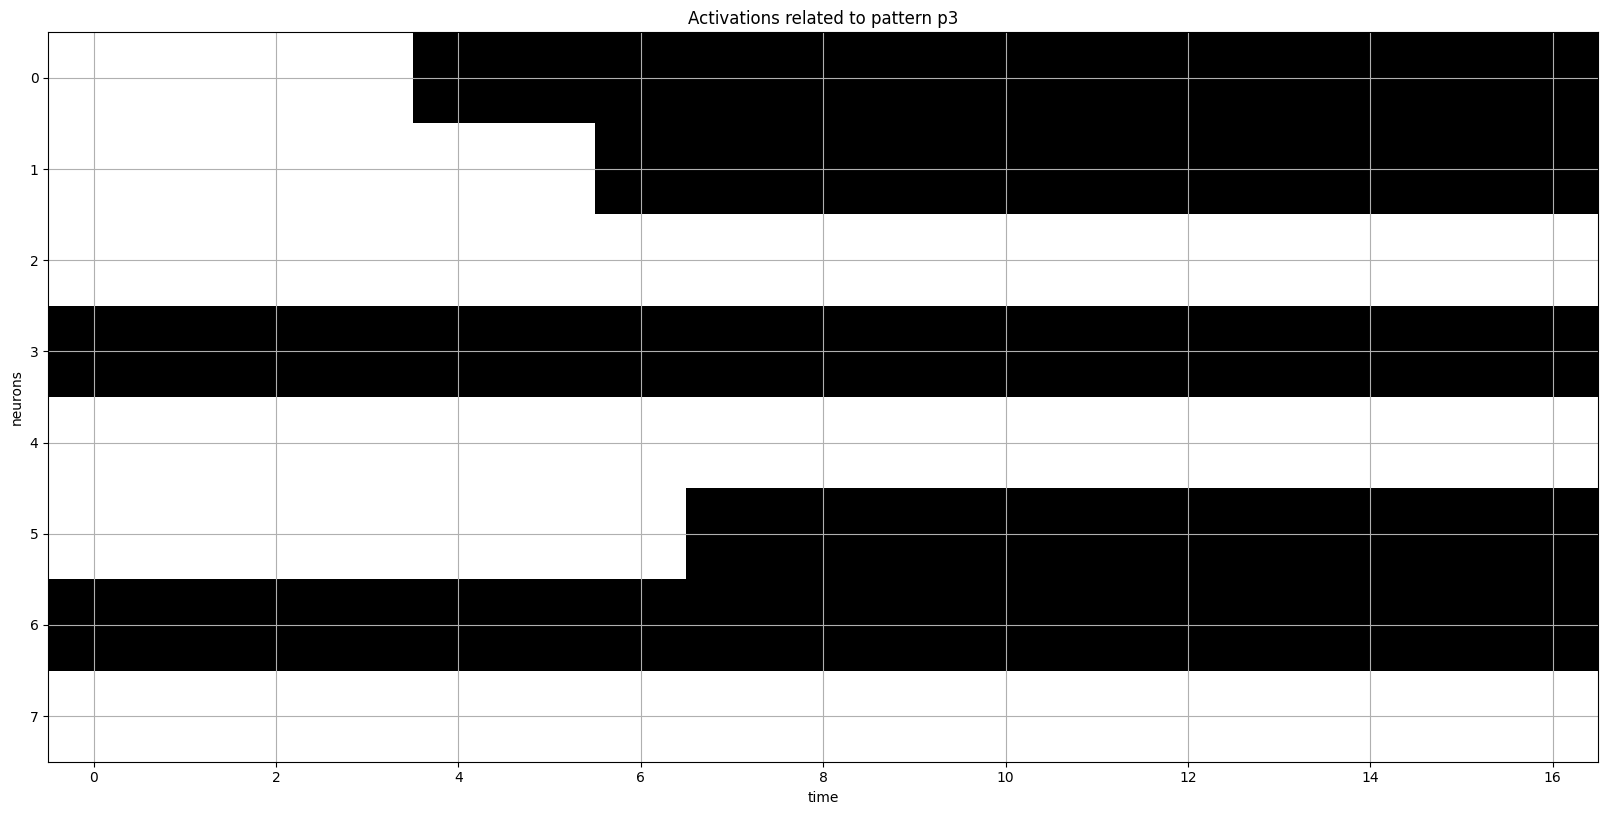

In [19]:
for i_d, pd in enumerate(sd_history):
    matrix = np.array(pd).T
    plt.figure(figsize=(20, 10))
    plt.title(f'Activations related to pattern p{i_d + 1}')
    plt.imshow(matrix, cmap='gray', vmin=-1, vmax=1)
    plt.xlabel(f'time')
    plt.ylabel(f'neurons')
    plt.grid(True)
    np.save(f'matrices/activations_{i_d + 1}', matrix)
    plt.savefig(f'hopfield_plots/[BONUS TRACK 1] activations_{i_d + 1}.png')
    plt.show()

# Bonus track 2 - How can you remember?

Load dataset of all the digits and initialization of proportion of distortion to apply.

In [20]:
ad_patterns = np.array([load_p_data(f'p{i}', dir='lab2_2_alldigits') for i in range(10)])
ad_props = [0.05]

Definition of the variable to store average discrepancies for each added pattern in the followwing algorithm and definition of function to abstract the retrieval phase.

In [21]:
avg_discrepancies = []


def perform_ad_retrieval(until_p_index: int, props: list[float], model: HopfieldNetwork) -> None:
    """
    All digits retrieval phase able to run it on the model and store and plot results.
    """
    mean_discrepancy, history = perform_retrieval(model, props)
    avg_discrepancies.append(mean_discrepancy)
    print(f'Network storing patterns until {until_p_index}')
    for index_p, prop, states in history:
        print(f'Overlap or pattern {index_p}')
        plot_overlap(model, states,
                     filename=f'hopfield_plots/[BONUS TRACK 2] distorted_until{until_p_index}_p{index_p}_overlap.png')

Incremental approach where it's trained the network on firsts examples and then for each new pattern thi is added to the network and the weights are summed to the store function applied to the new pattern.

Network storing patterns until 2
Overlap or pattern 0


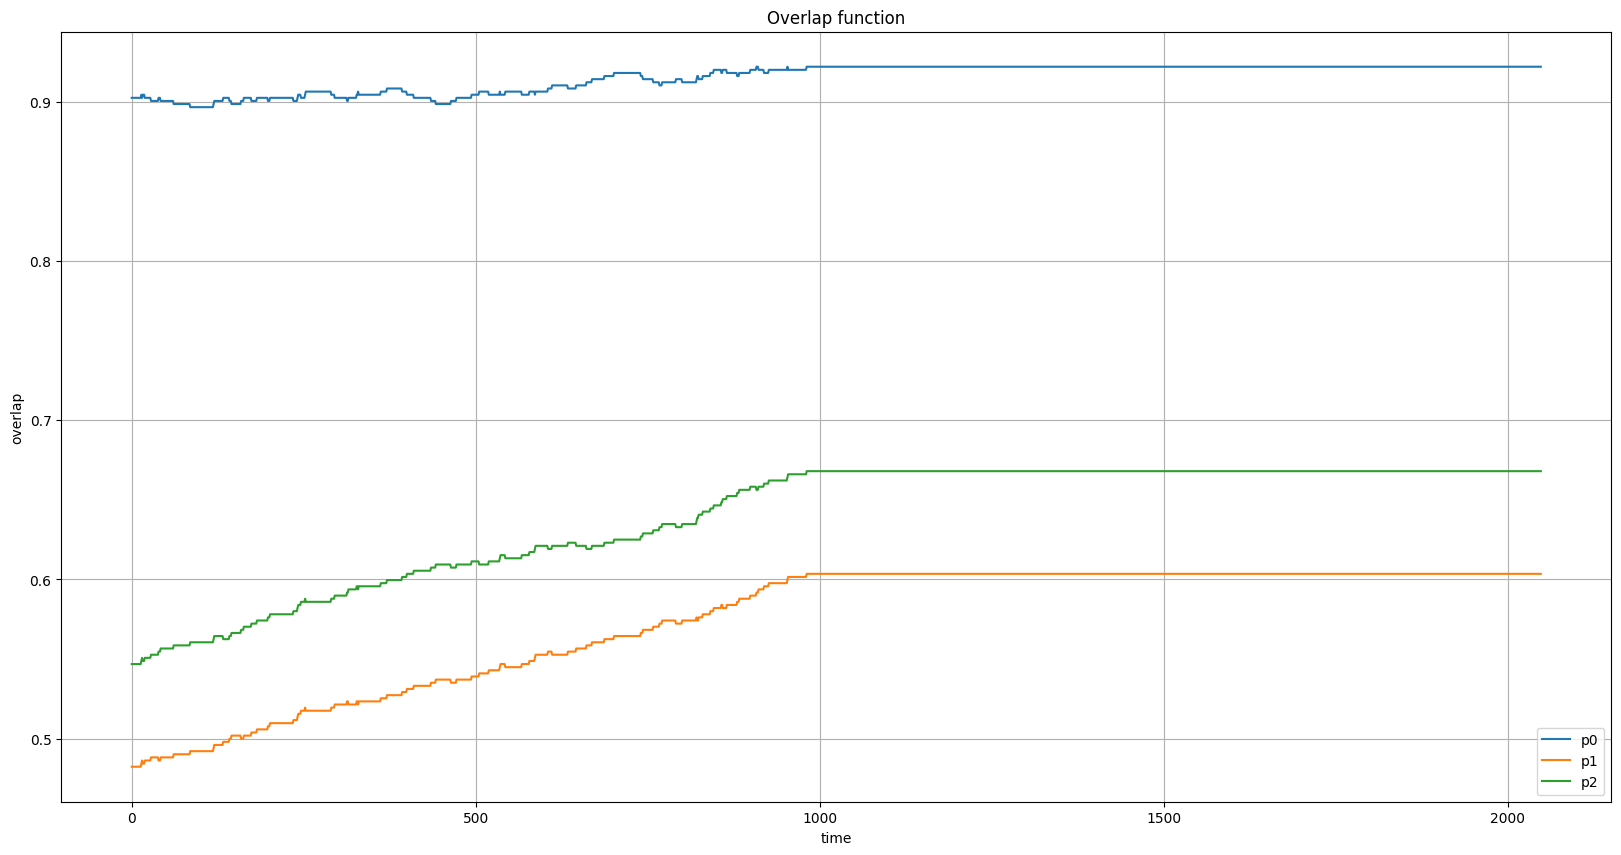

Overlap or pattern 1


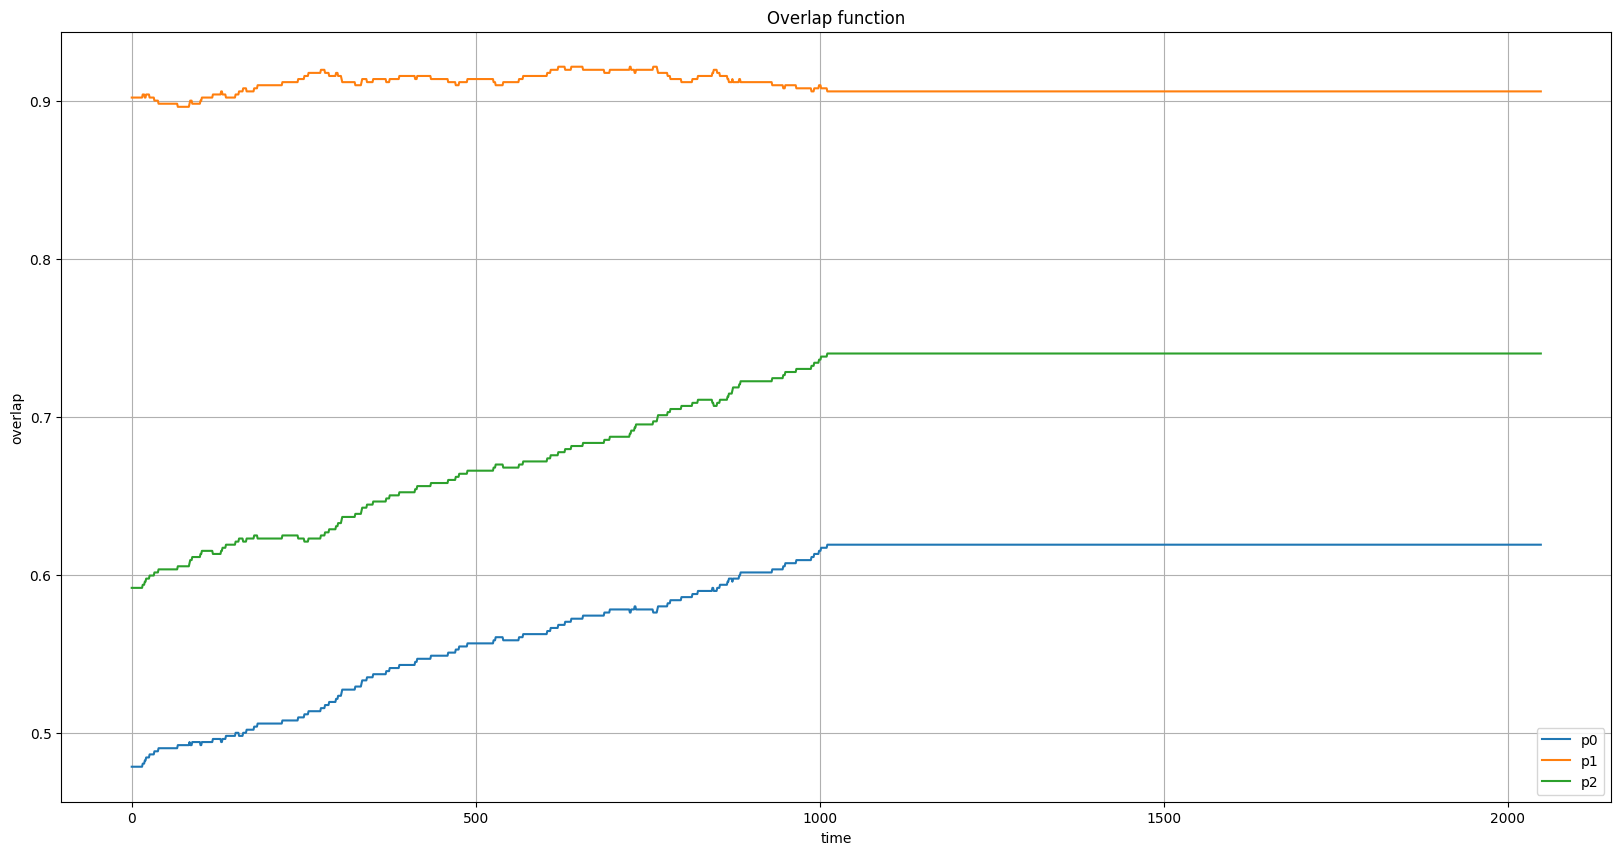

Overlap or pattern 2


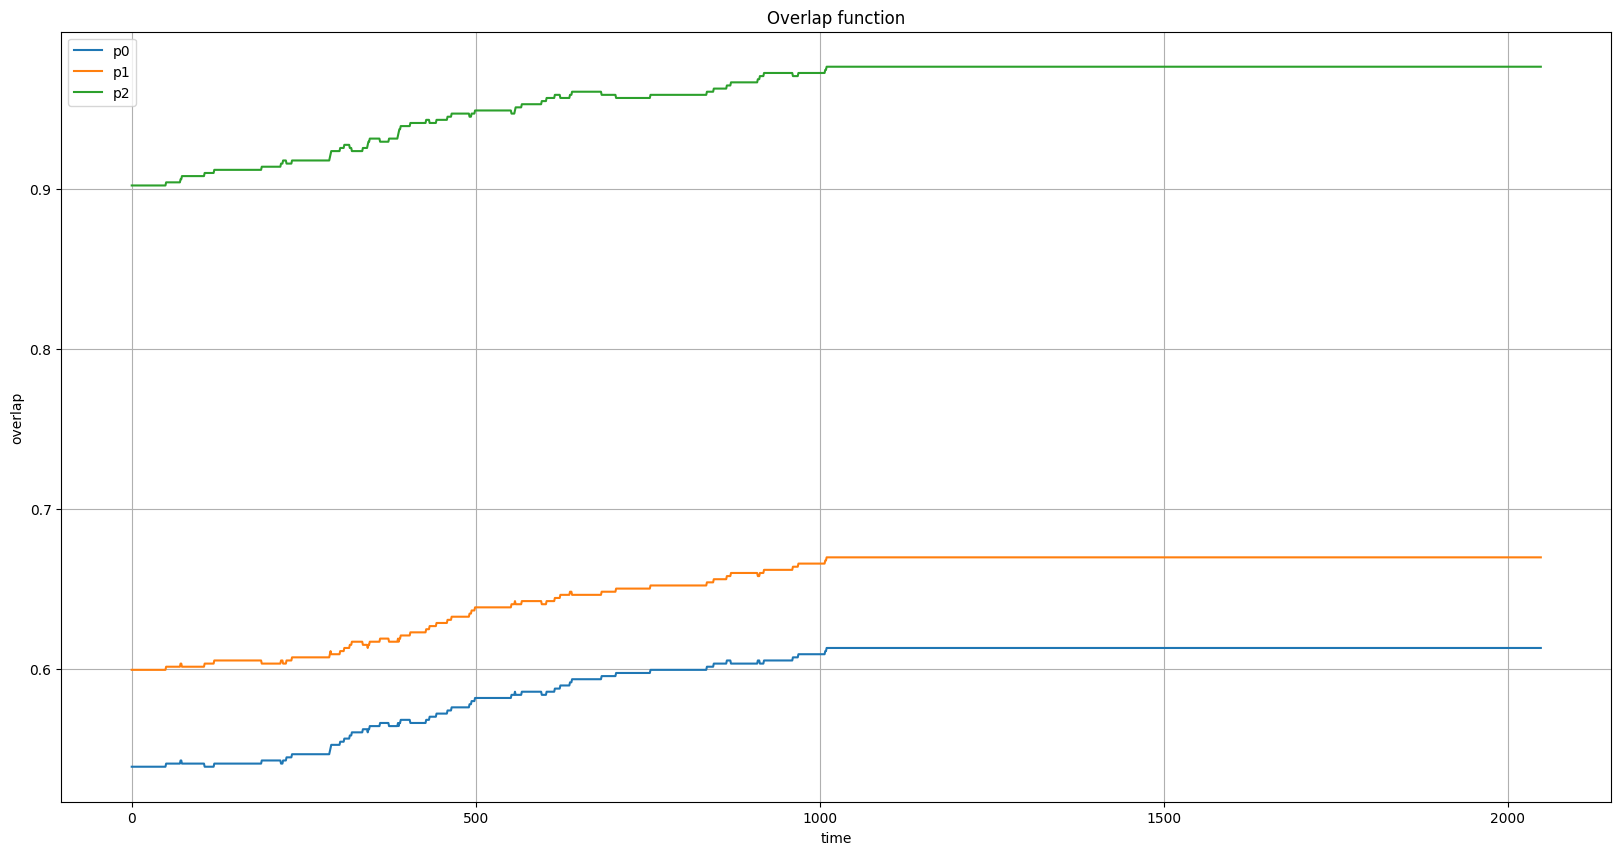

Network storing patterns until 3
Overlap or pattern 0


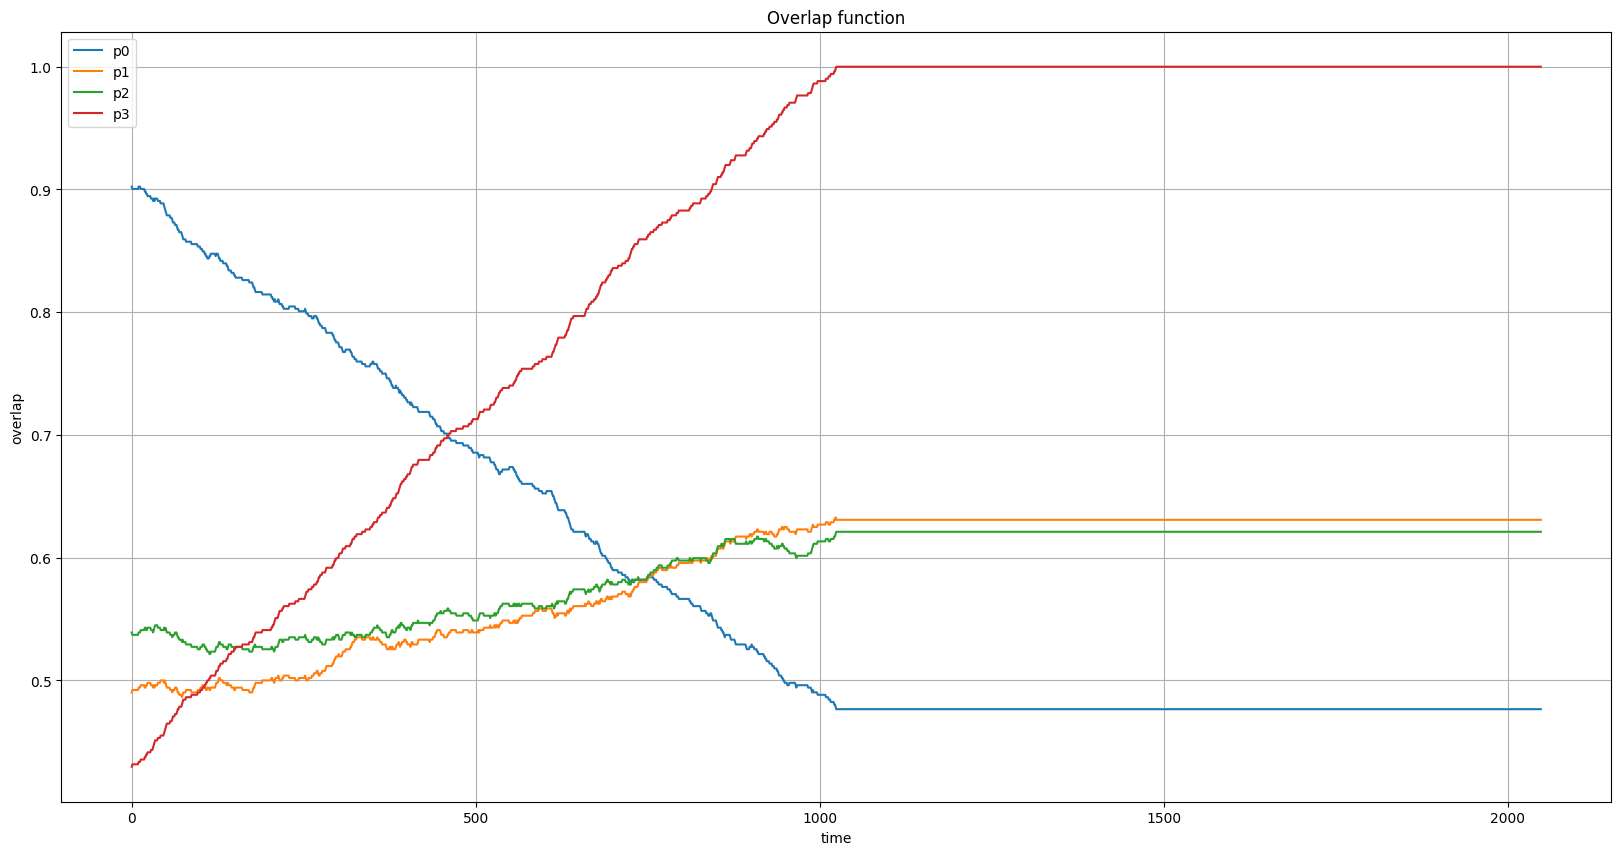

Overlap or pattern 1


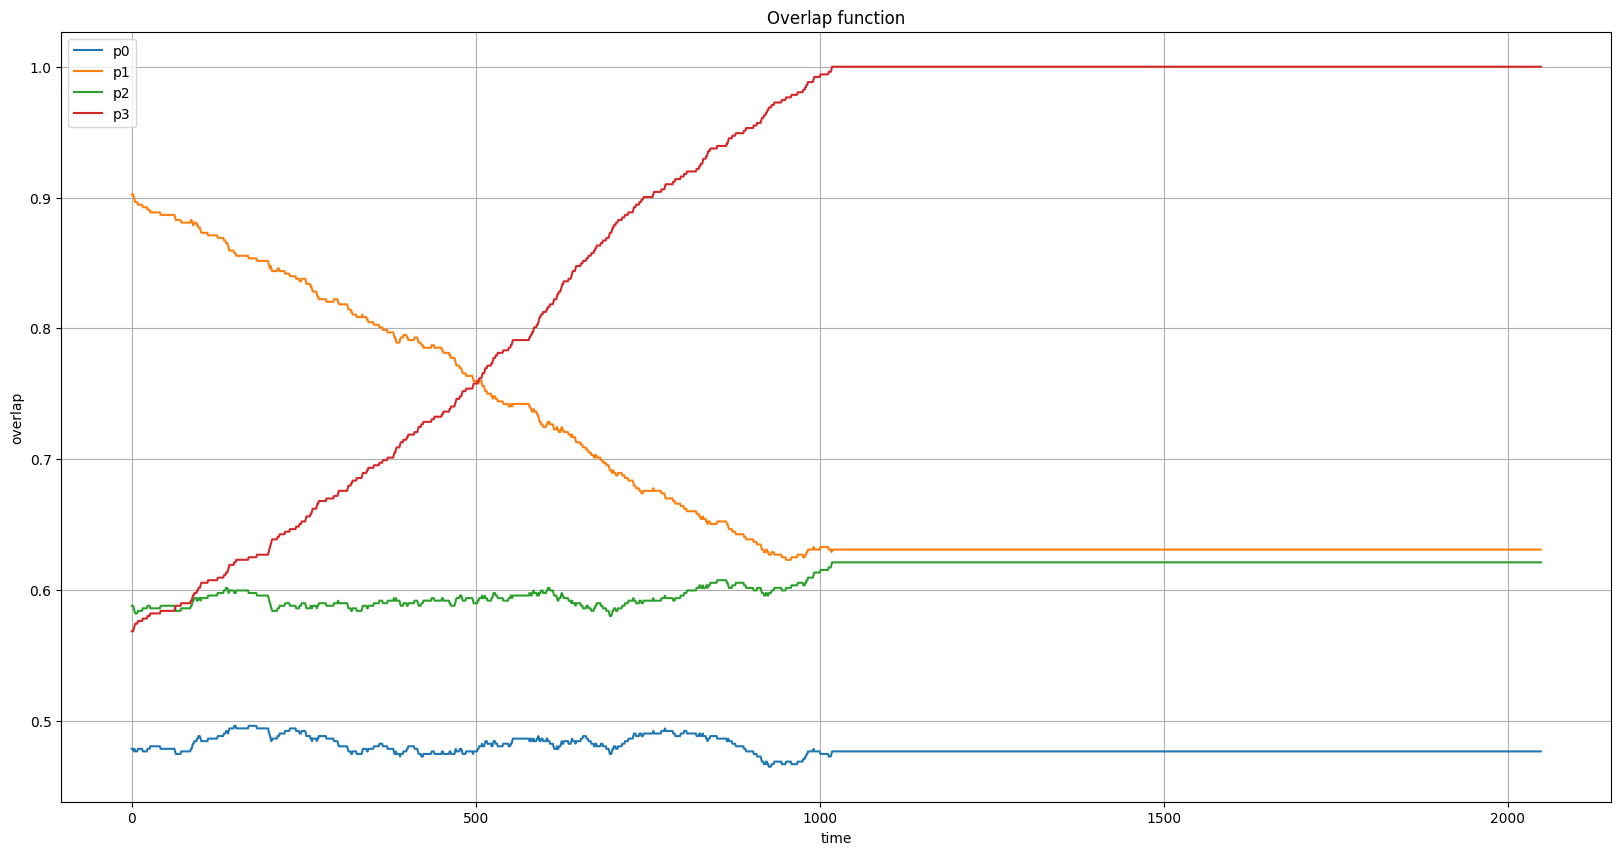

Overlap or pattern 2


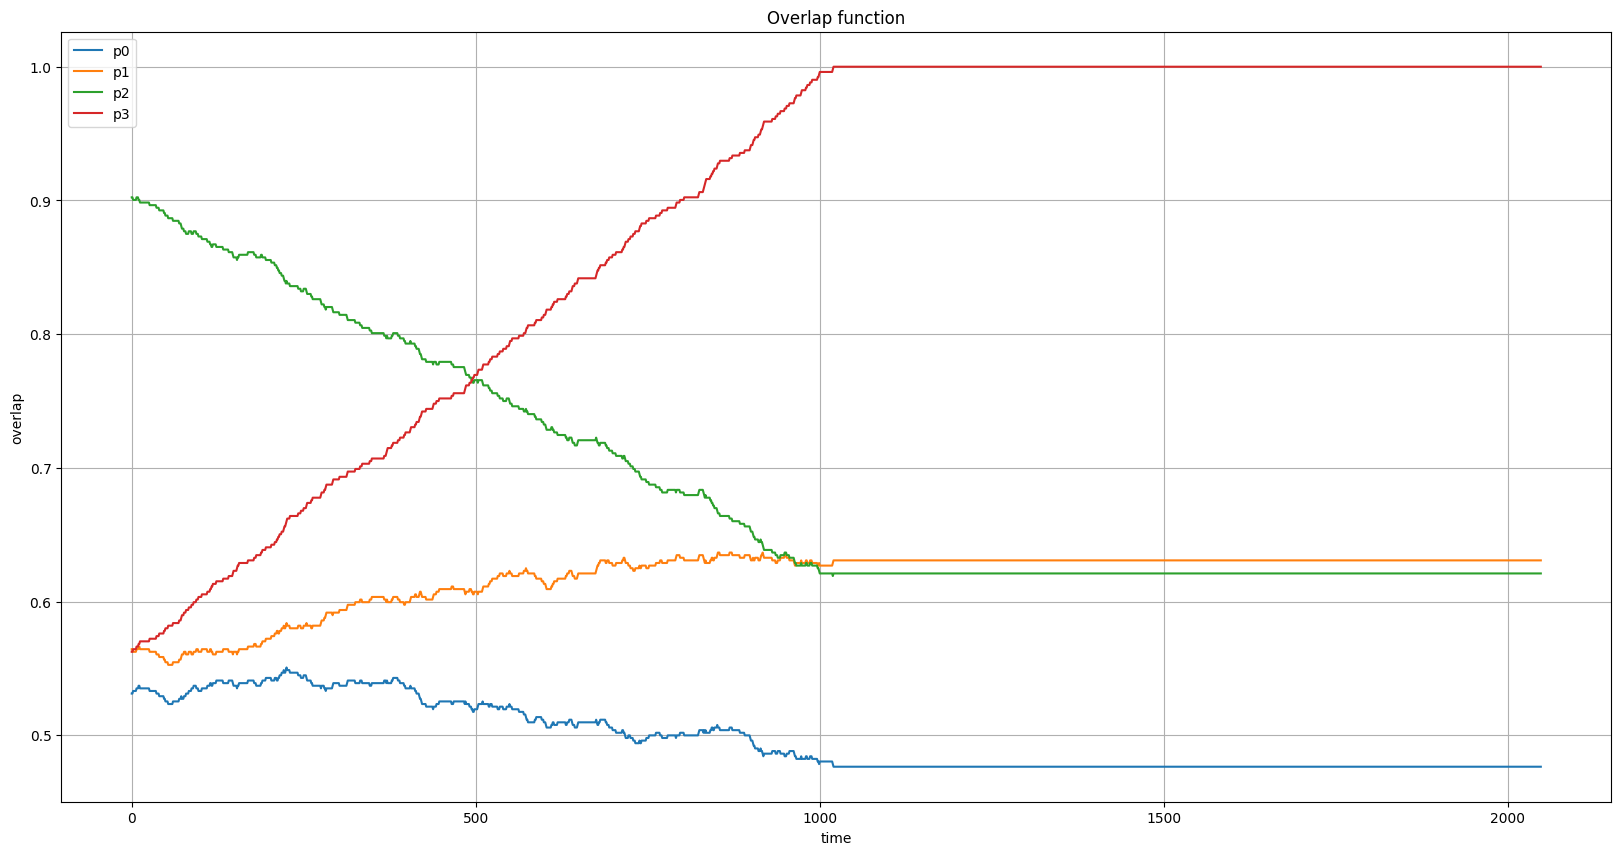

Overlap or pattern 3


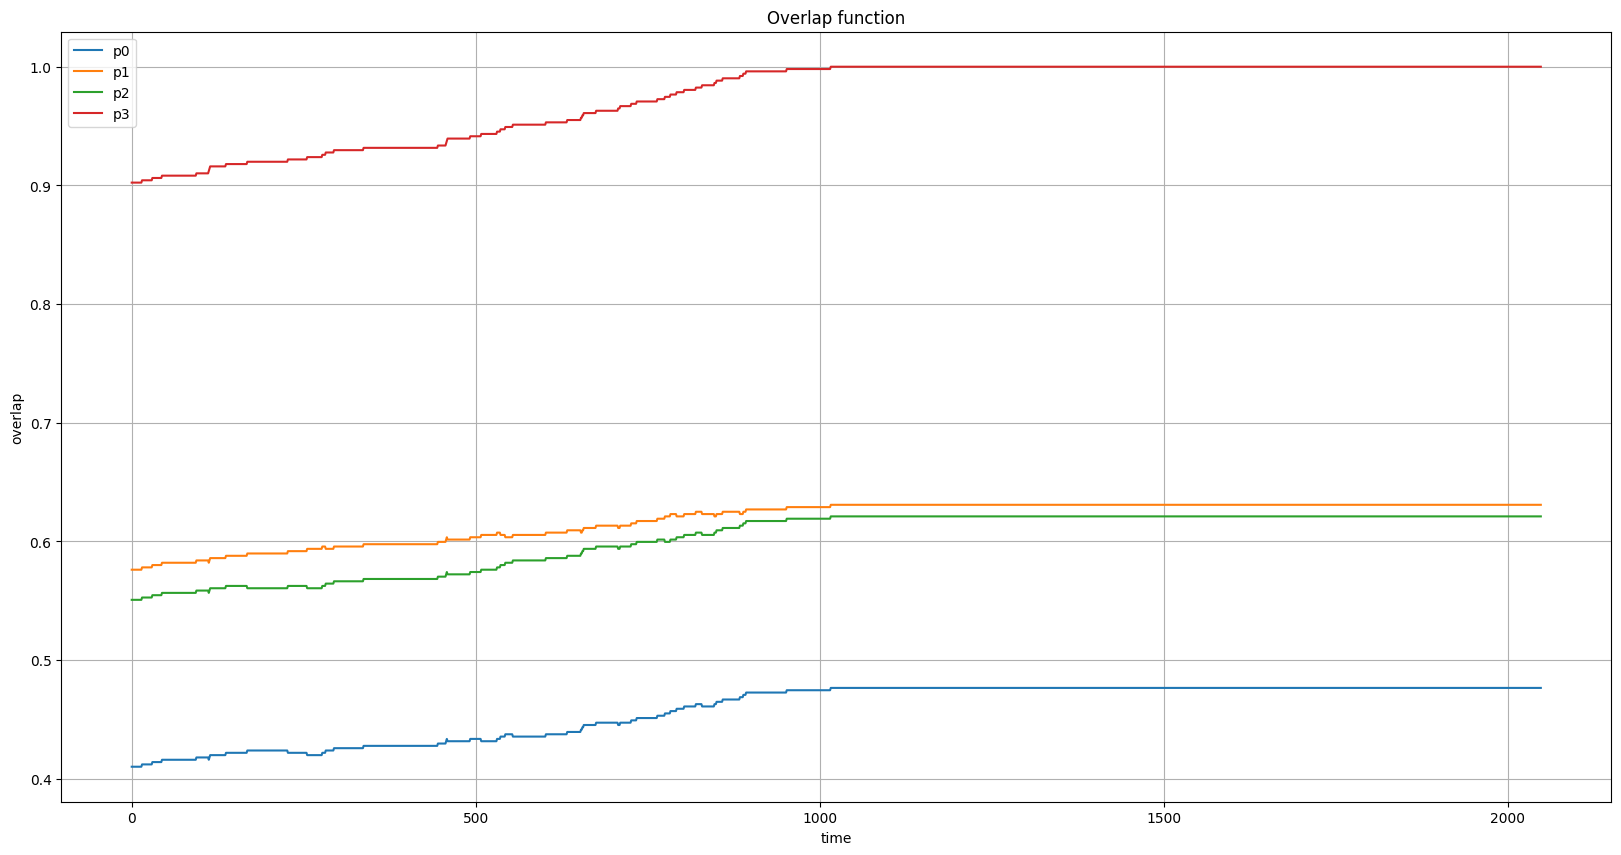

Network storing patterns until 4
Overlap or pattern 0


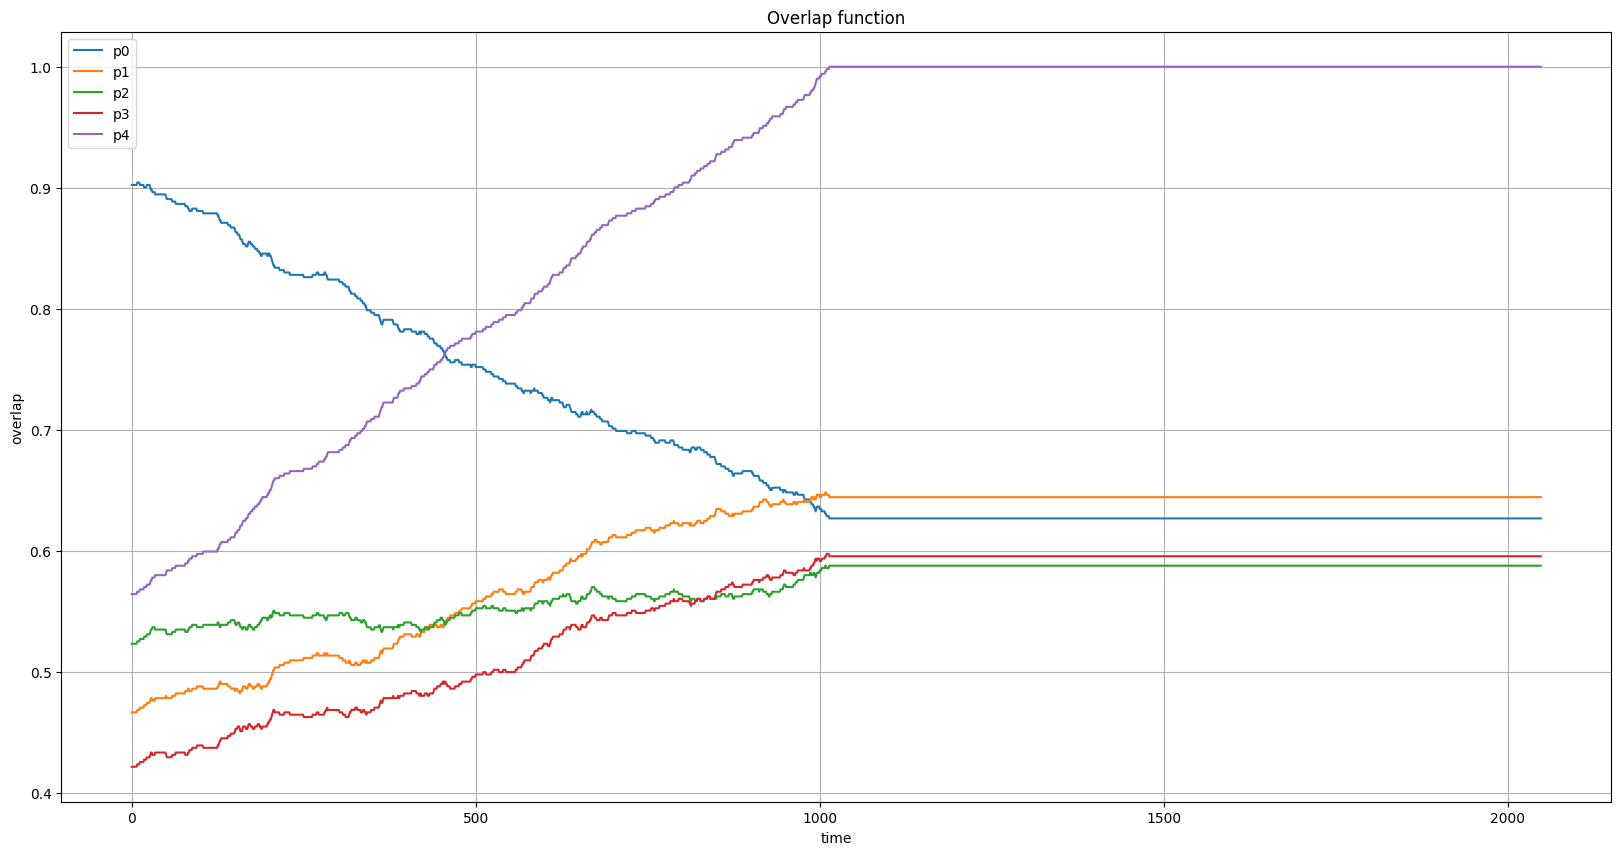

Overlap or pattern 1


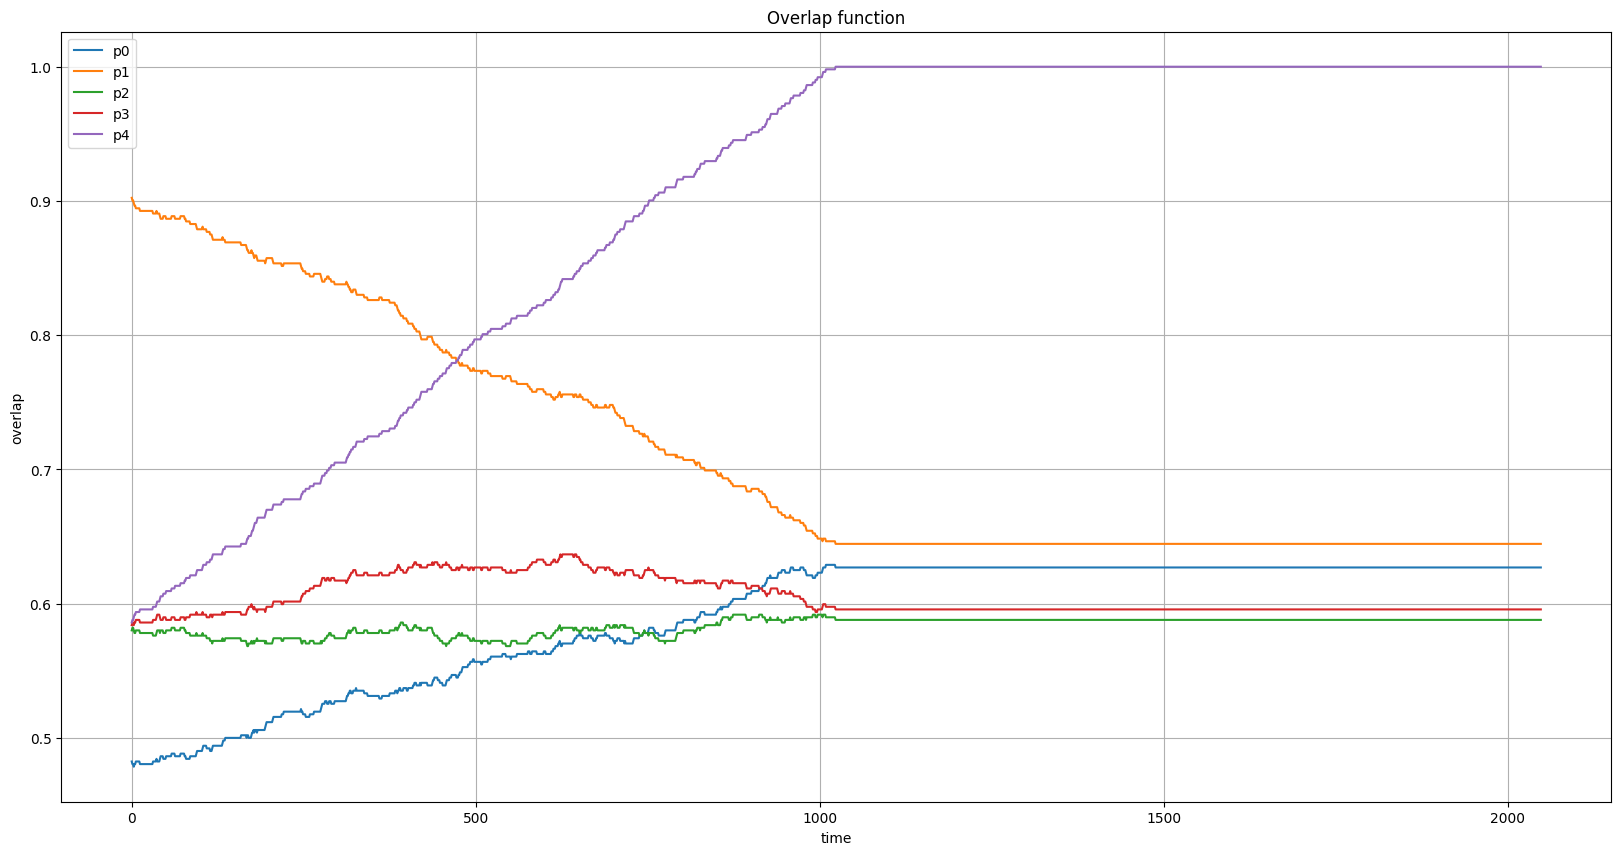

Overlap or pattern 2


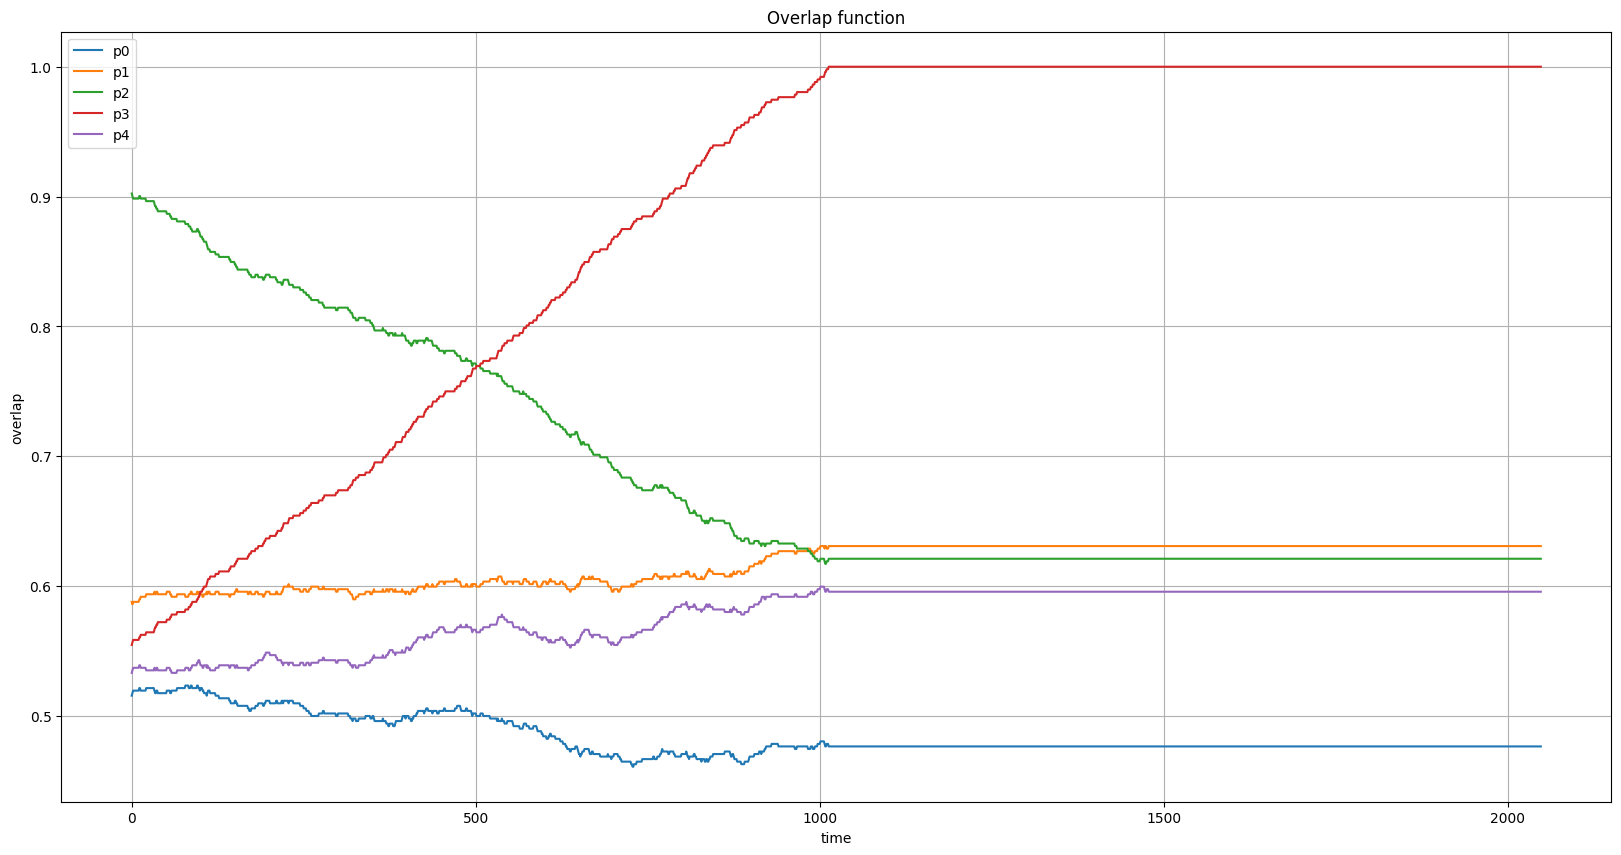

Overlap or pattern 3


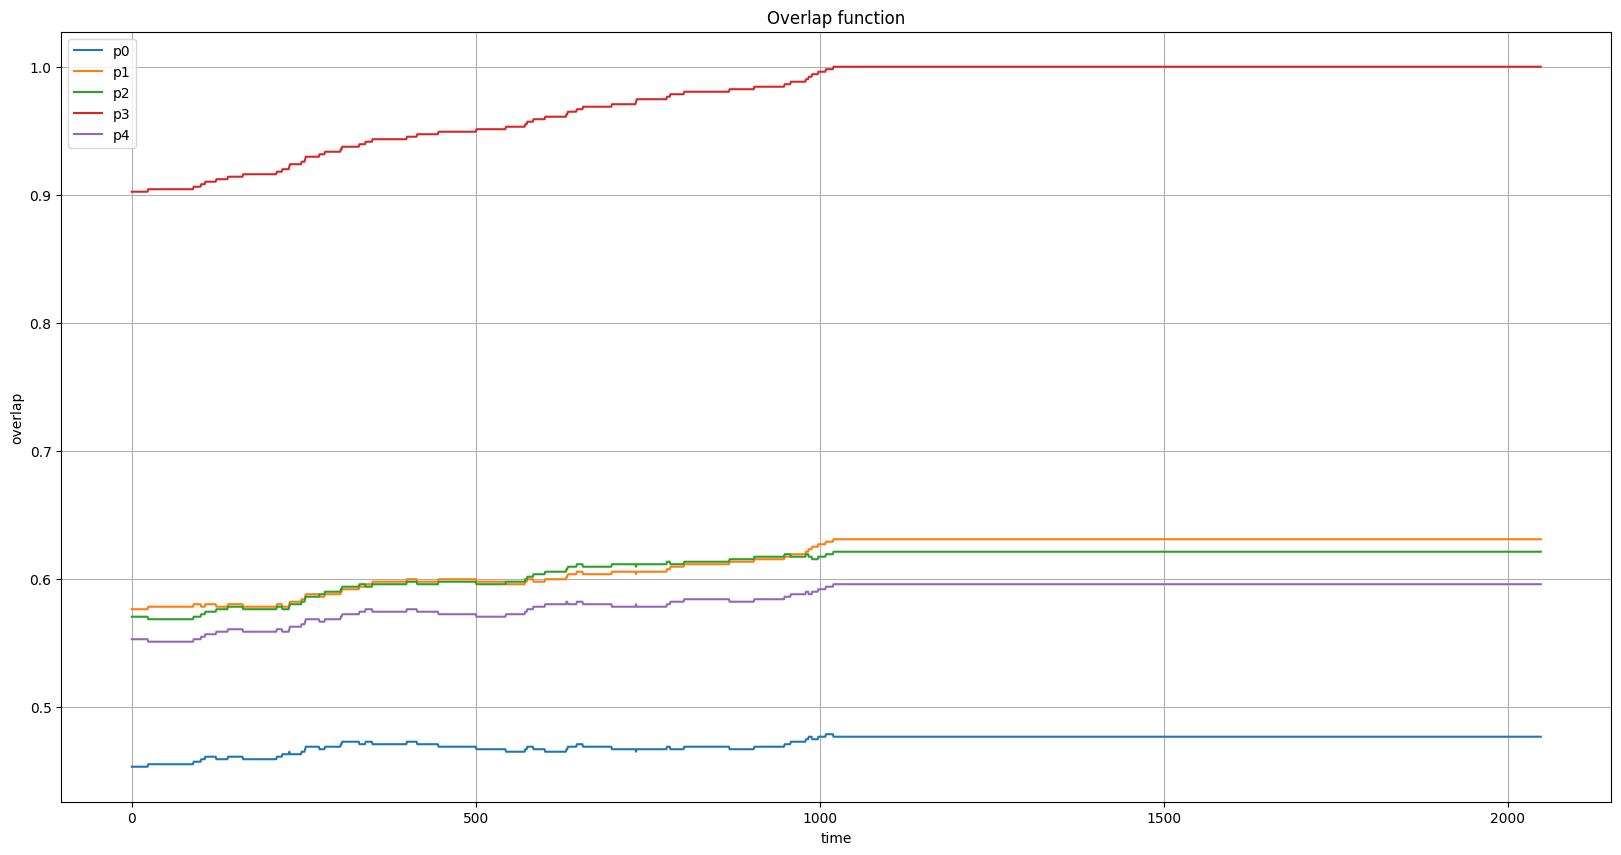

Overlap or pattern 4


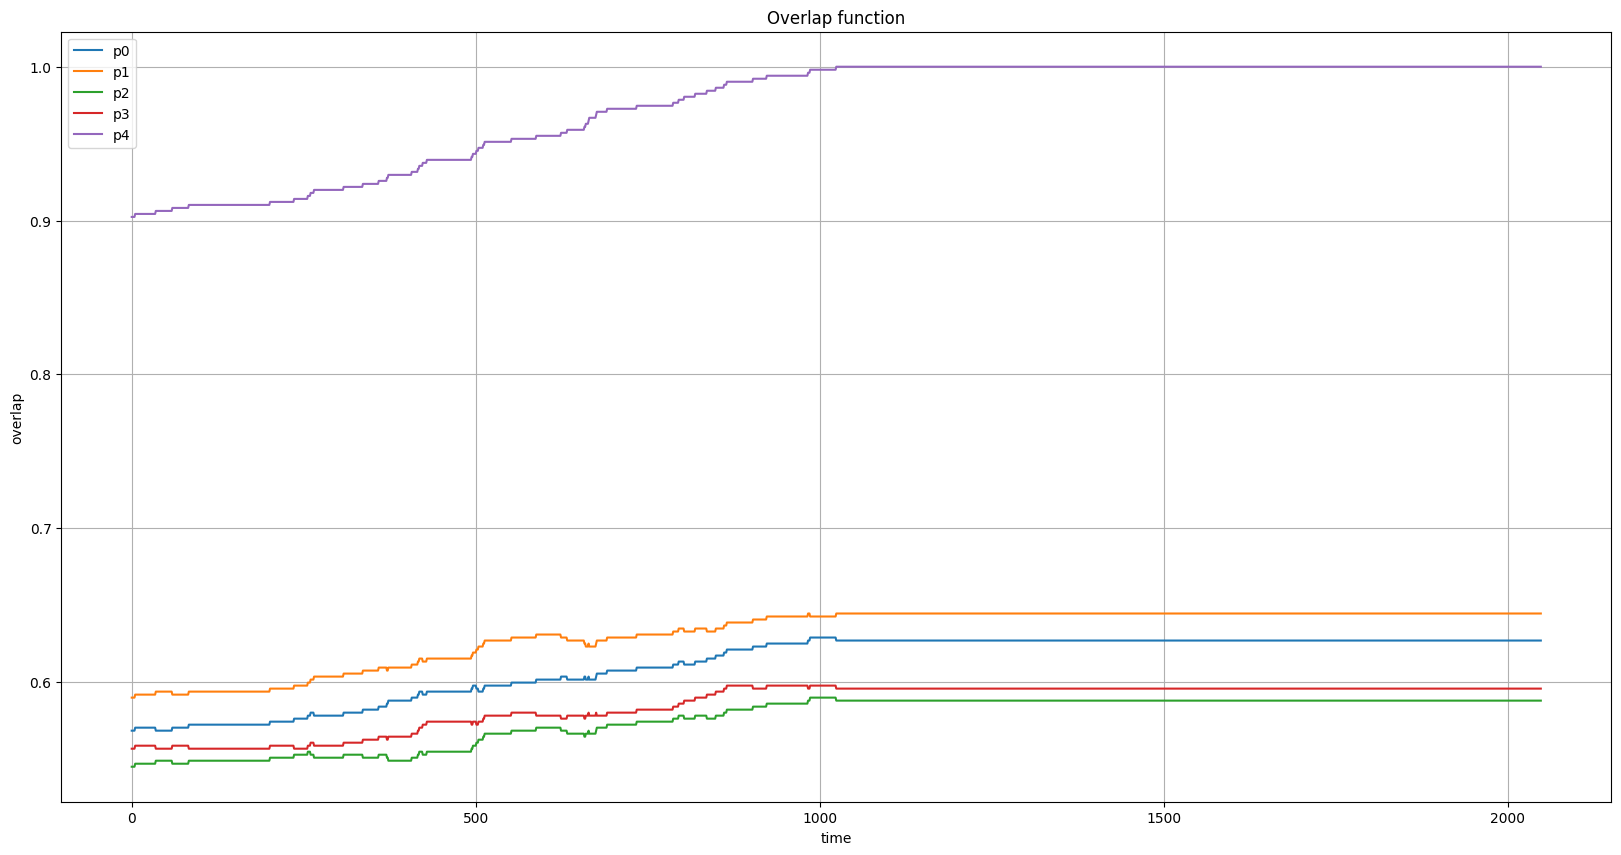

Network storing patterns until 5
Overlap or pattern 0


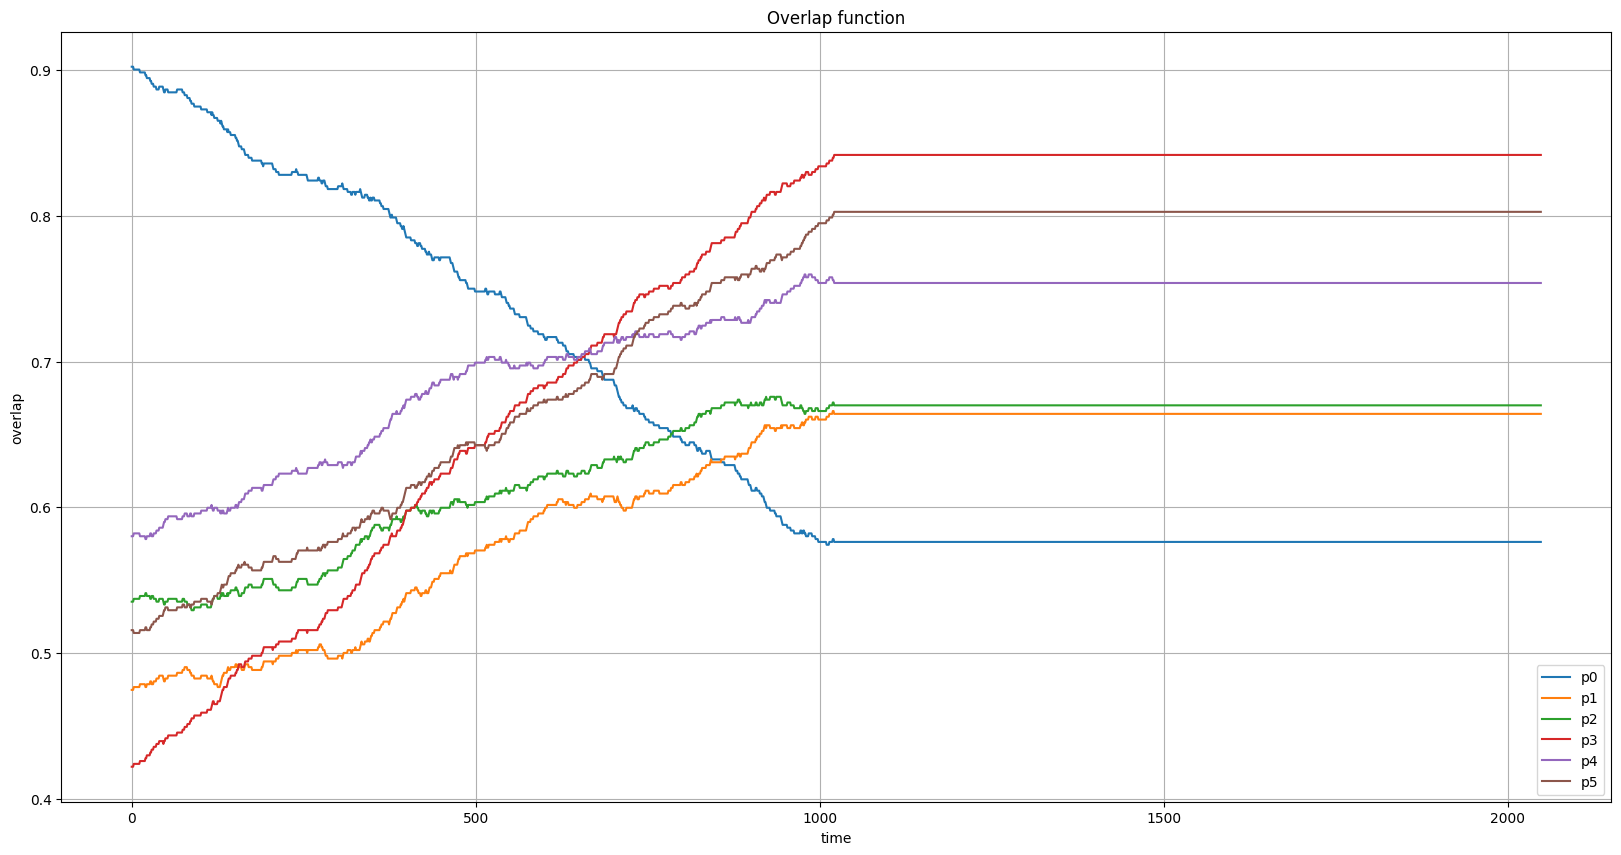

Overlap or pattern 1


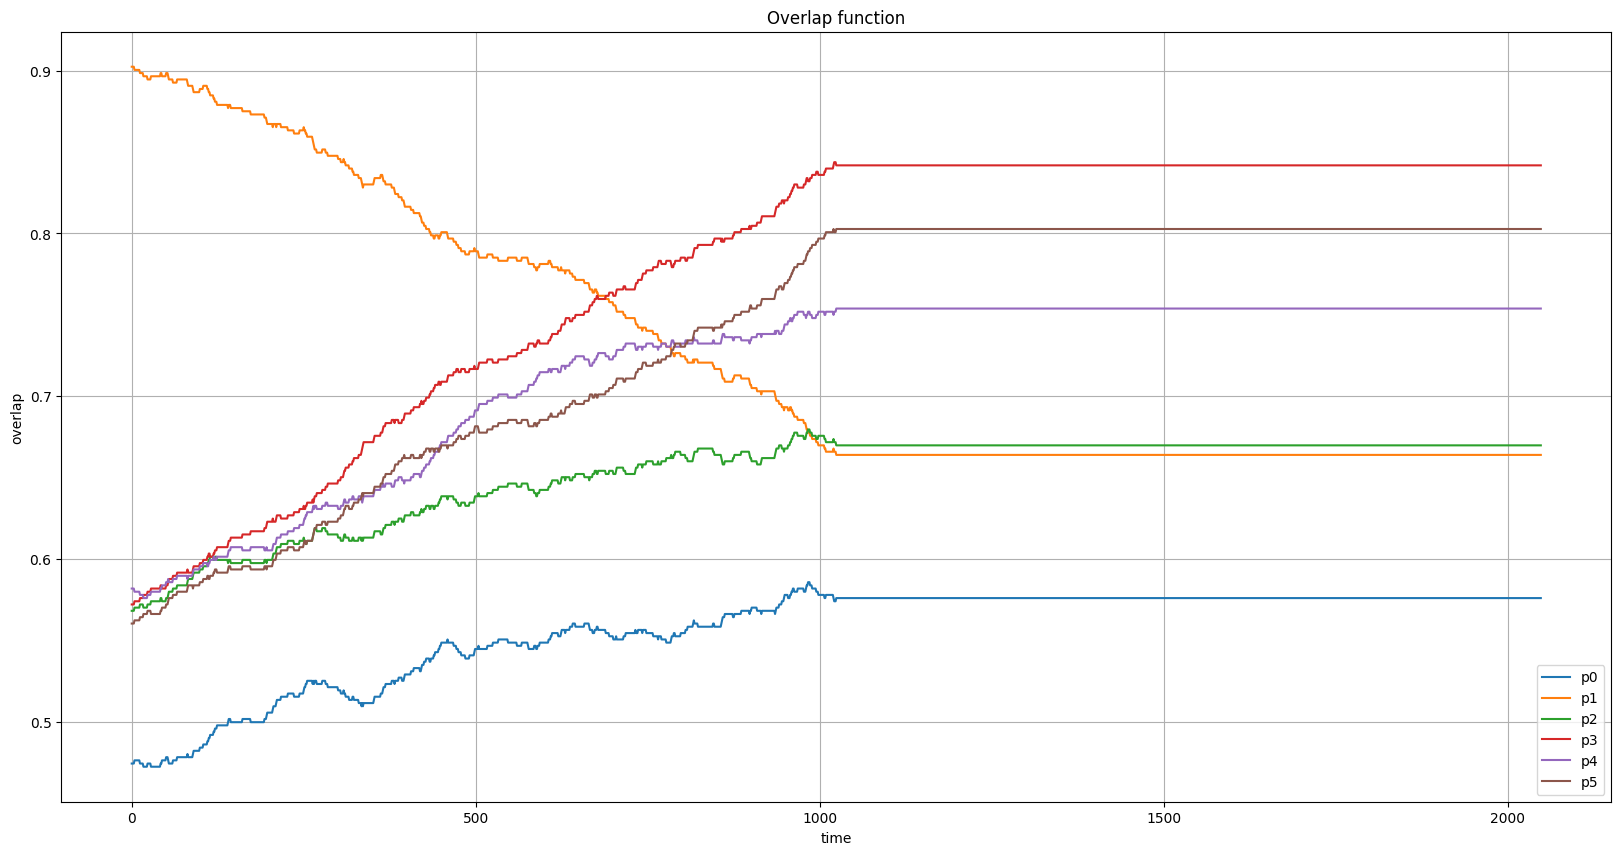

Overlap or pattern 2


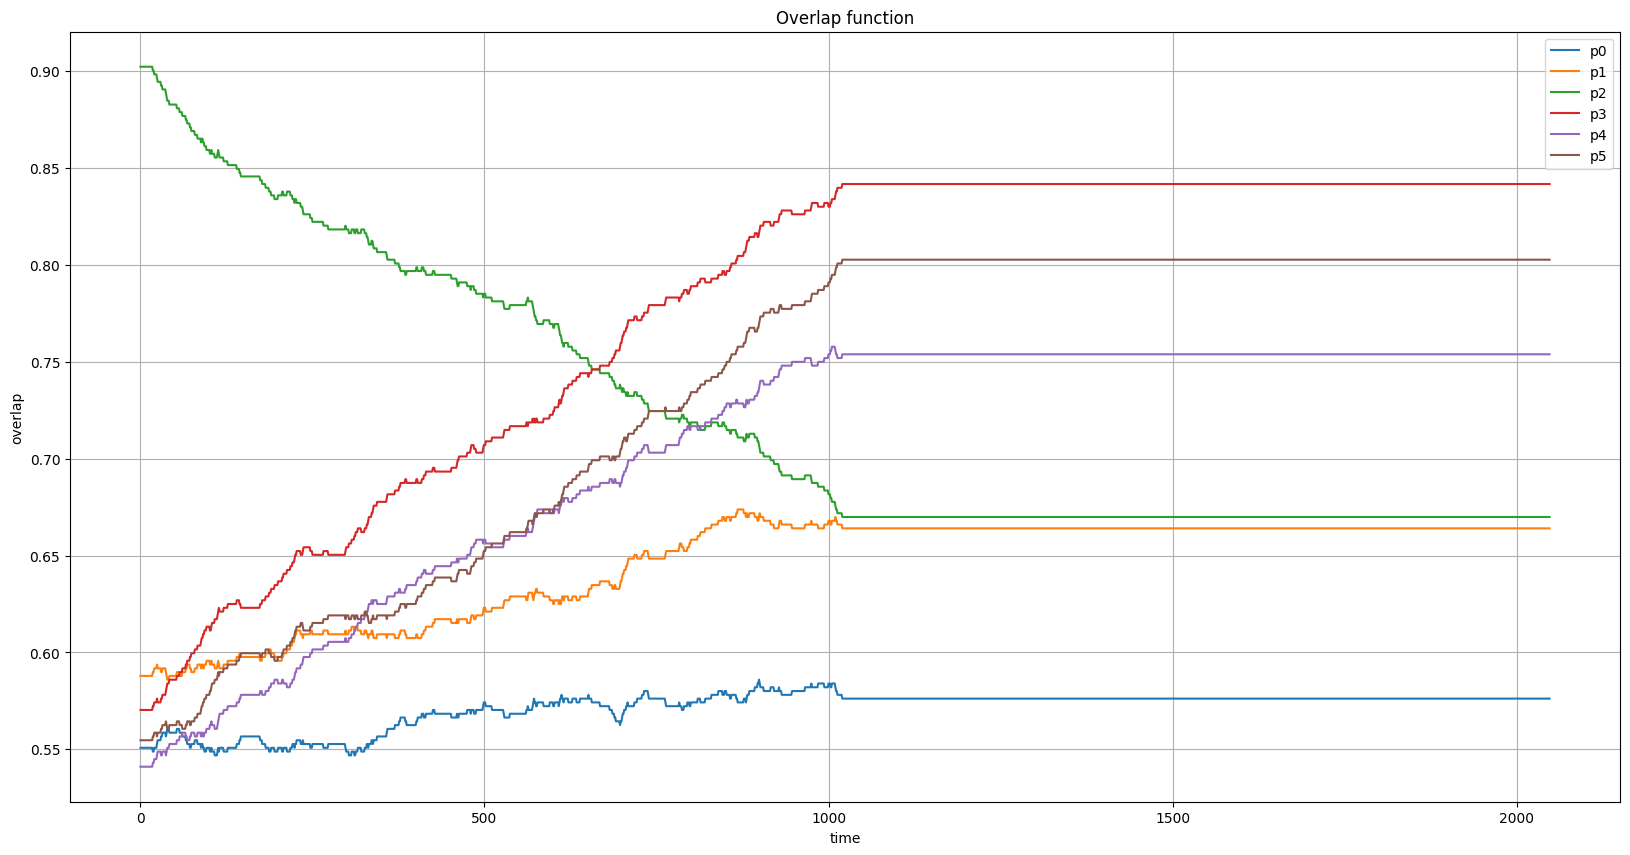

Overlap or pattern 3


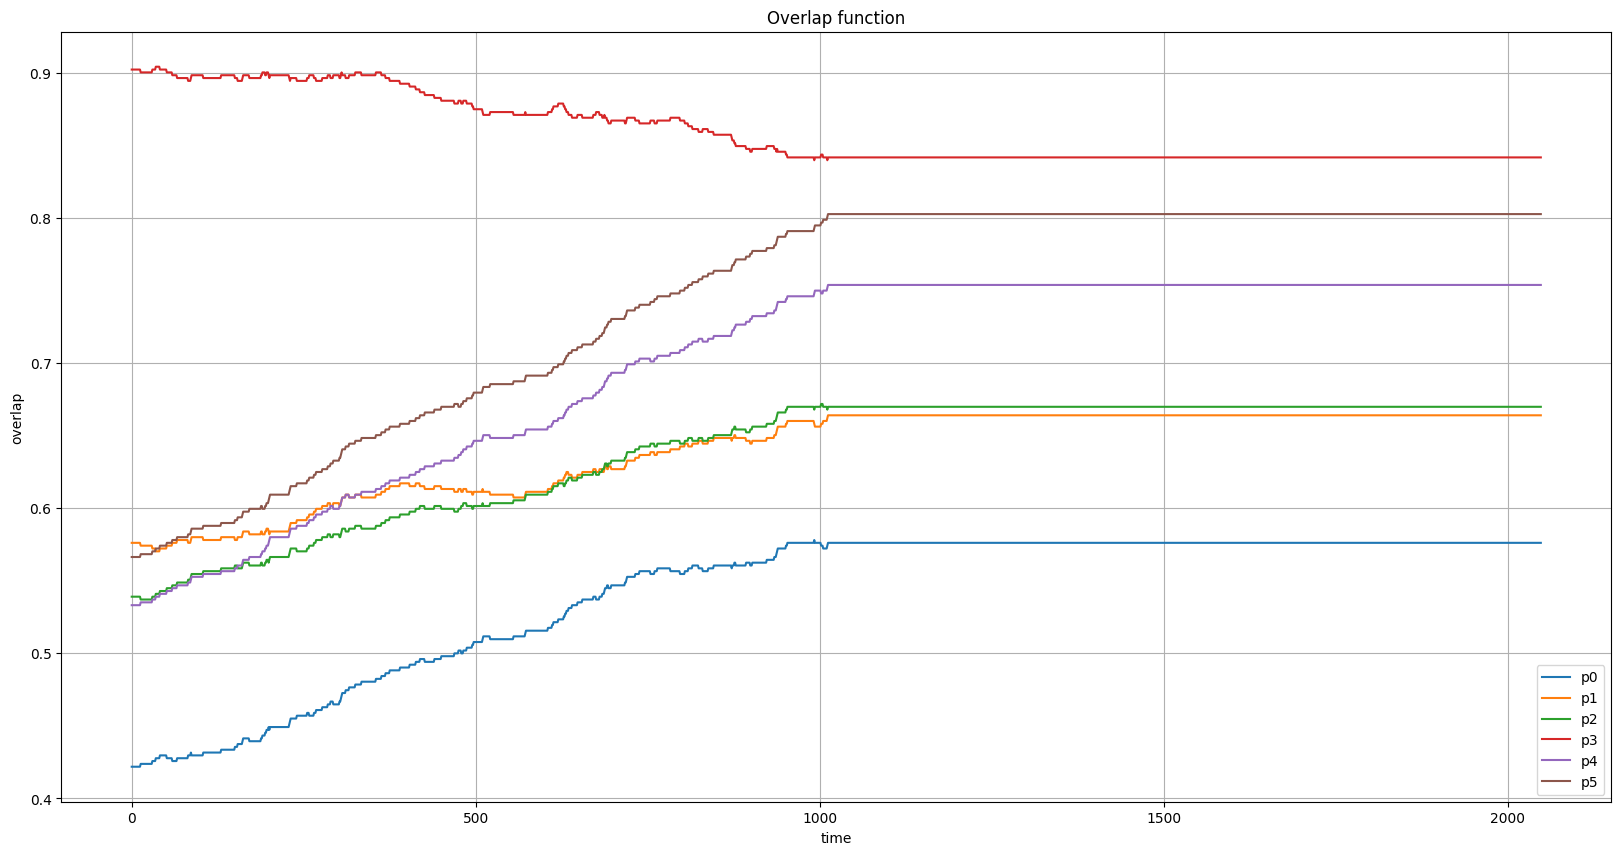

Overlap or pattern 4


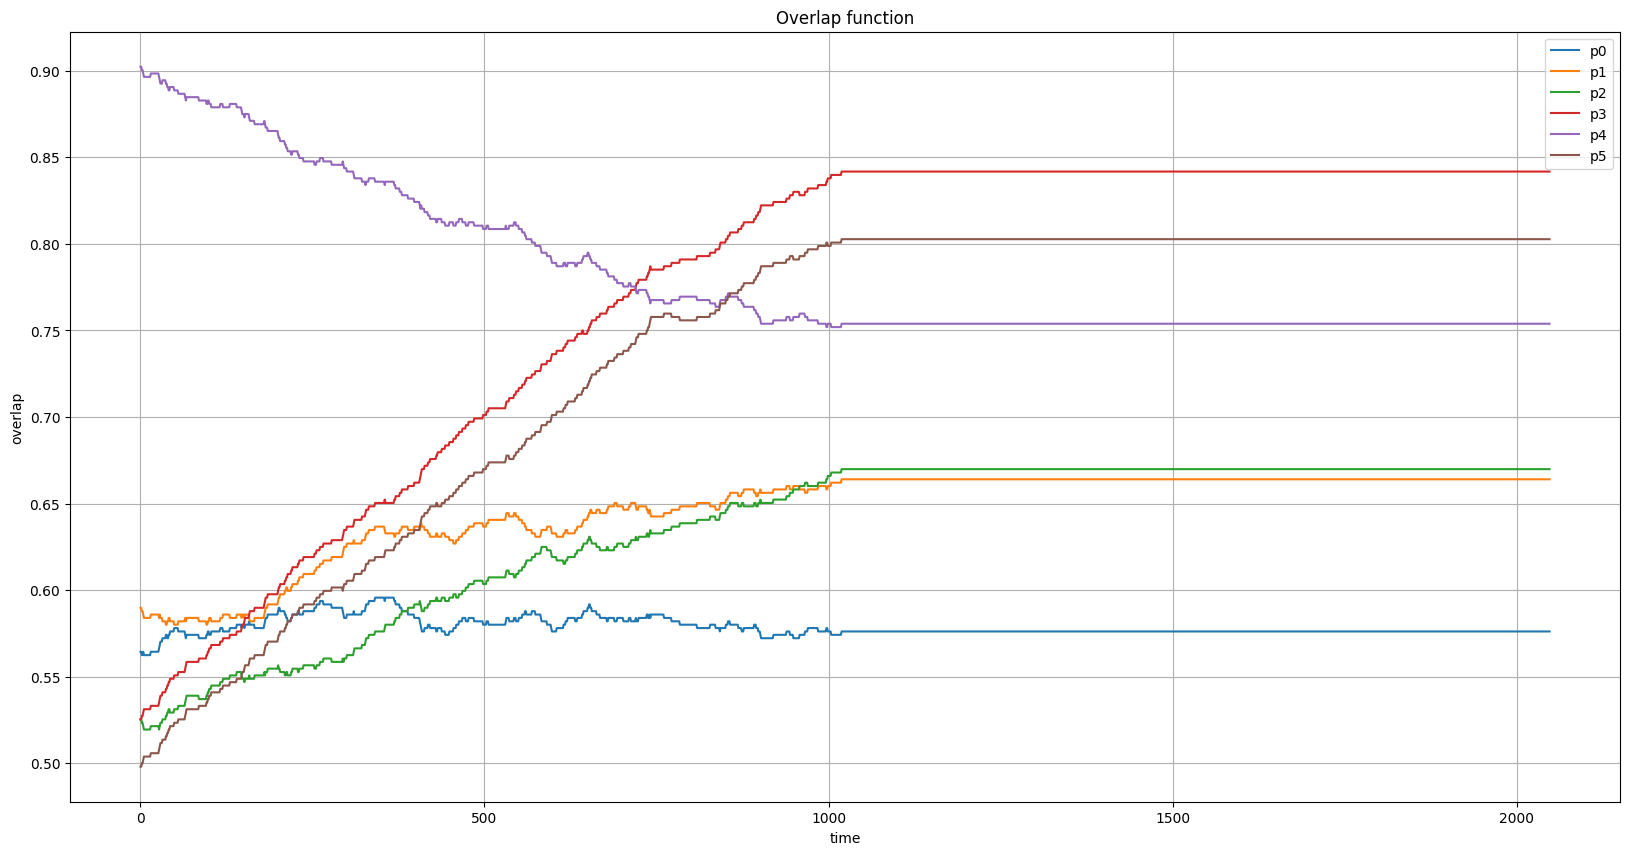

Overlap or pattern 5


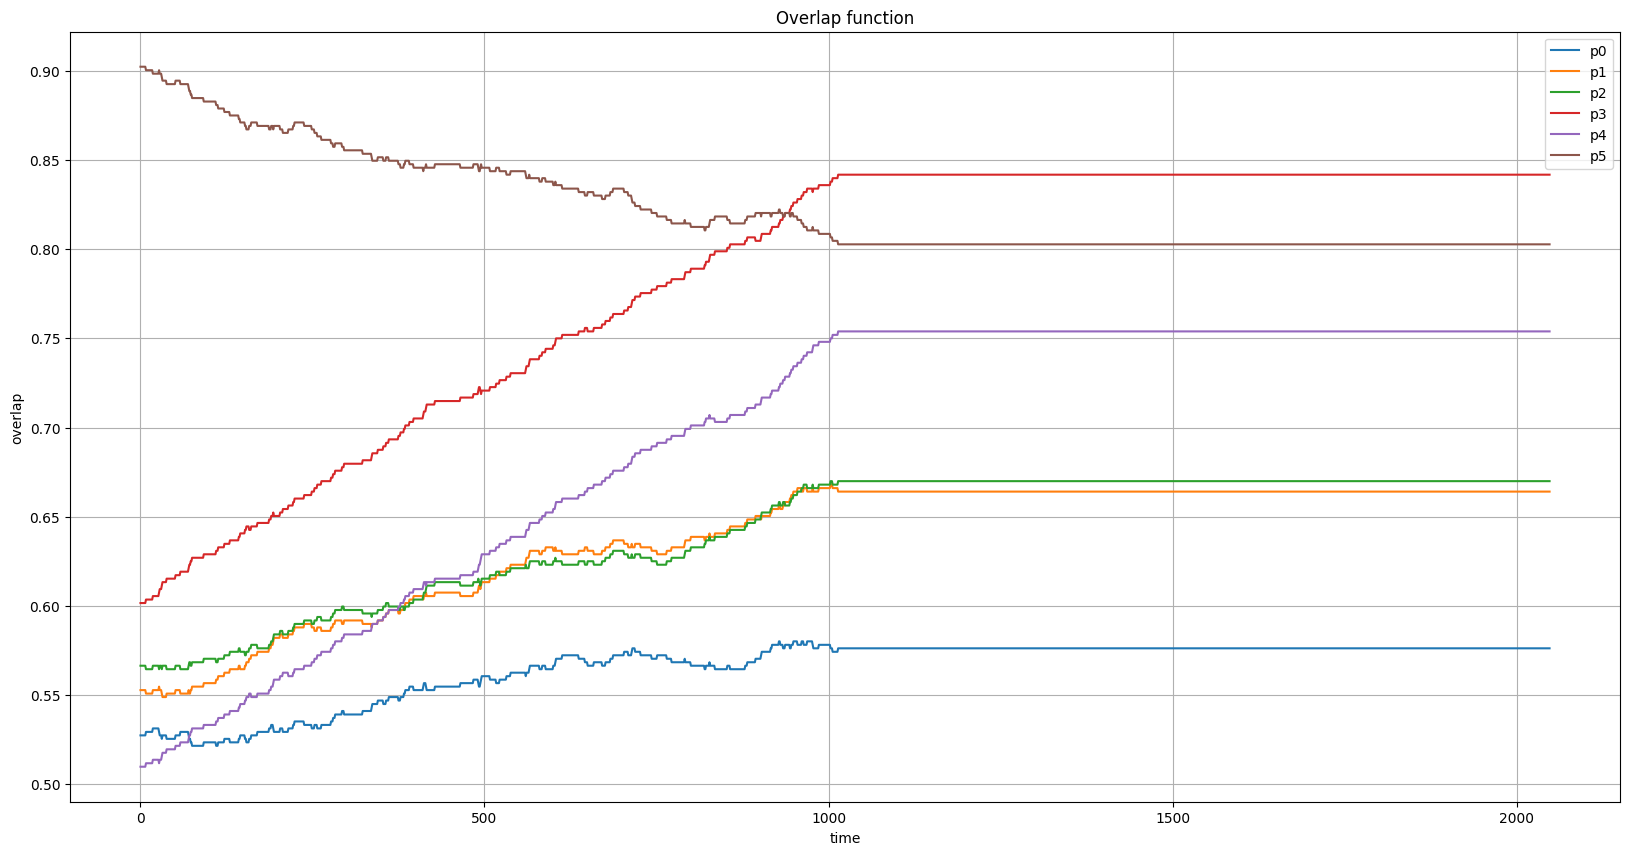

Network storing patterns until 6
Overlap or pattern 0


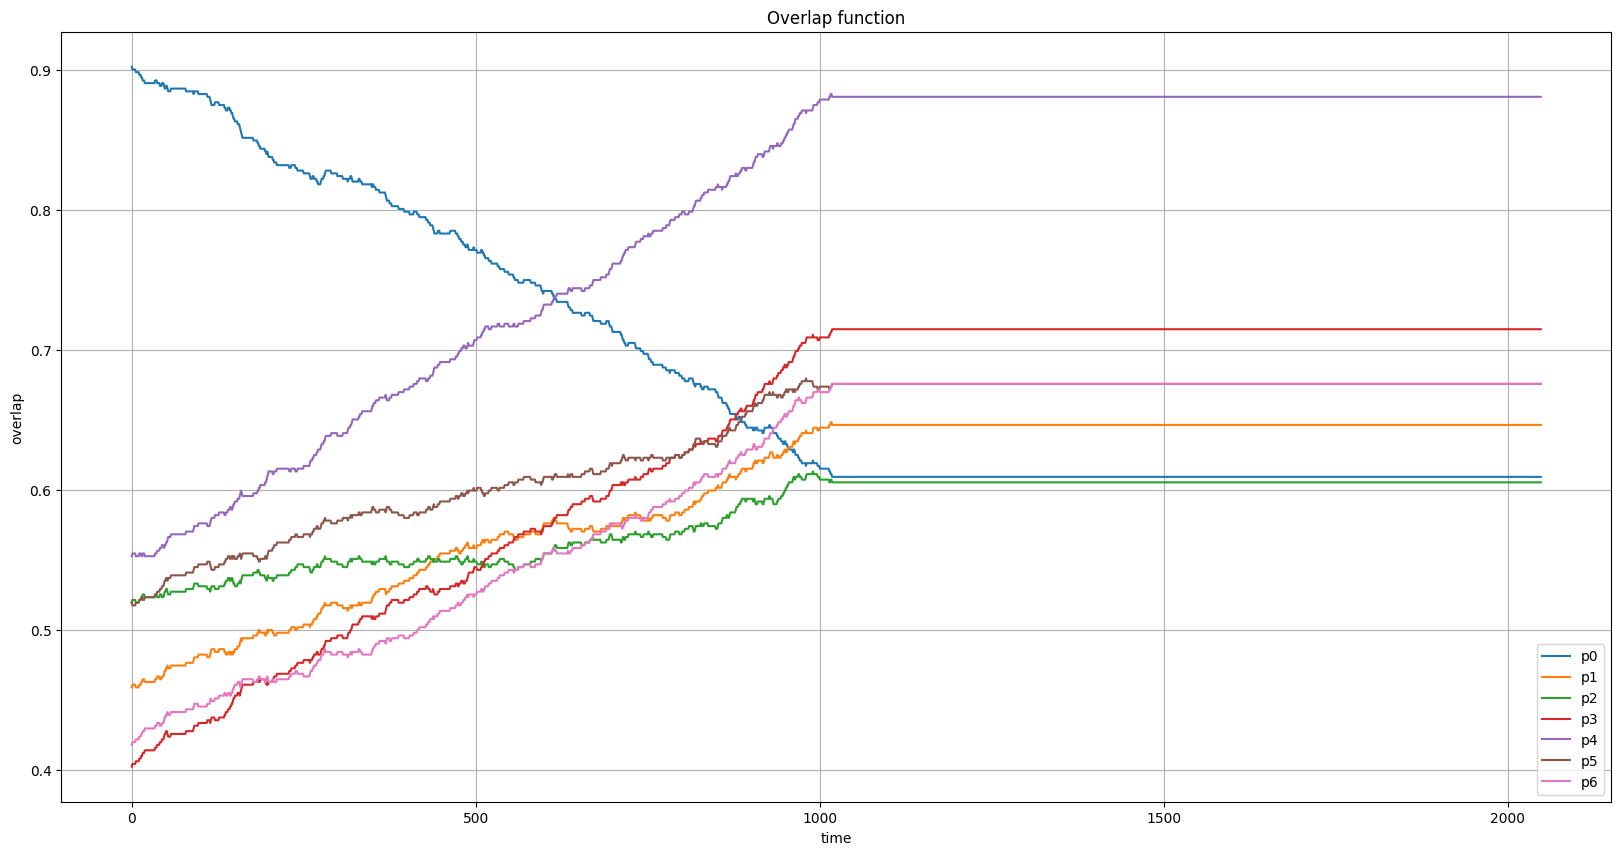

Overlap or pattern 1


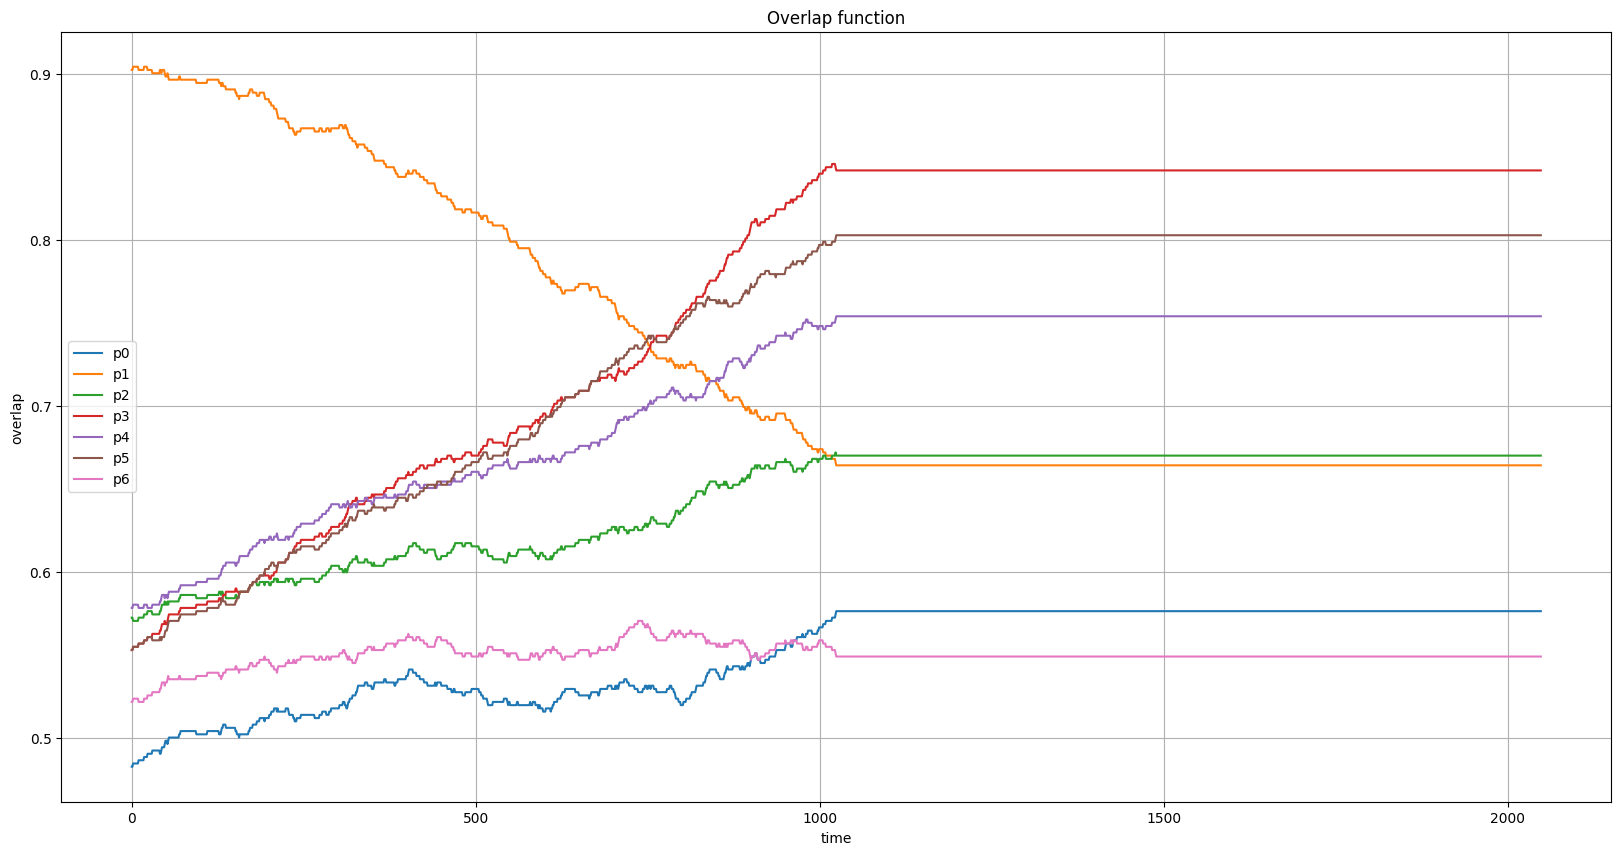

Overlap or pattern 2


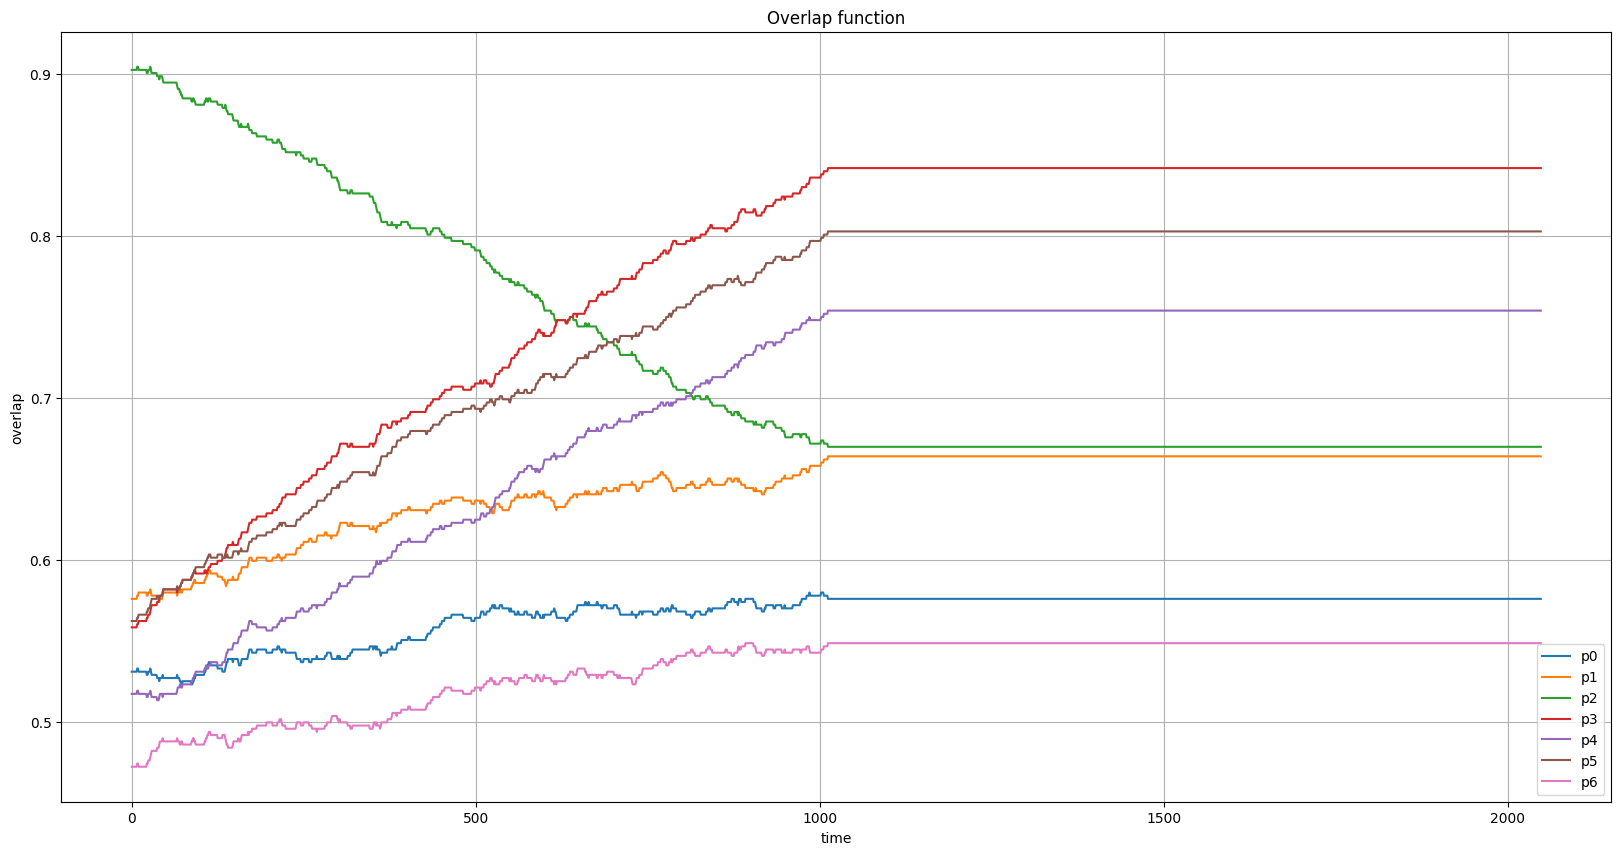

Overlap or pattern 3


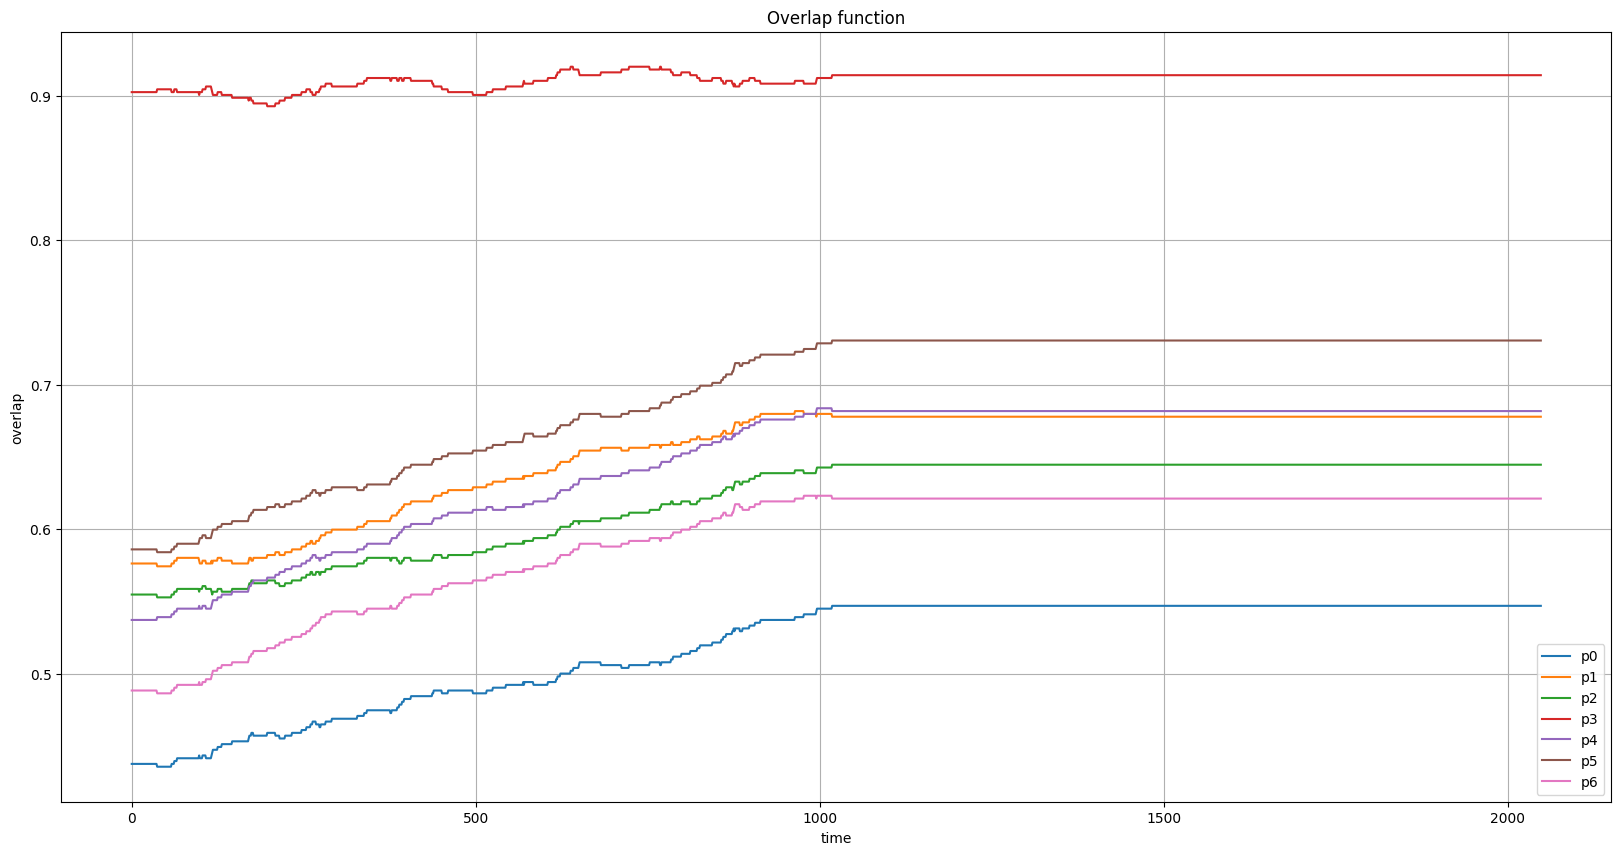

Overlap or pattern 4


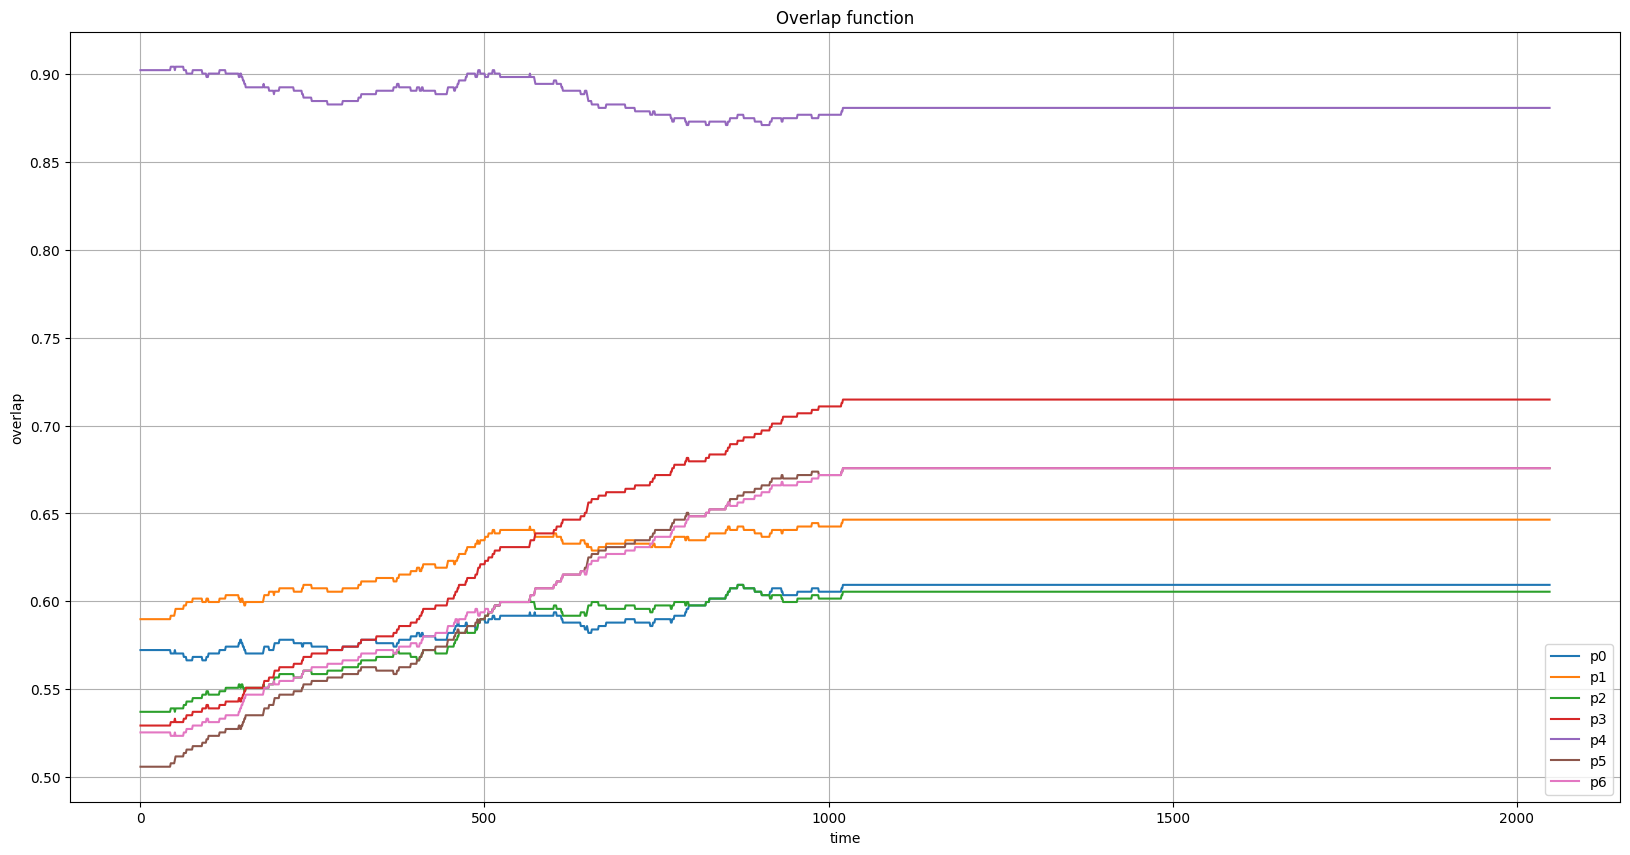

Overlap or pattern 5


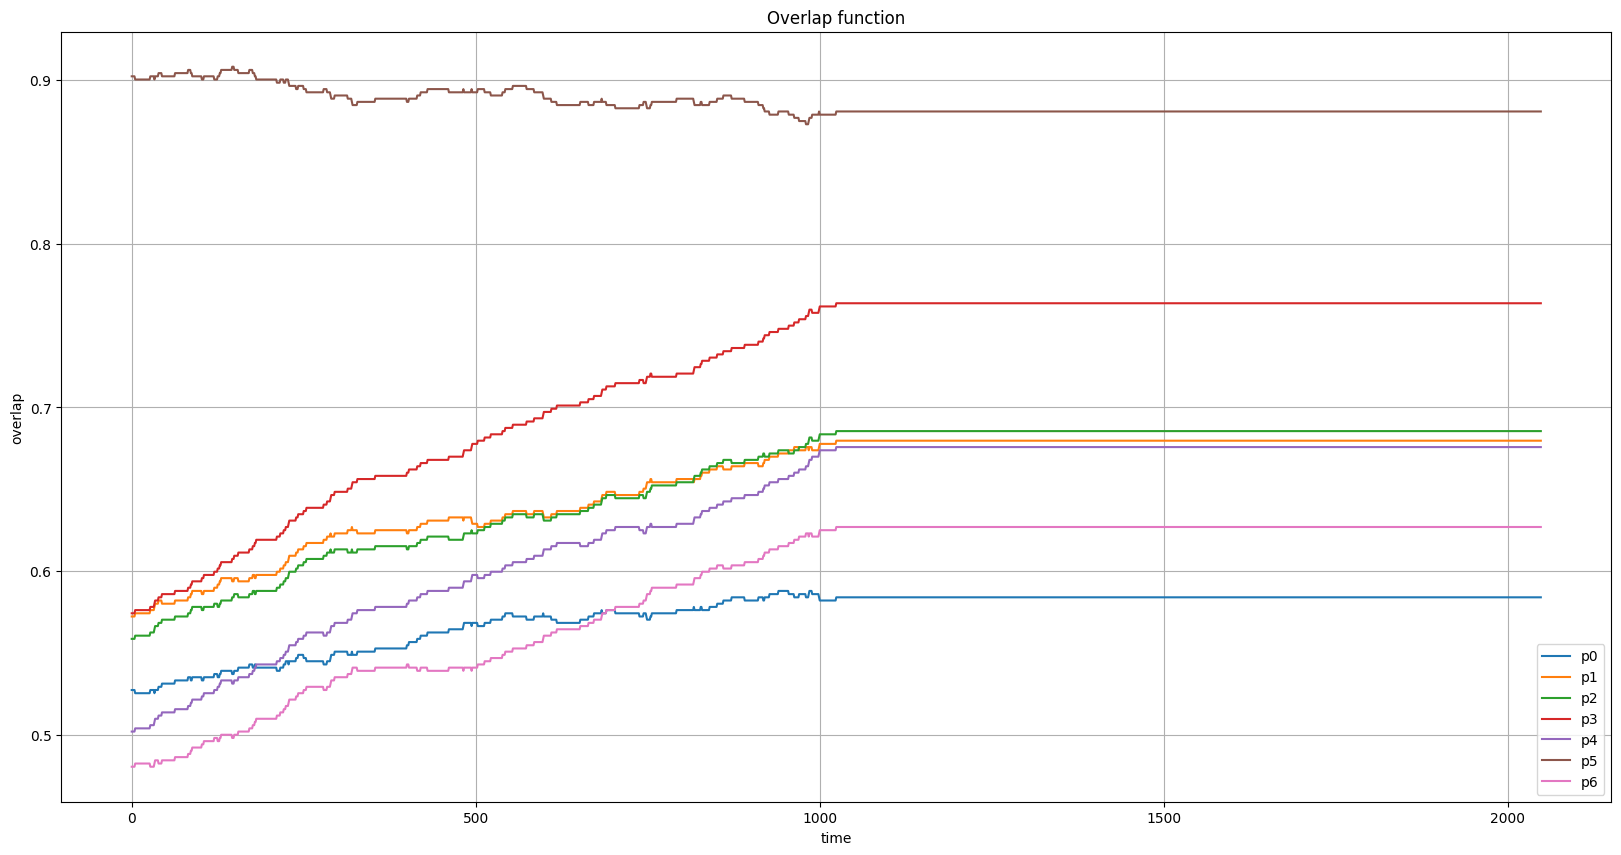

Overlap or pattern 6


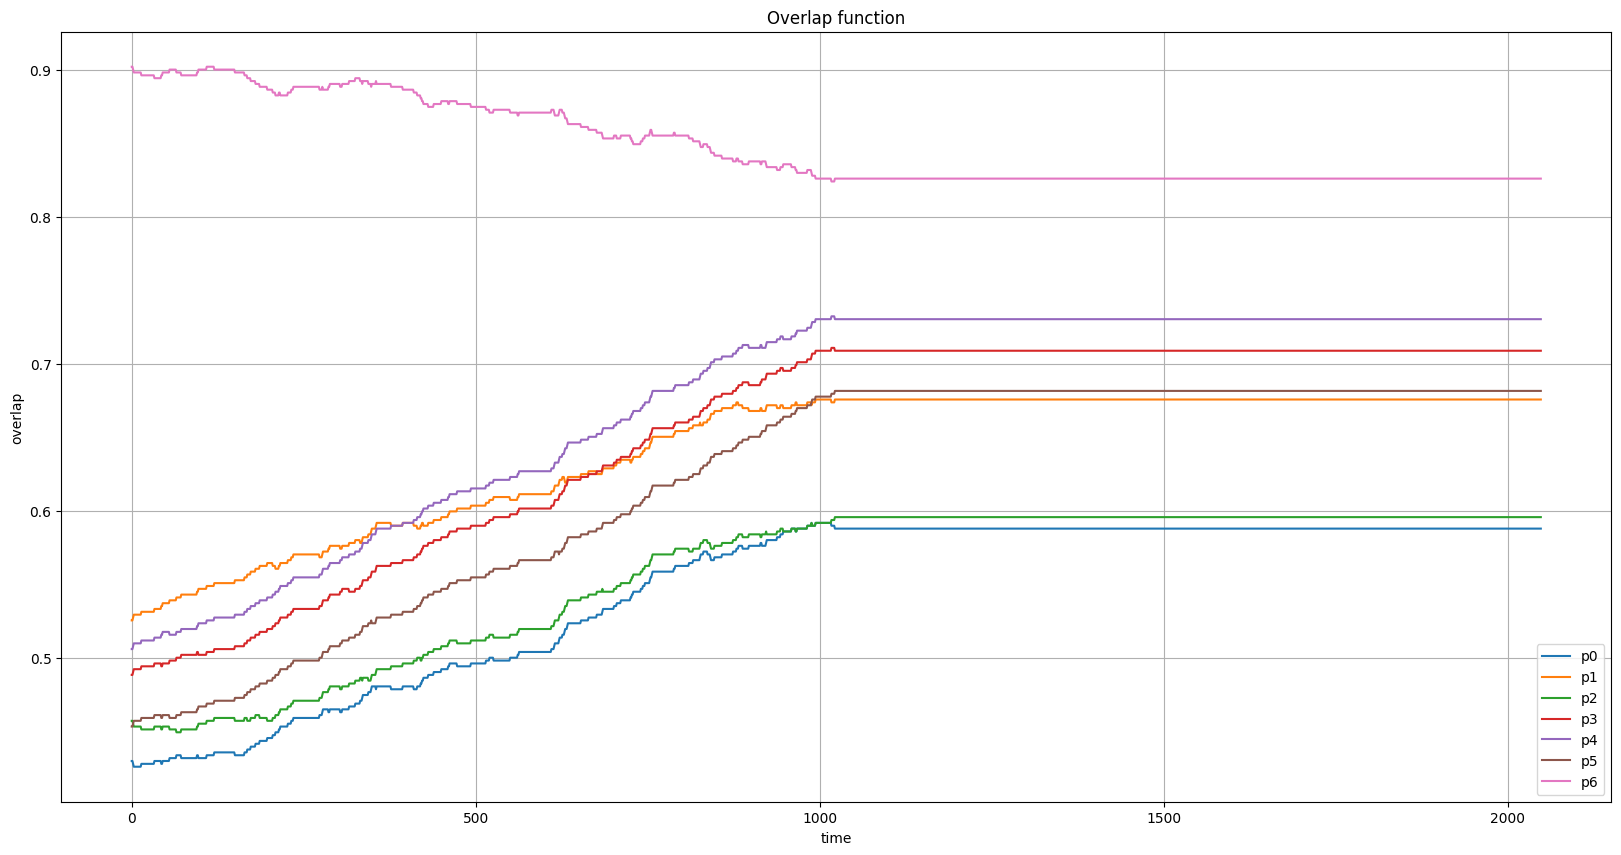

Network storing patterns until 7
Overlap or pattern 0


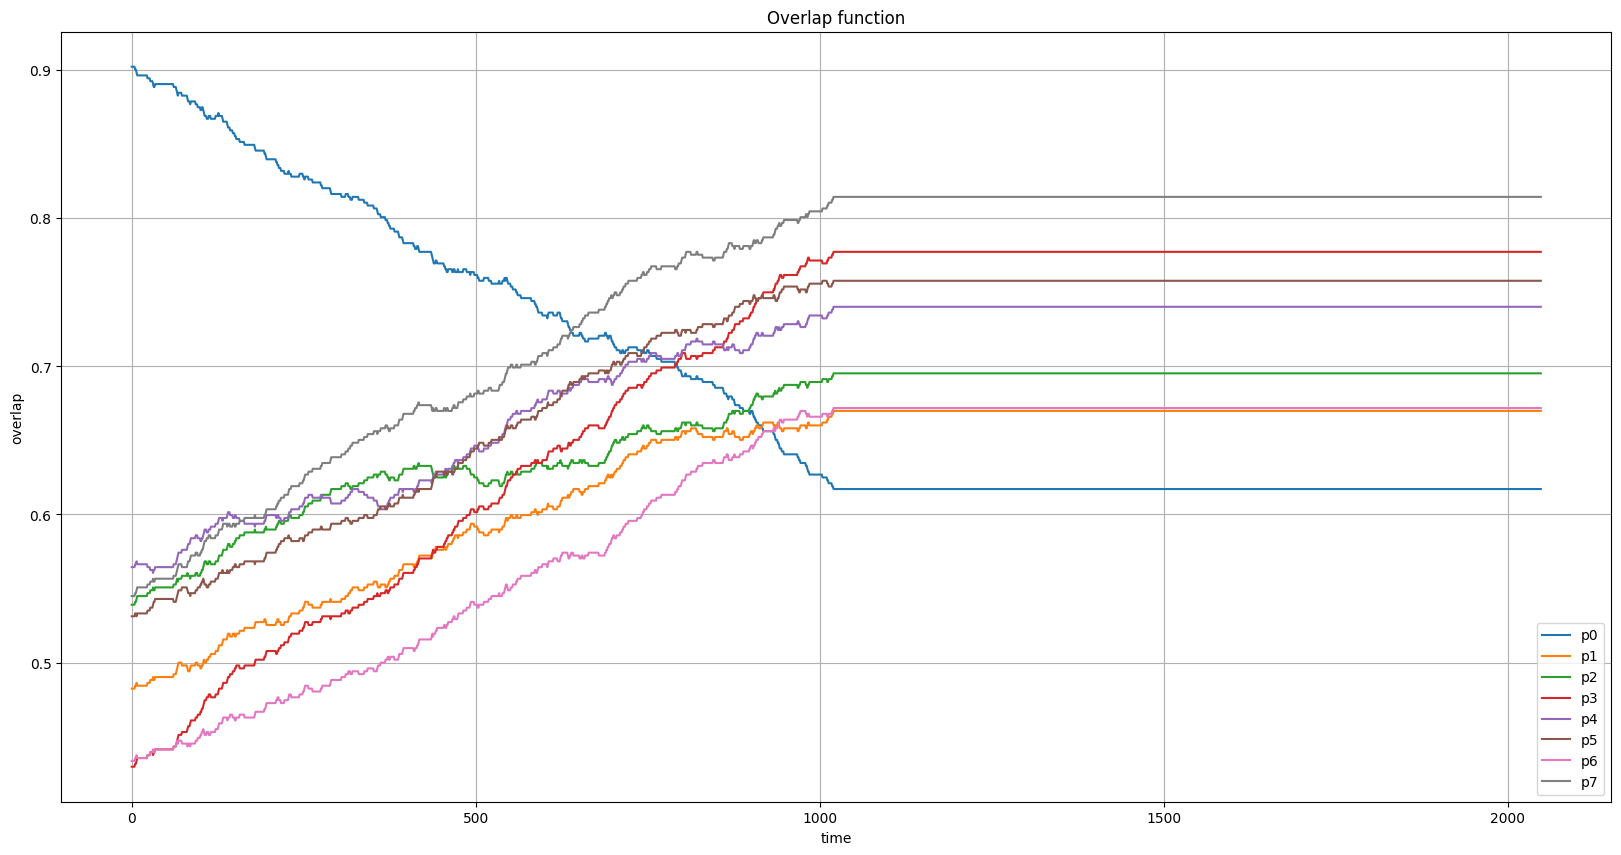

Overlap or pattern 1


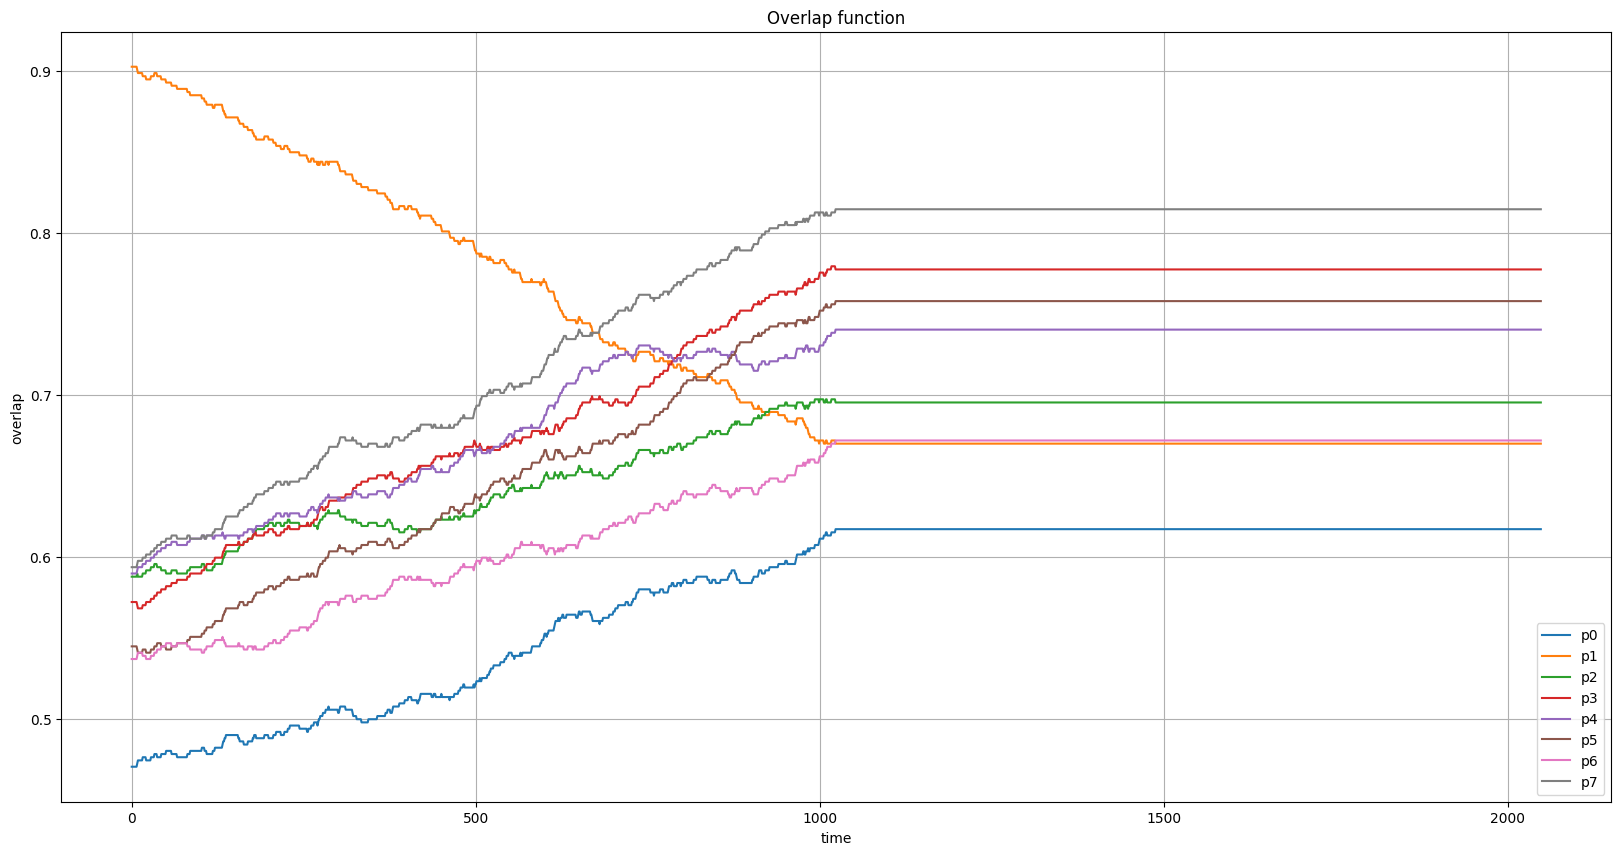

Overlap or pattern 2


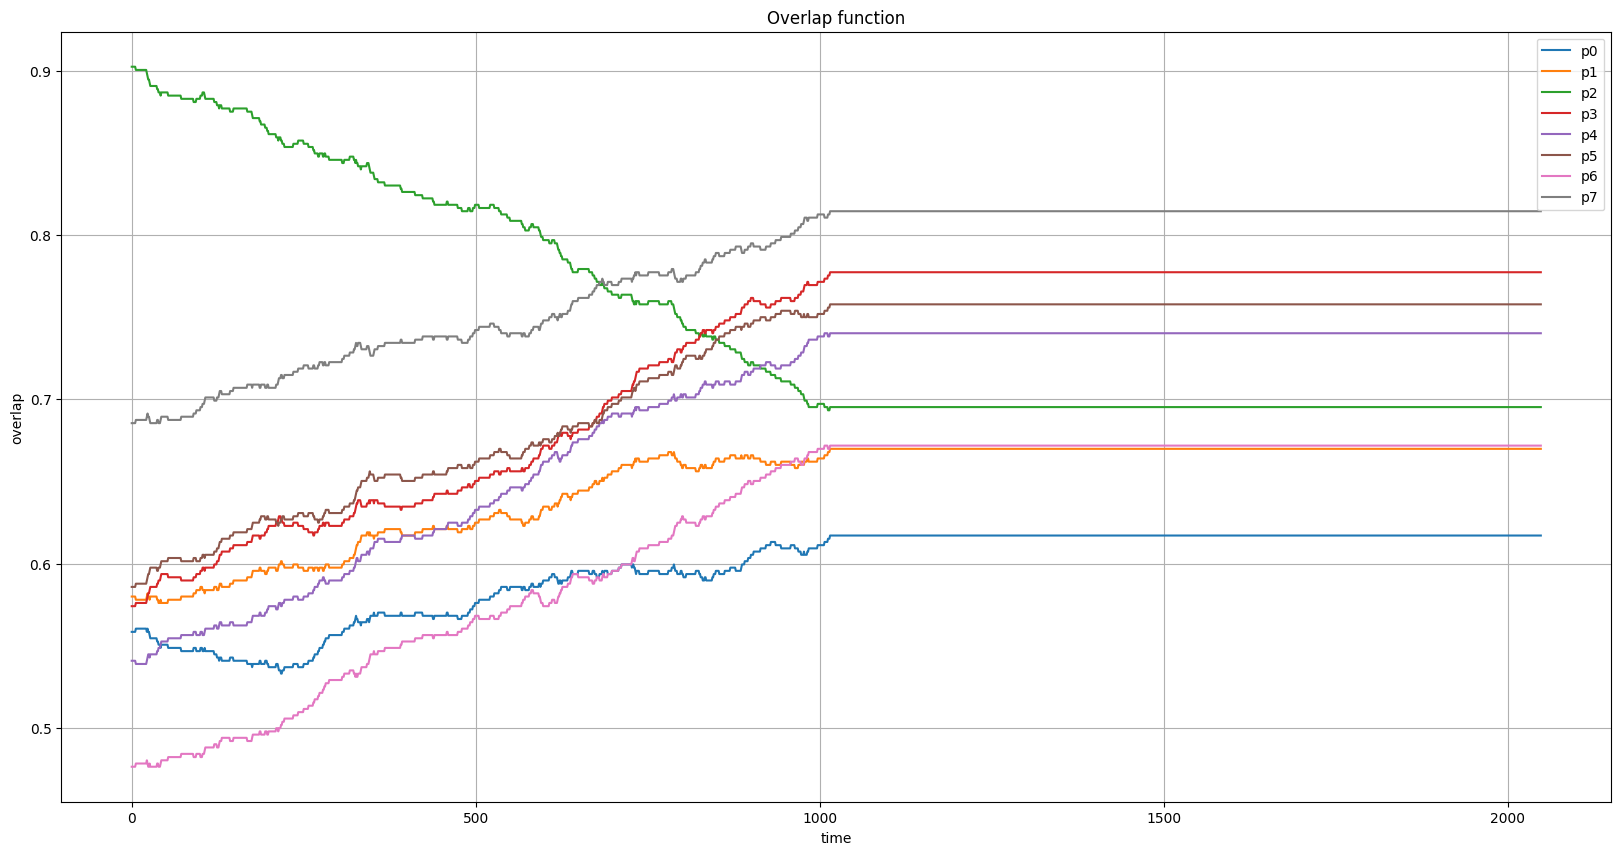

Overlap or pattern 3


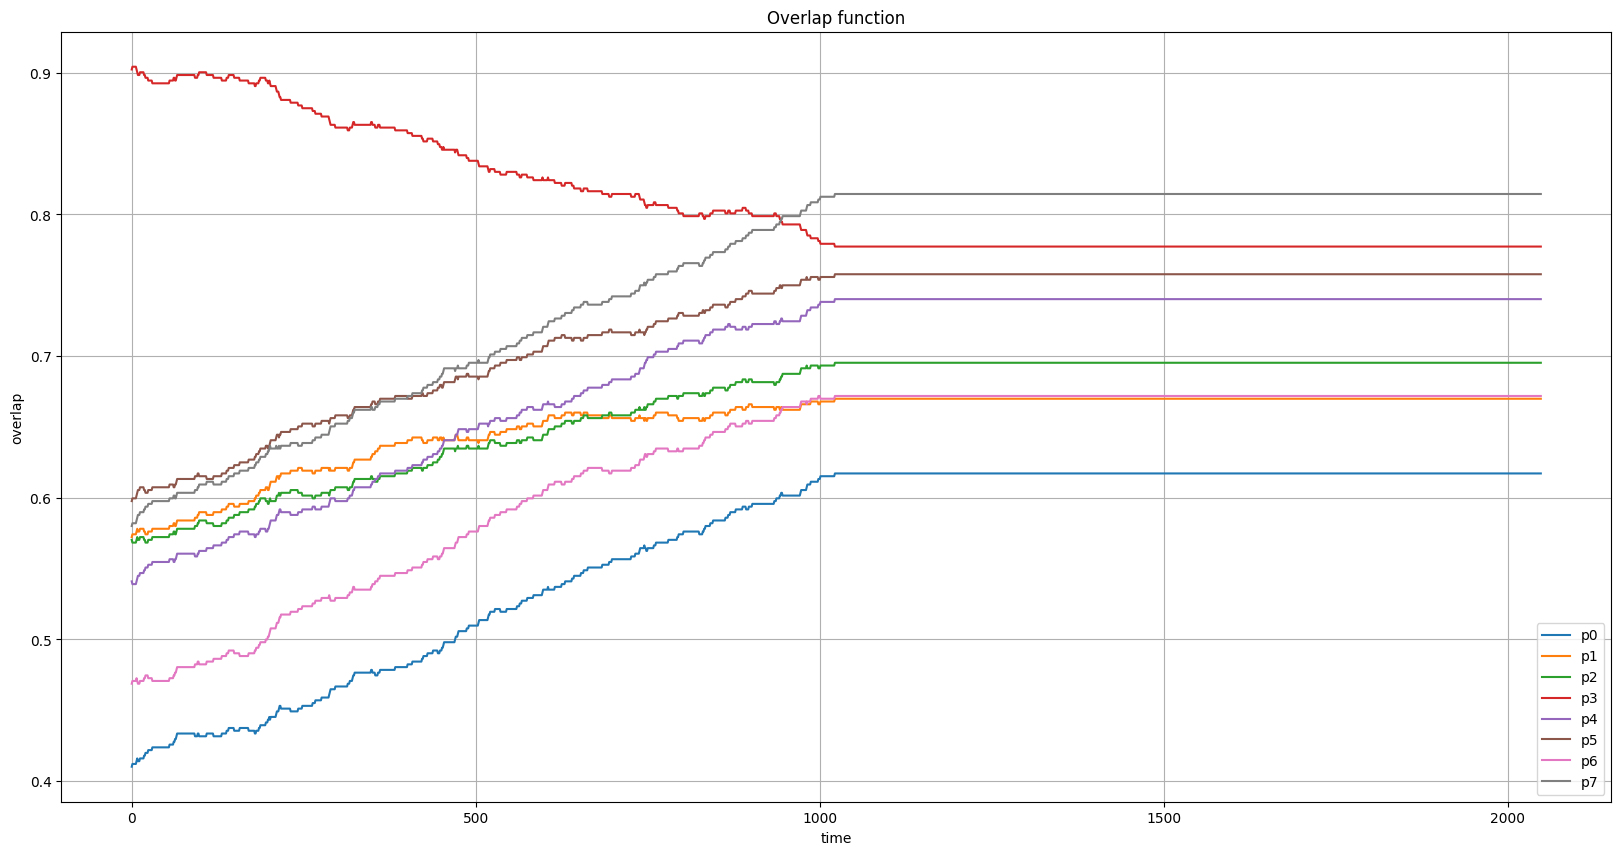

Overlap or pattern 4


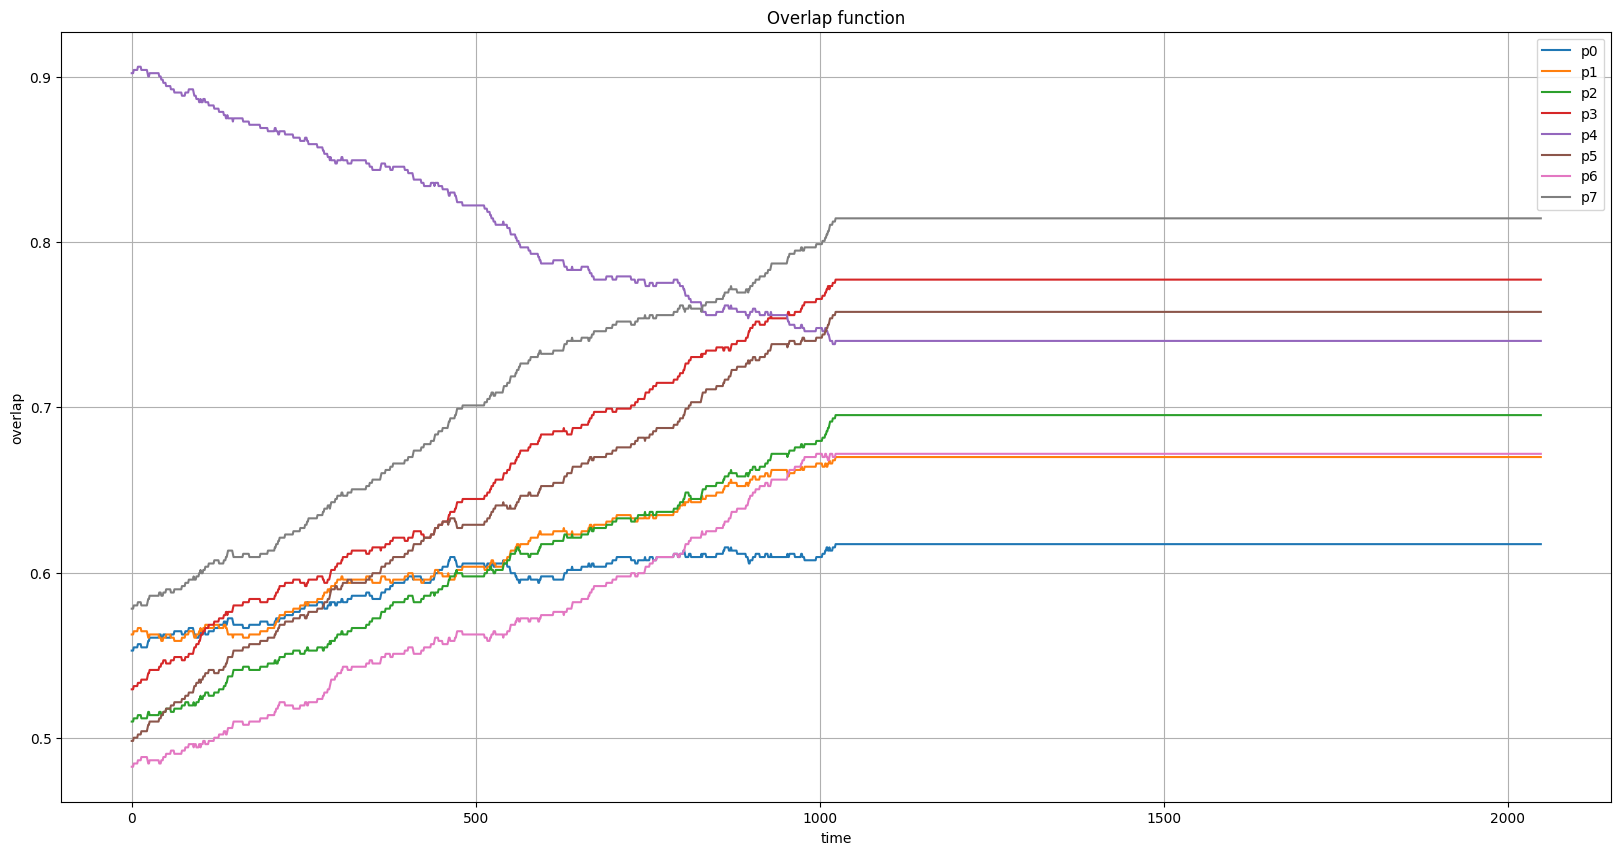

Overlap or pattern 5


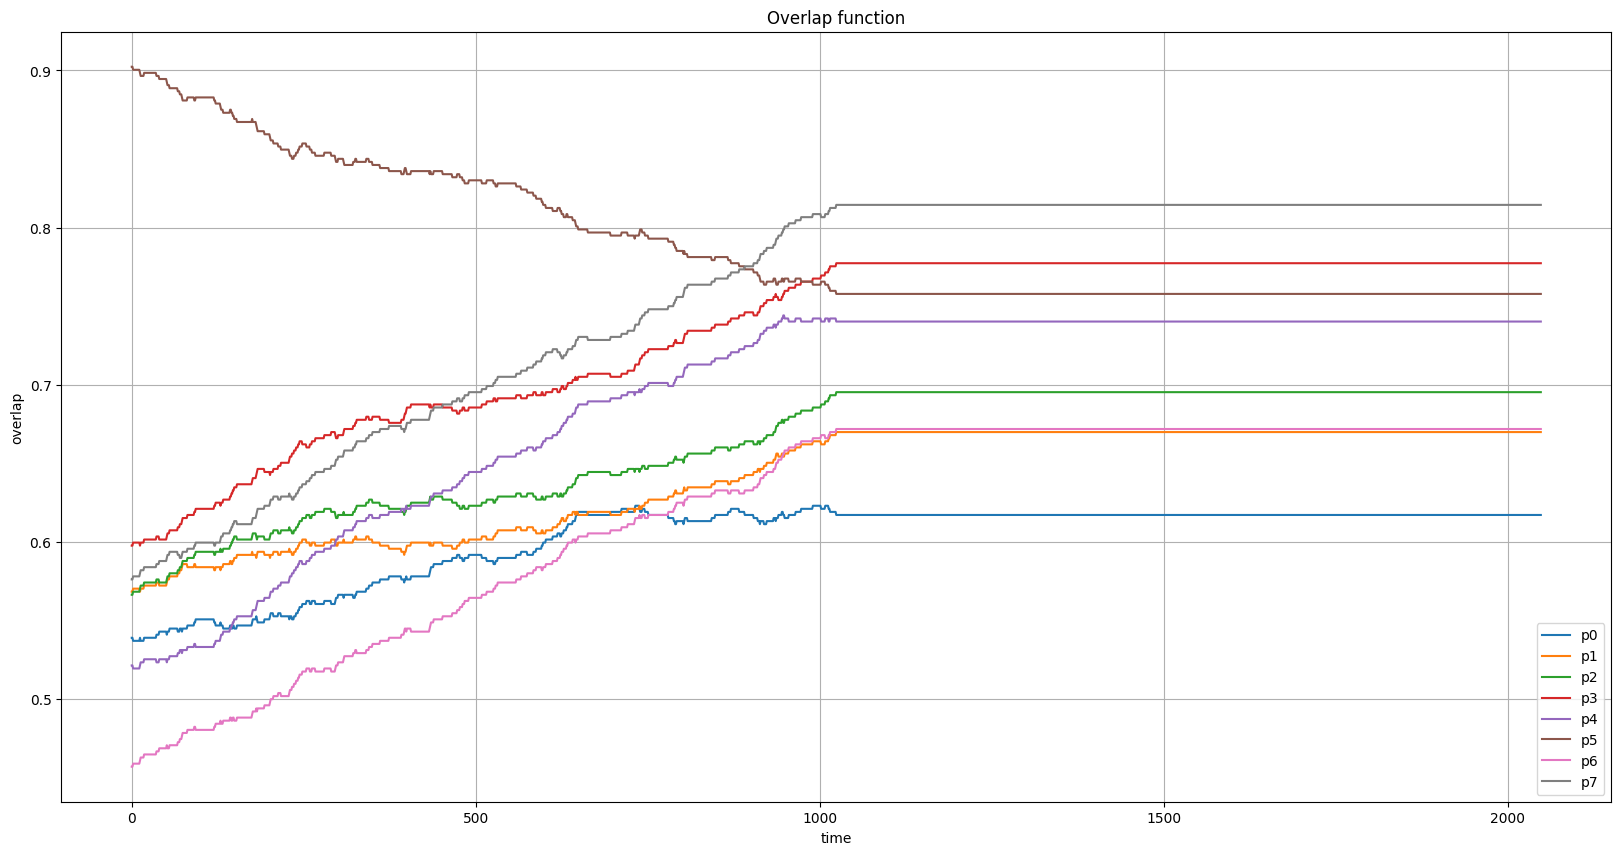

Overlap or pattern 6


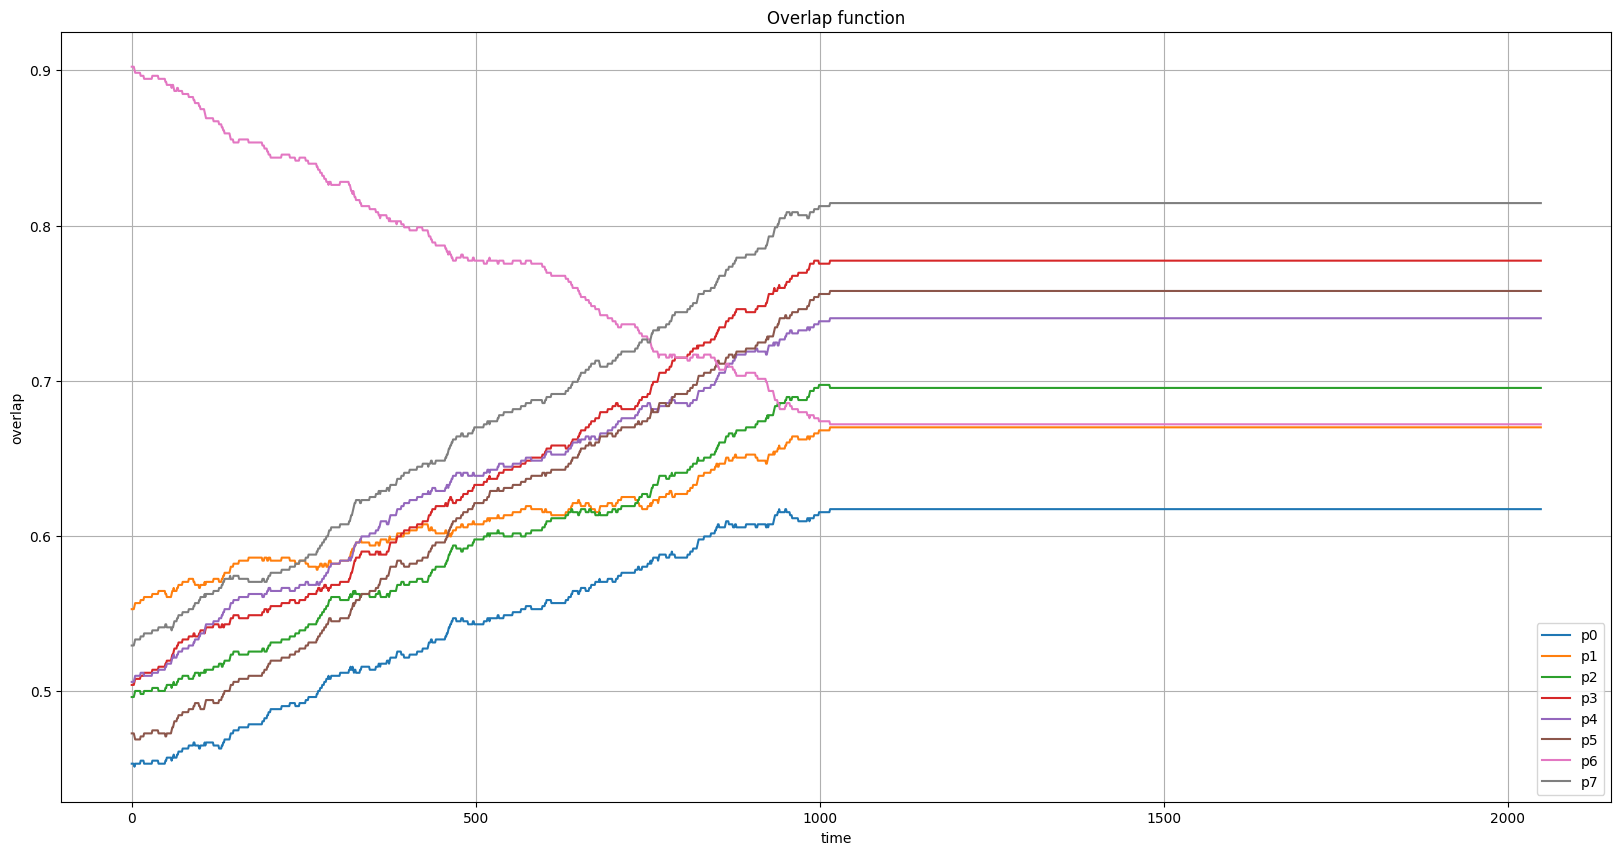

Overlap or pattern 7


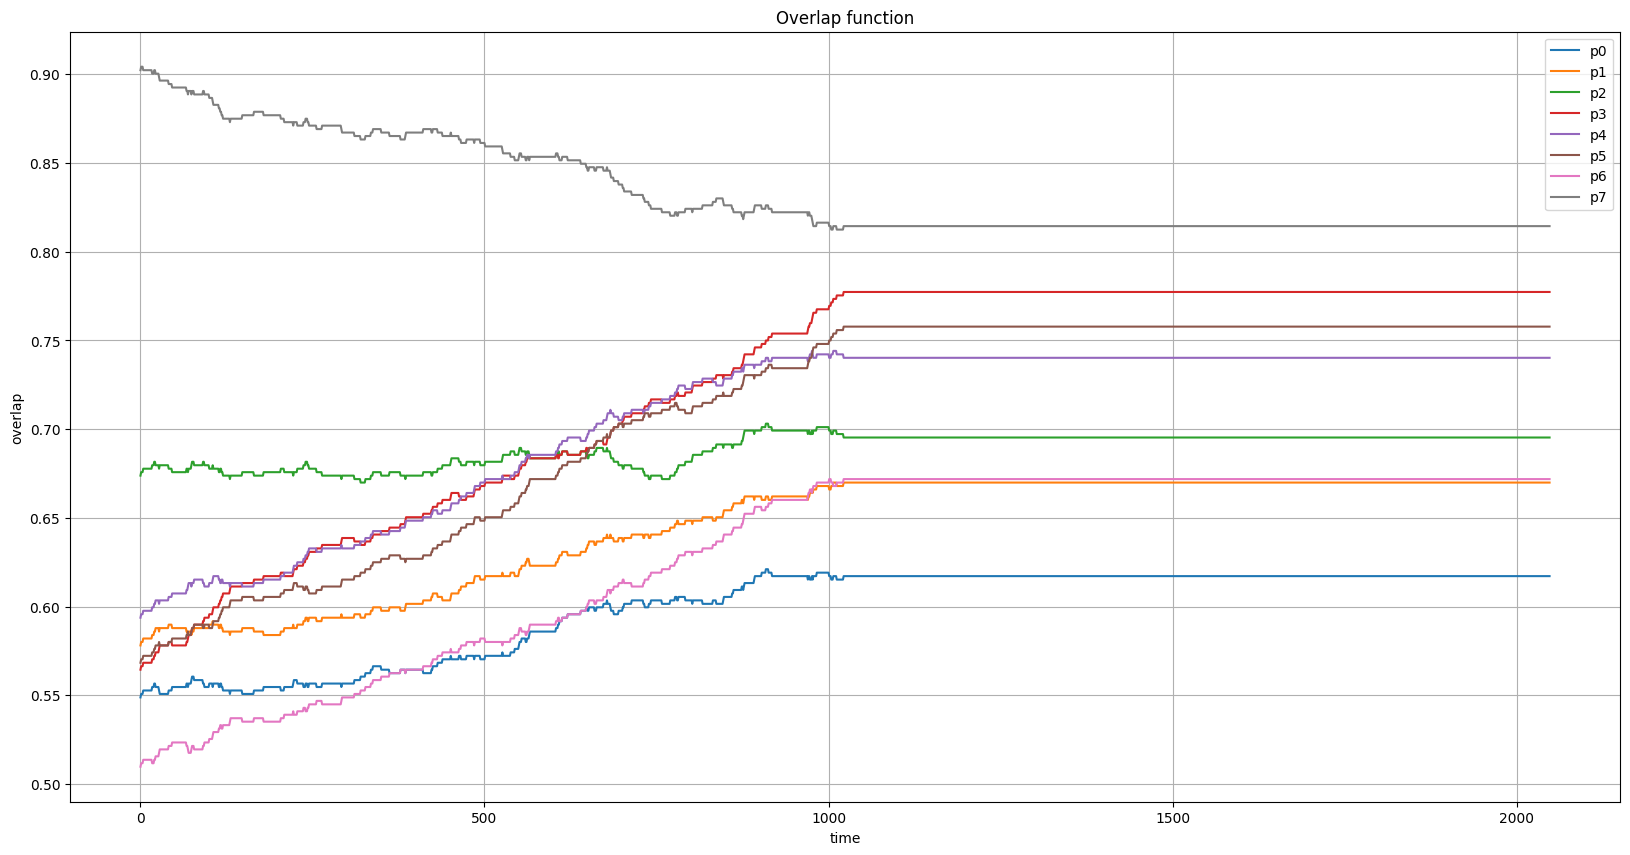

Network storing patterns until 8
Overlap or pattern 0


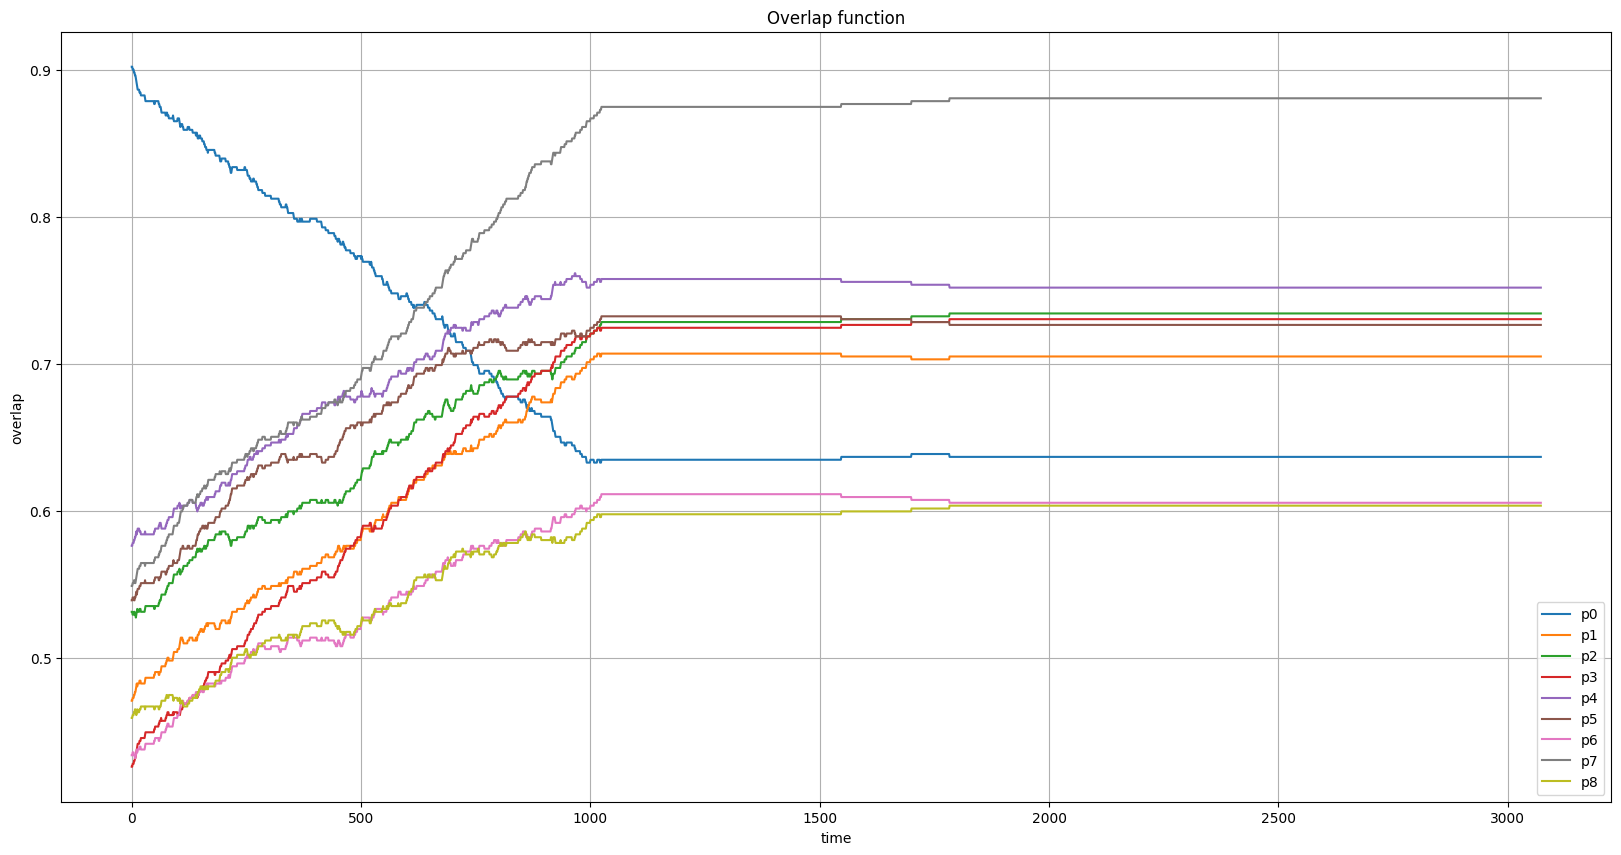

Overlap or pattern 1


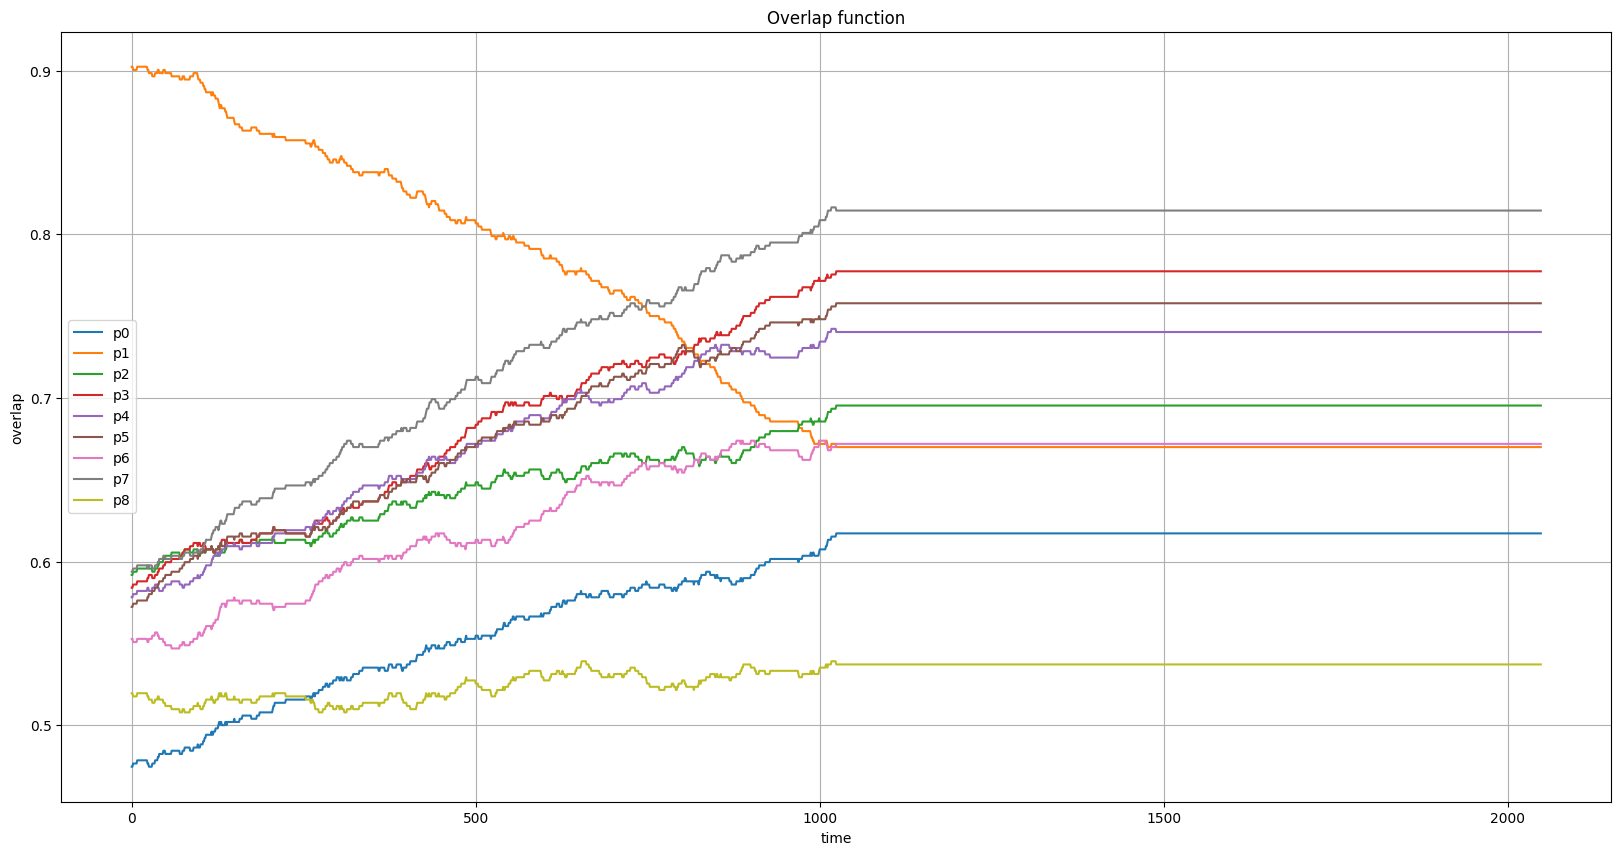

Overlap or pattern 2


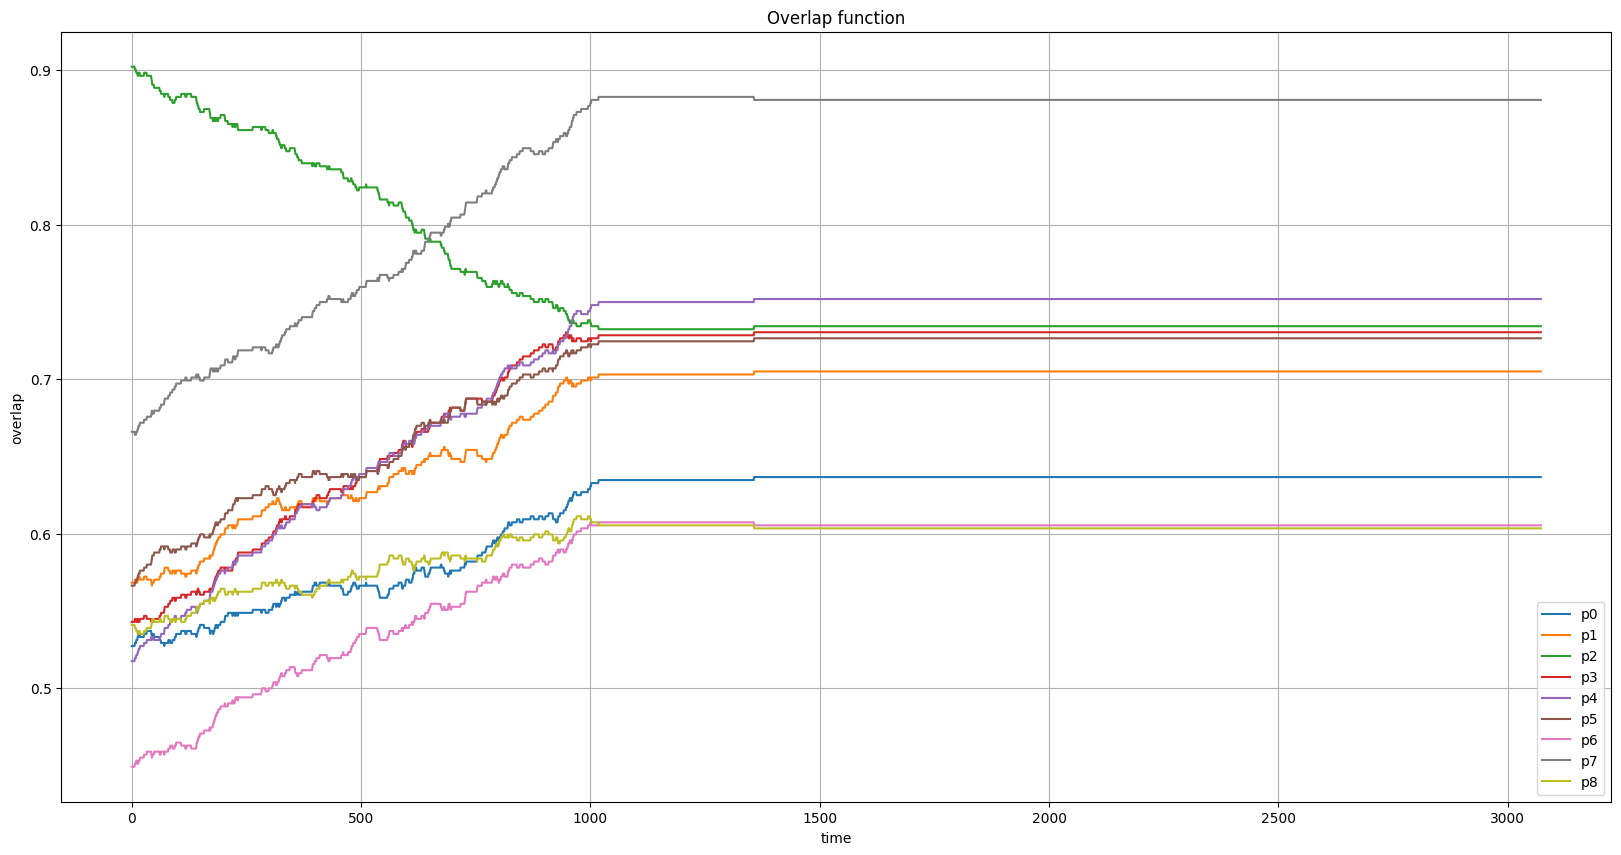

Overlap or pattern 3


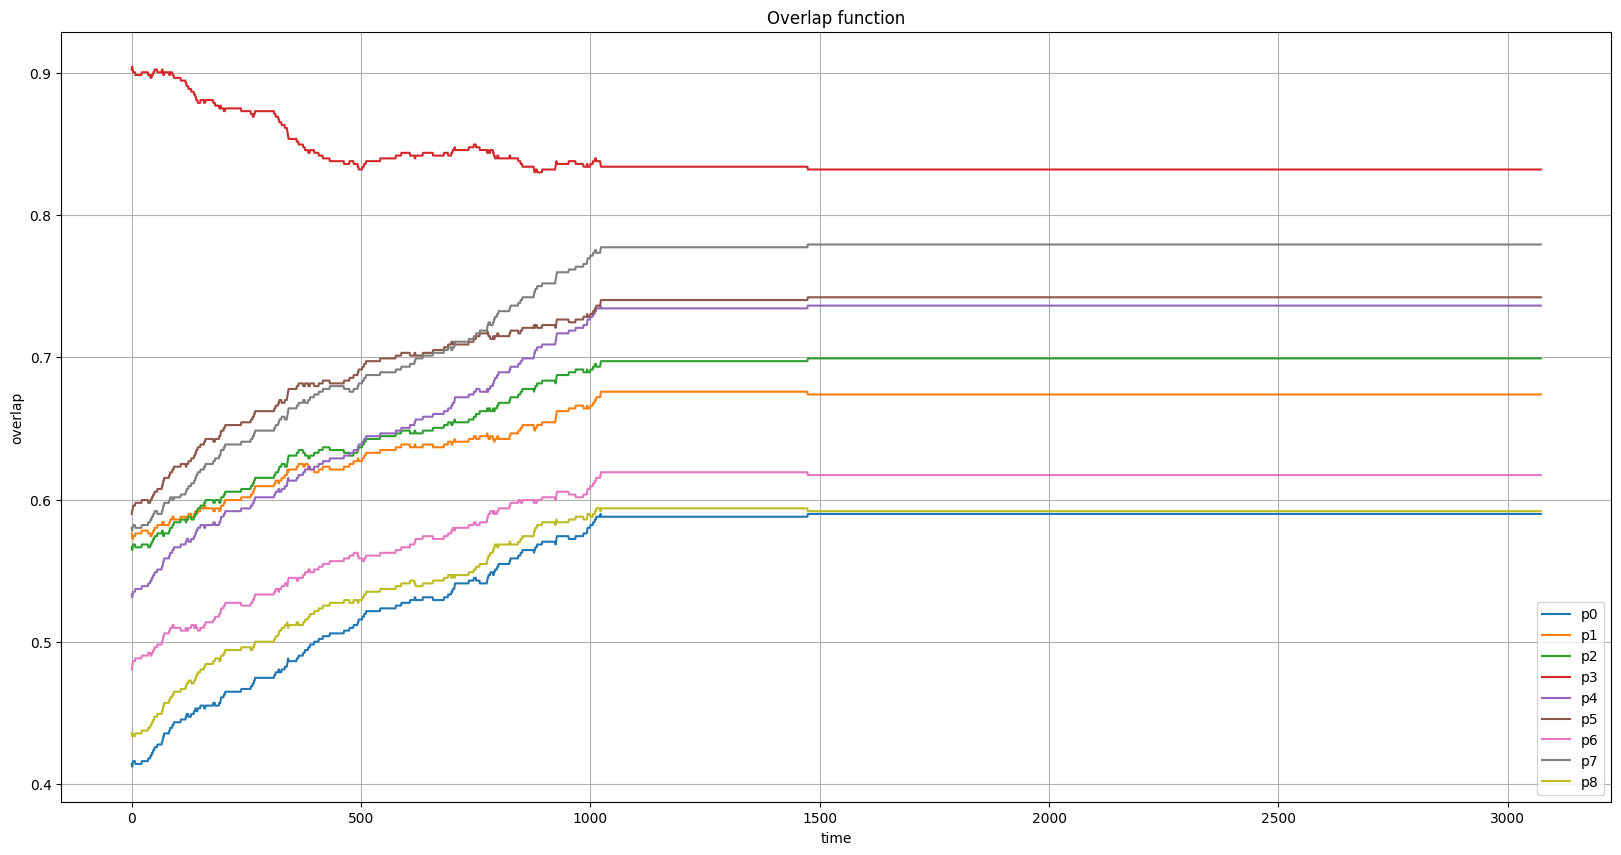

Overlap or pattern 4


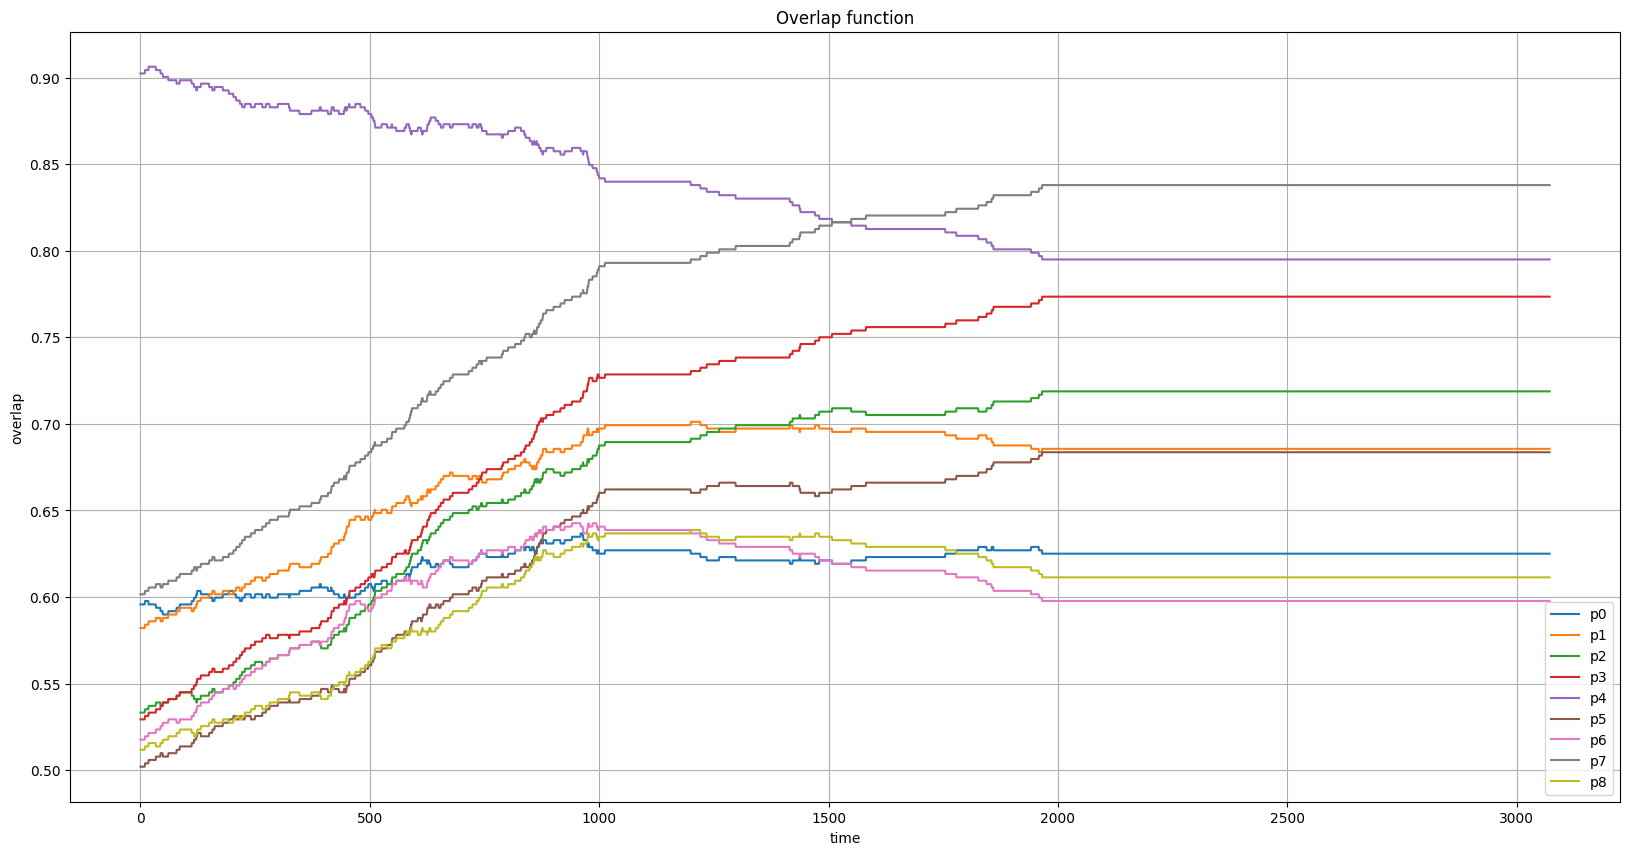

Overlap or pattern 5


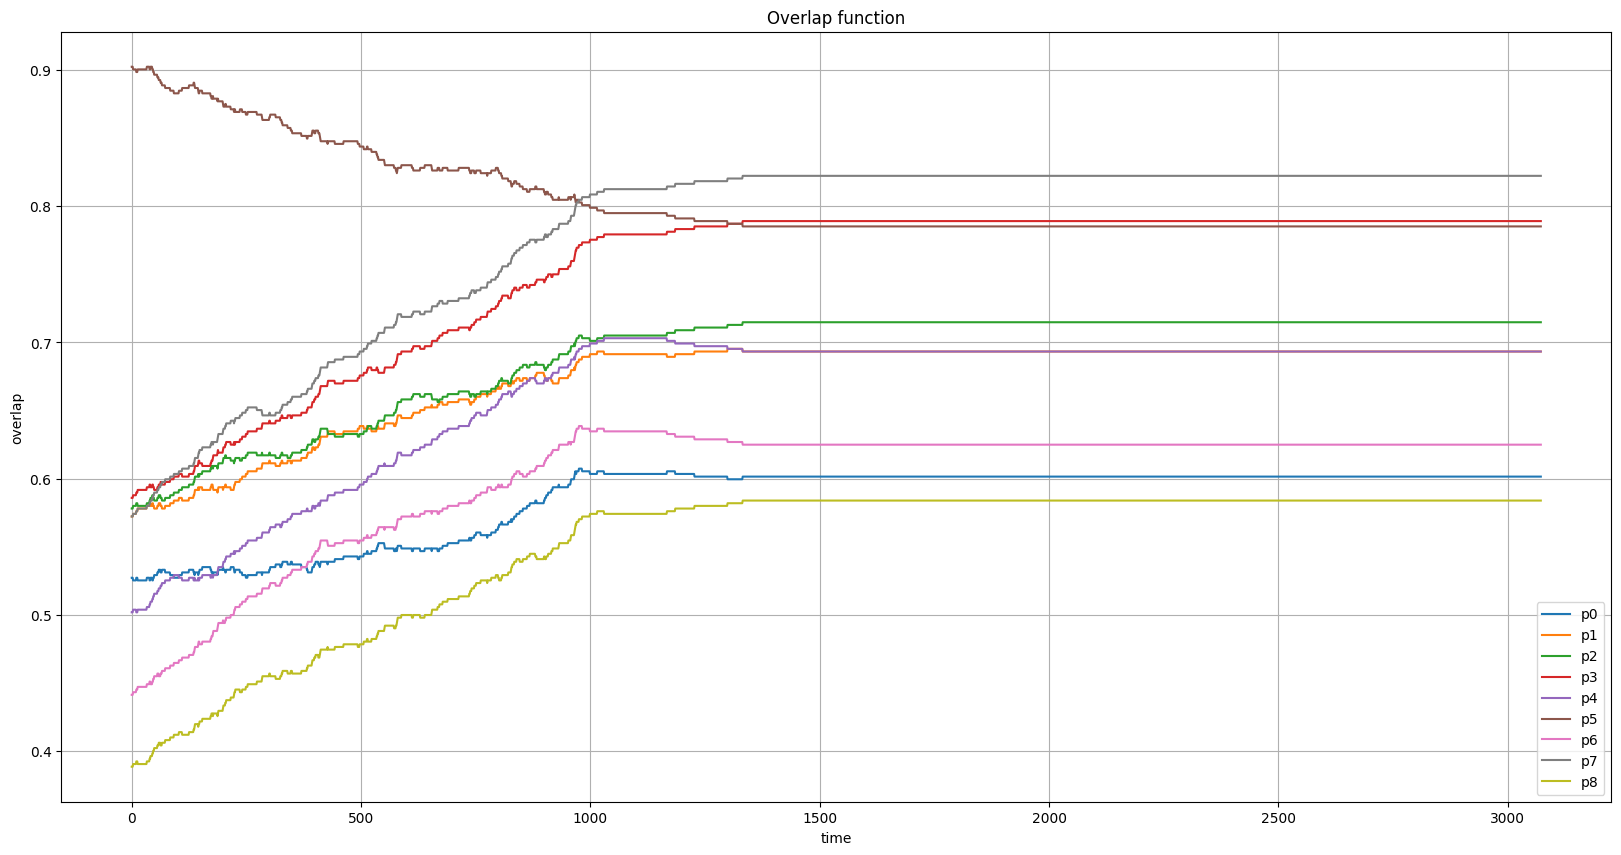

Overlap or pattern 6


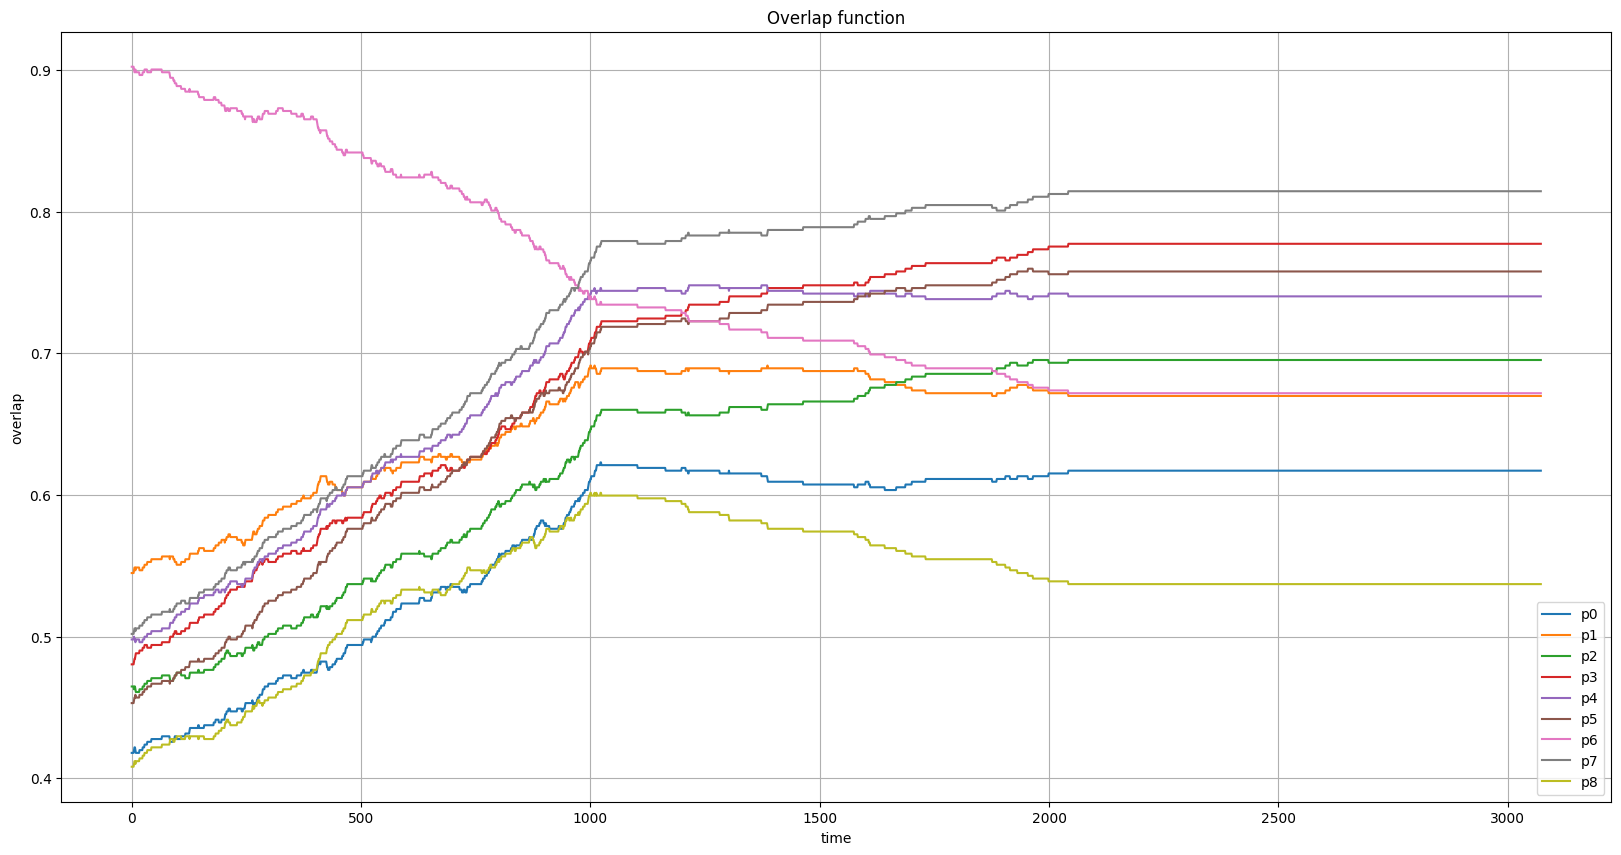

Overlap or pattern 7


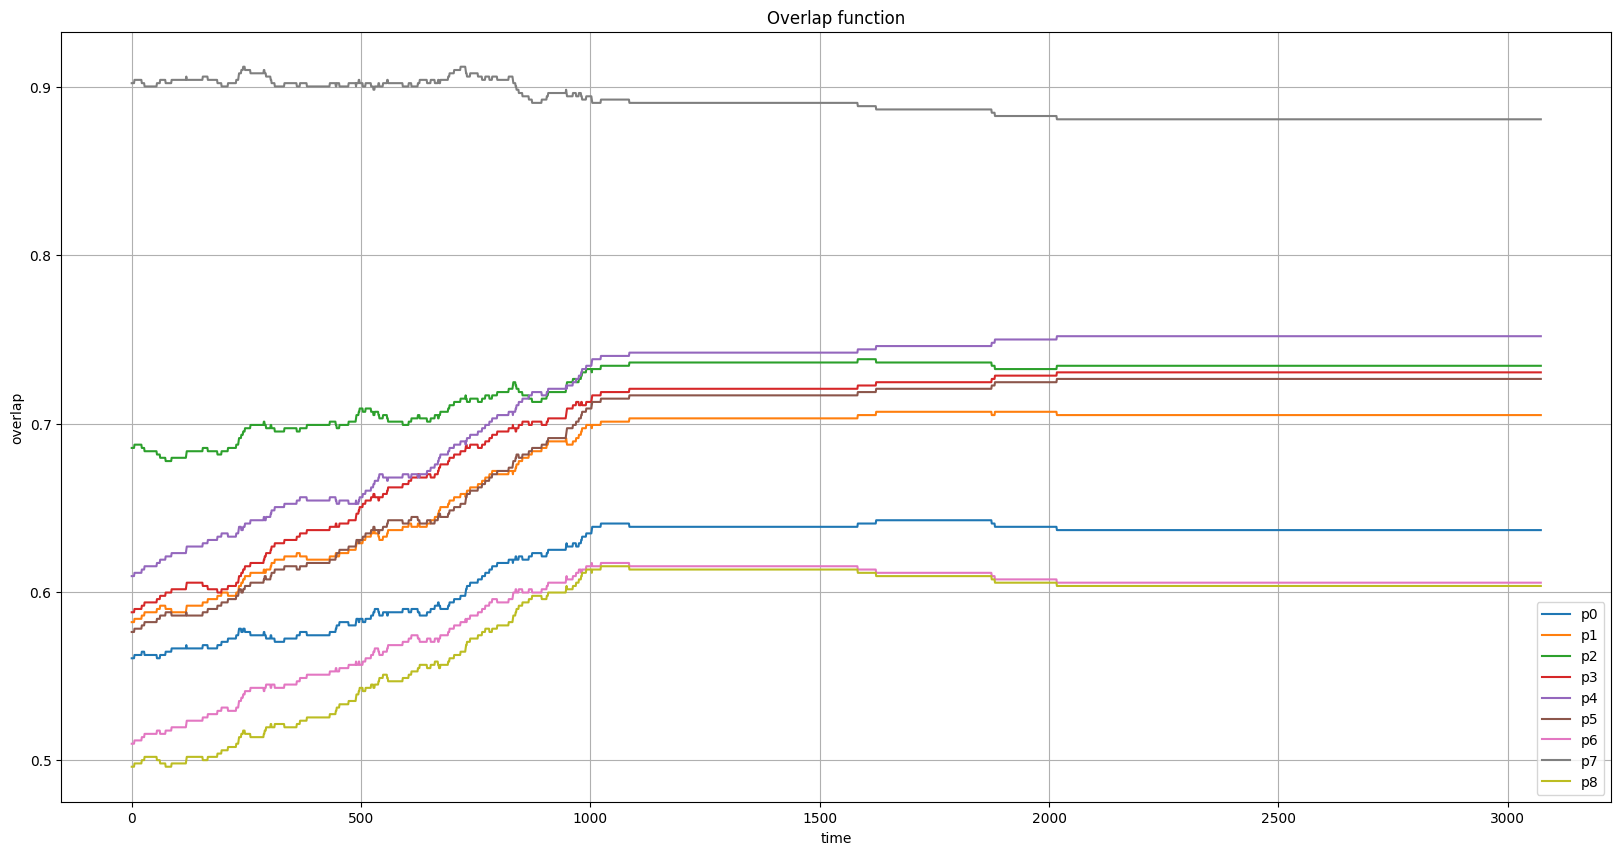

Overlap or pattern 8


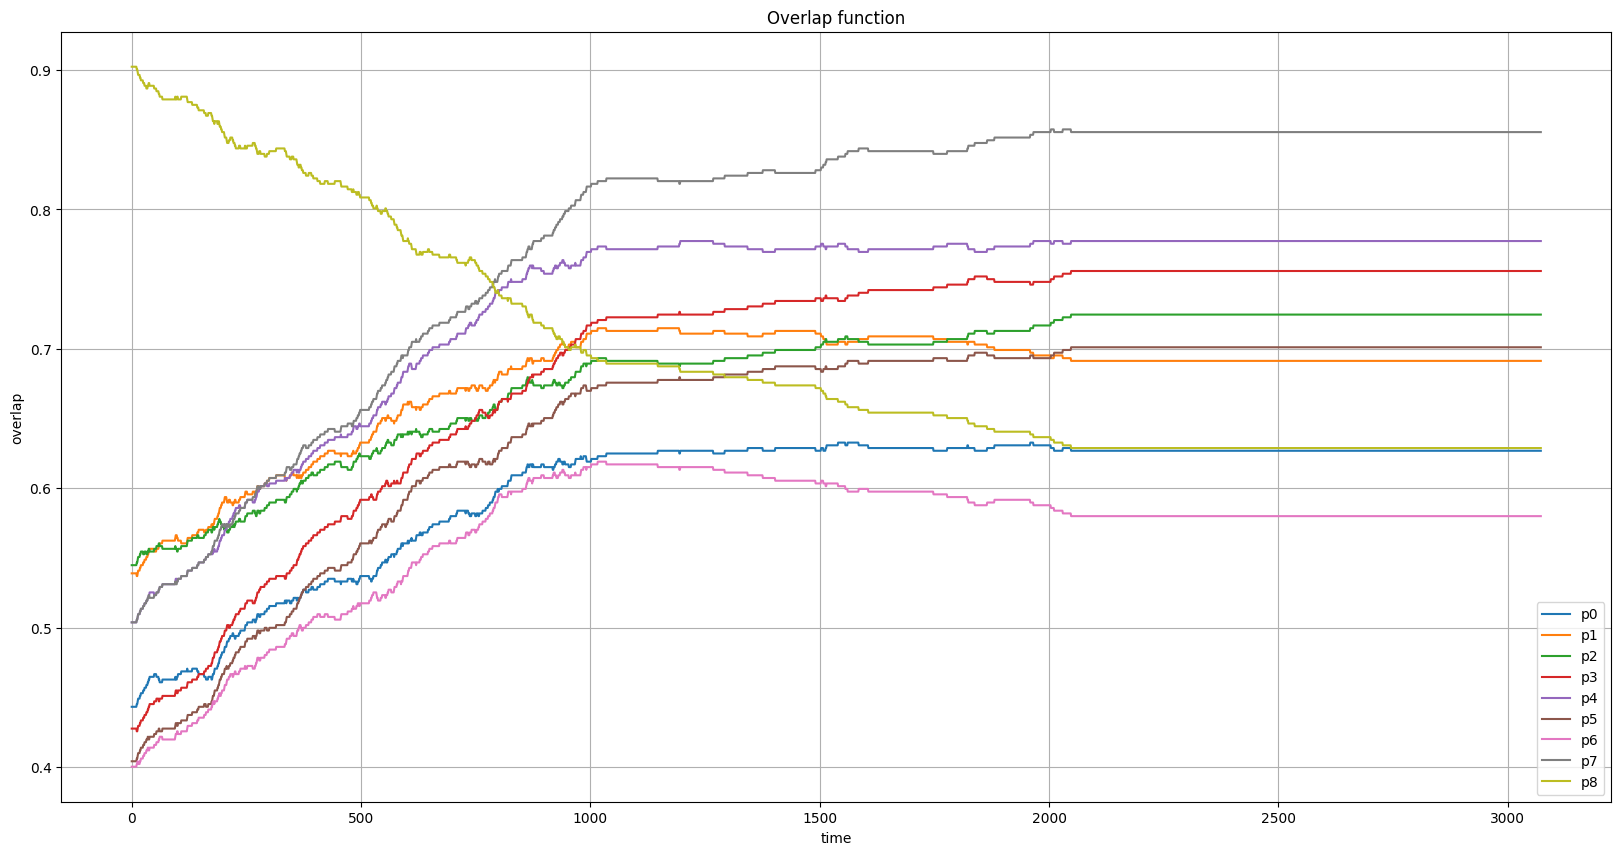

Network storing patterns until 9
Overlap or pattern 0


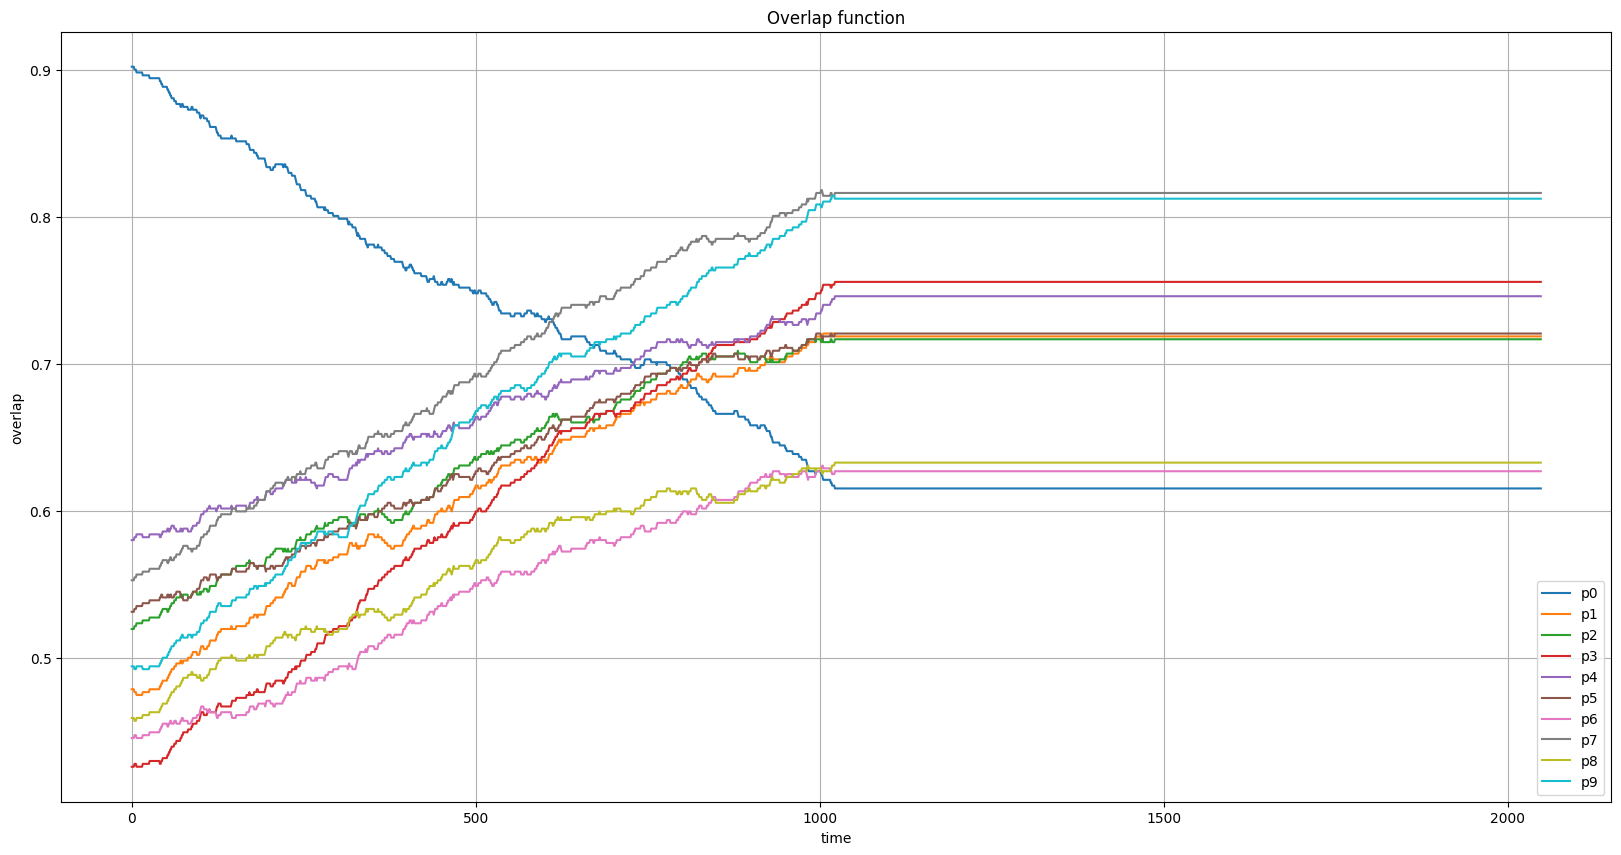

Overlap or pattern 1


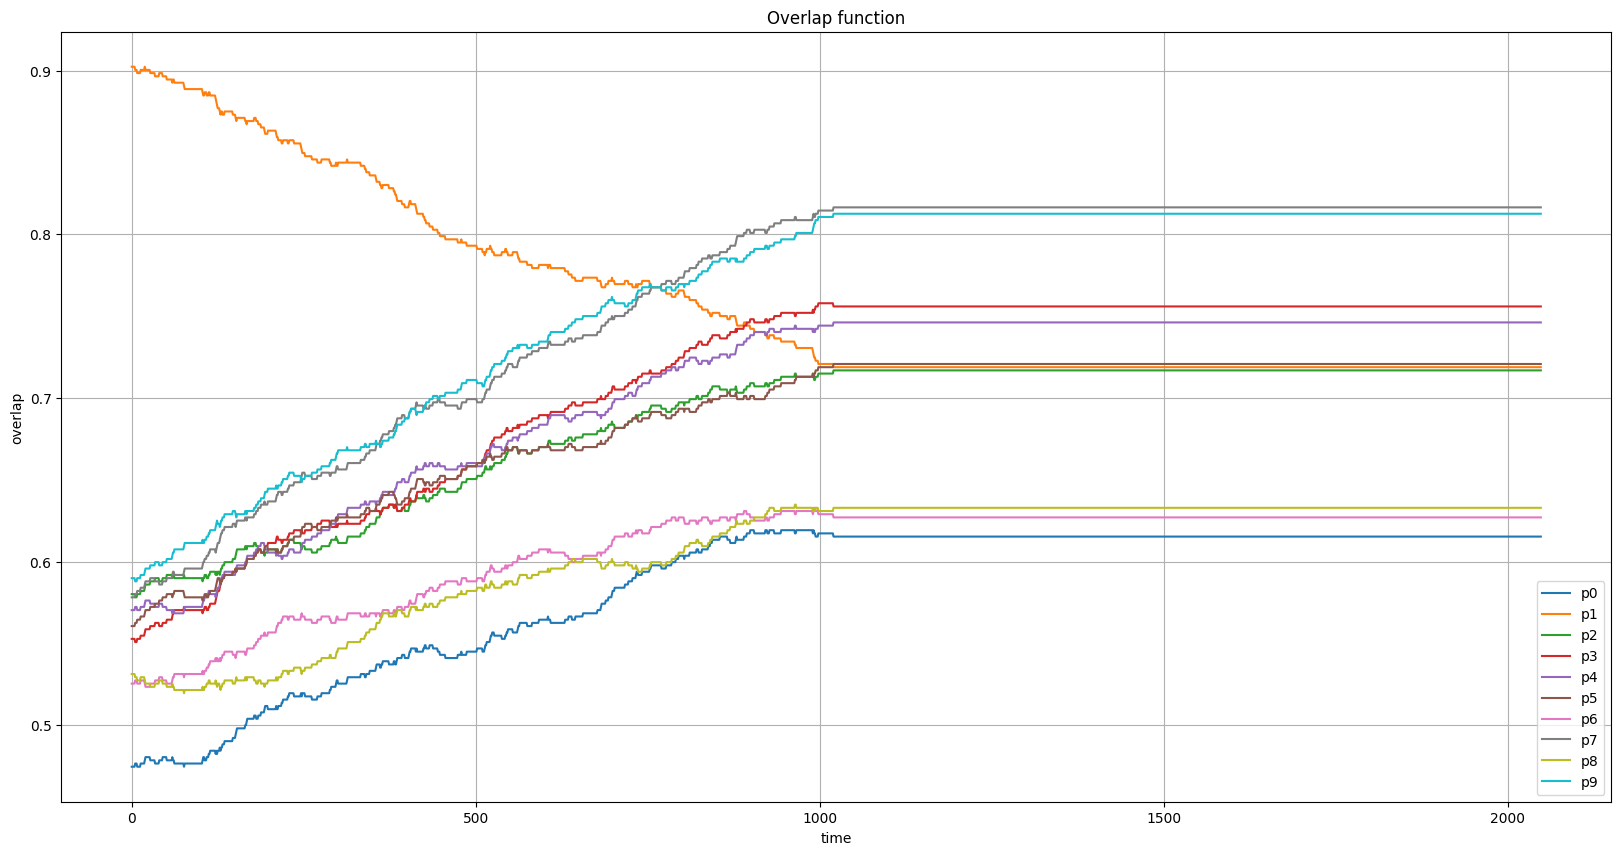

Overlap or pattern 2


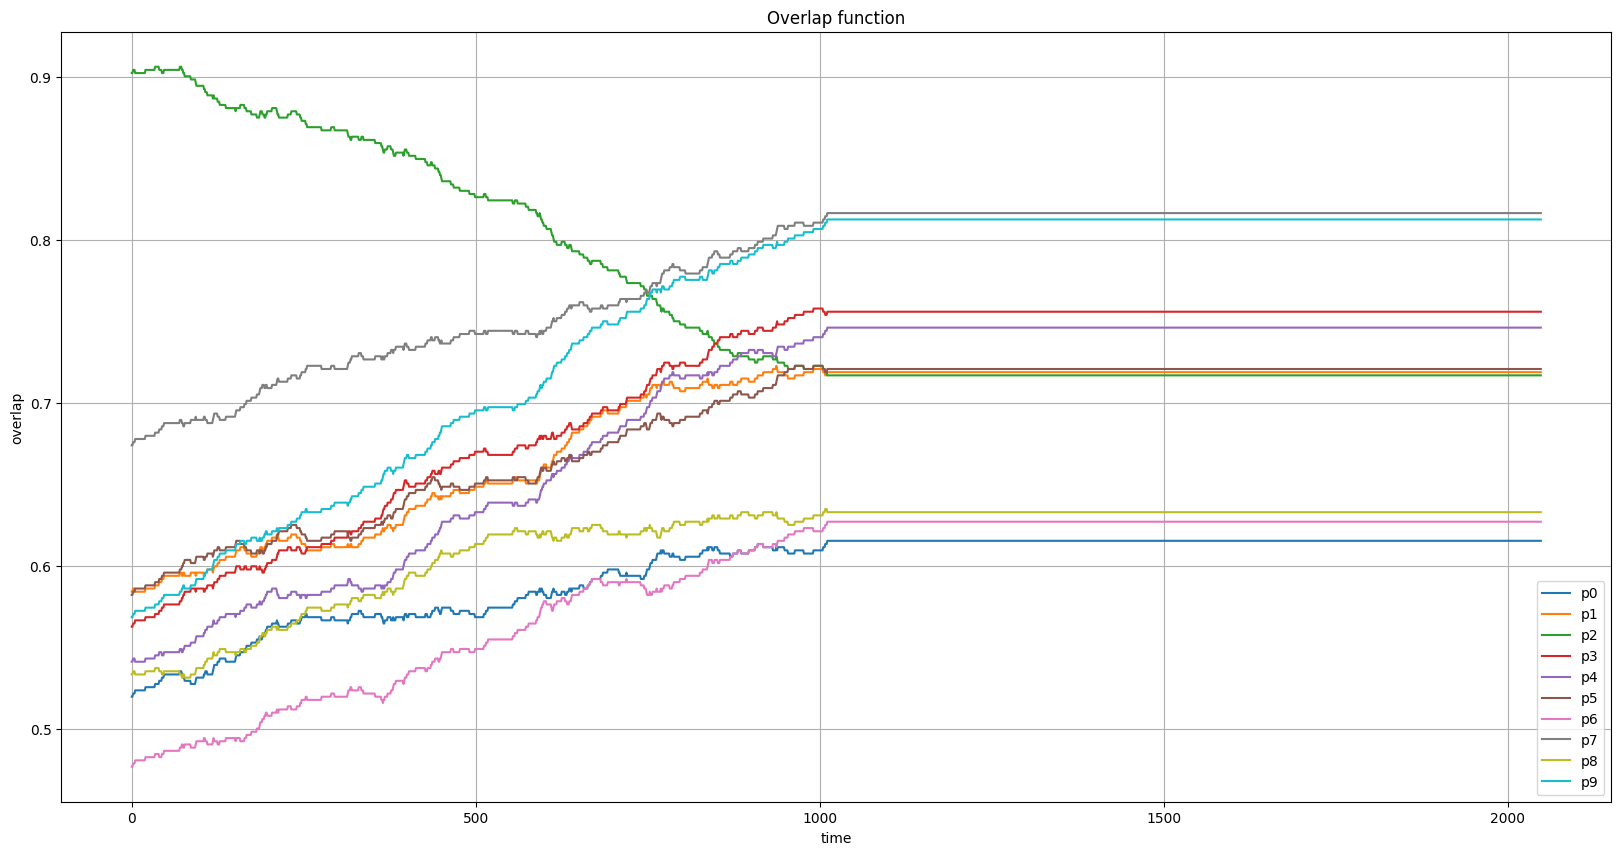

Overlap or pattern 3


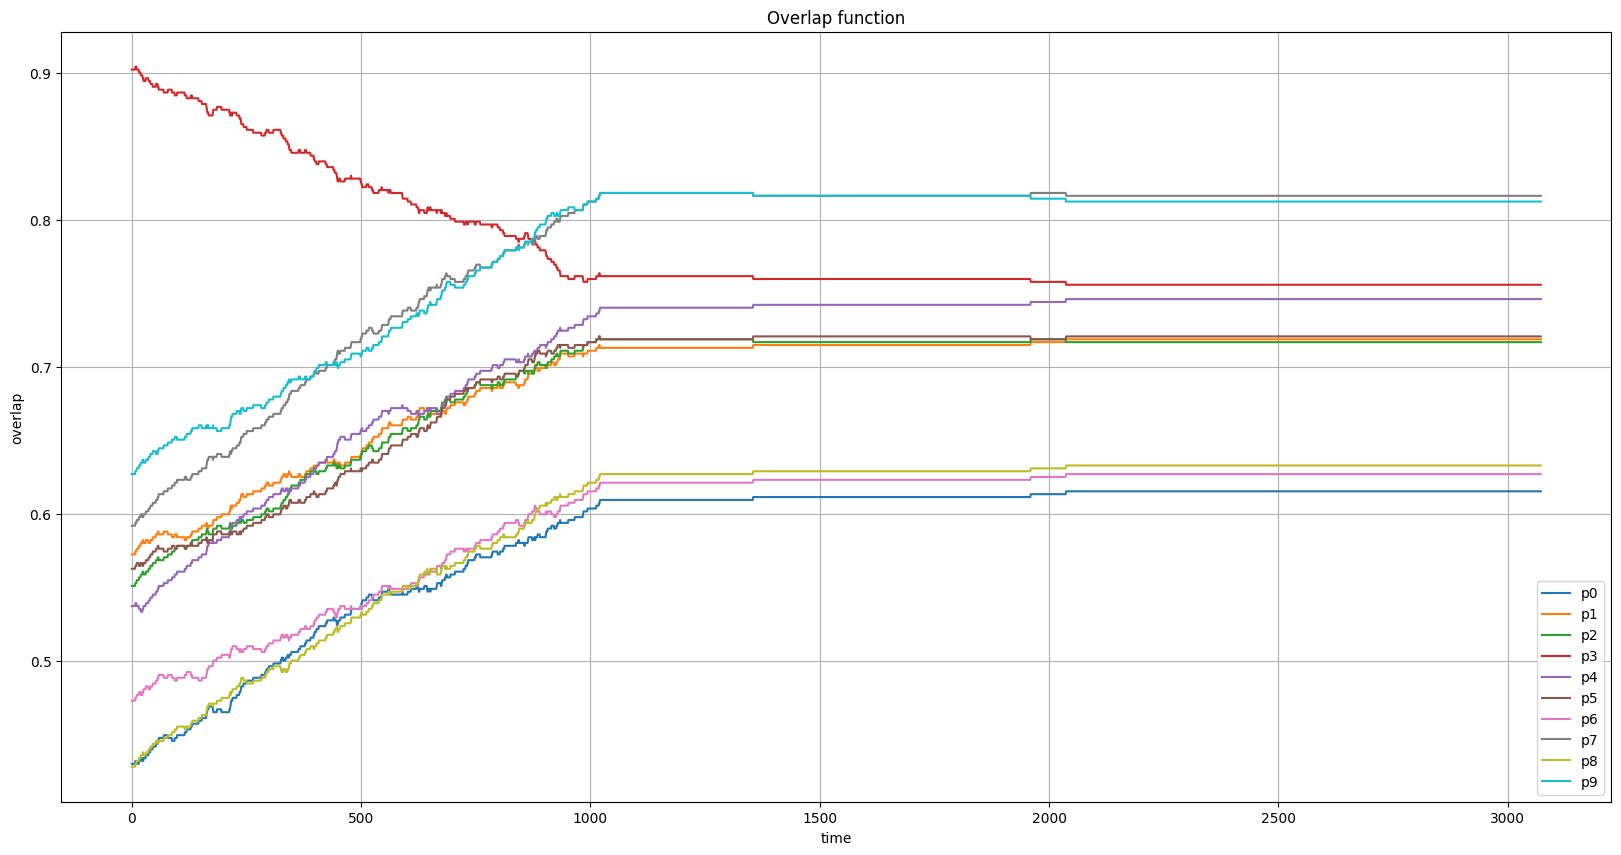

Overlap or pattern 4


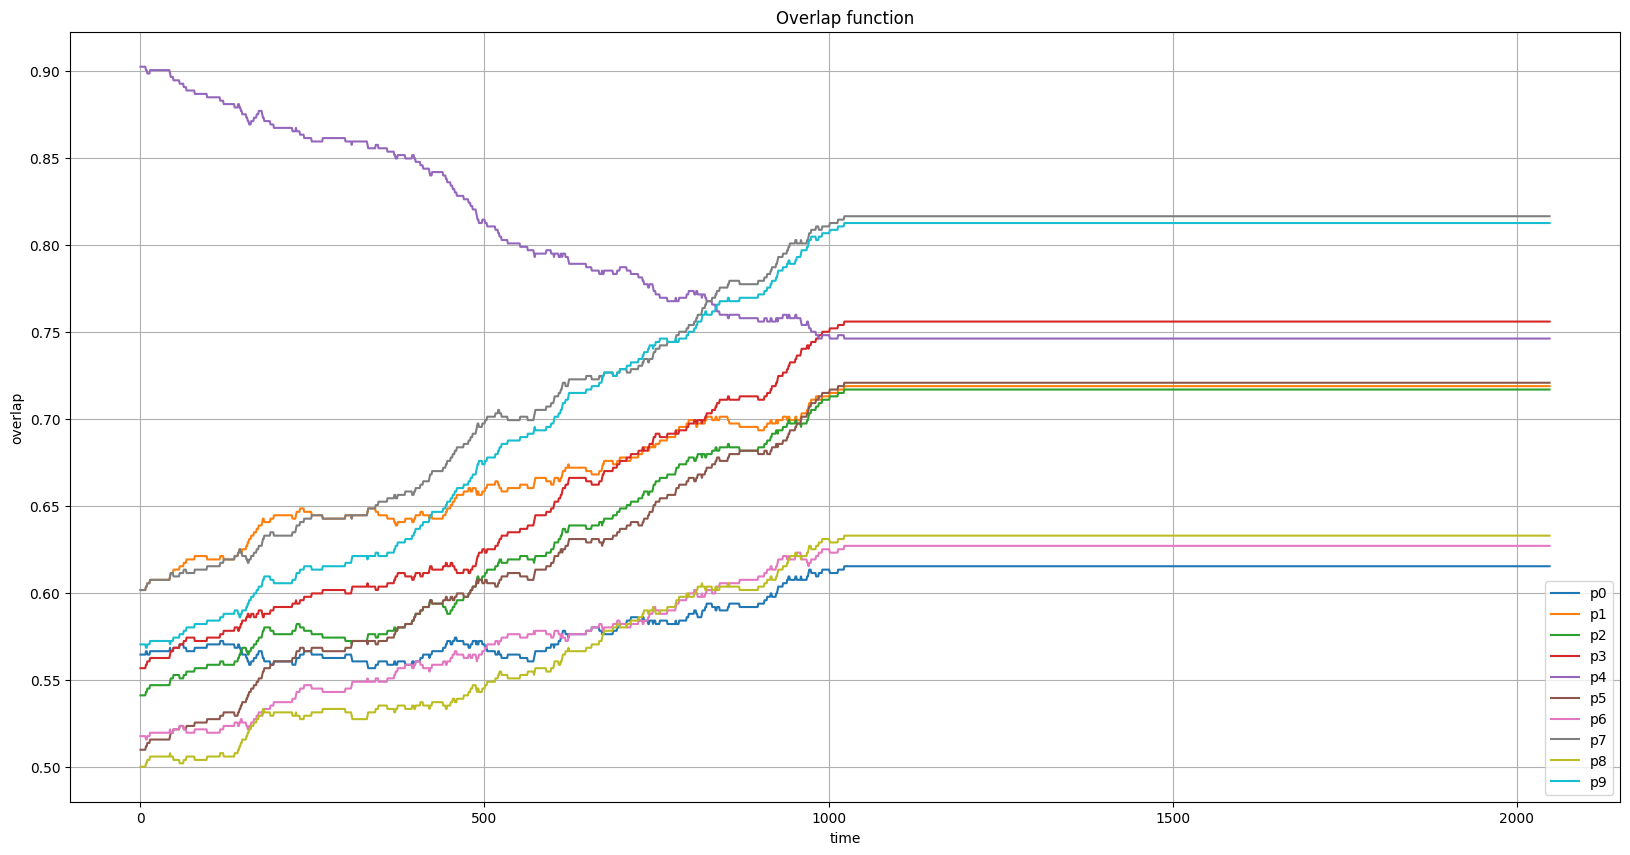

Overlap or pattern 5


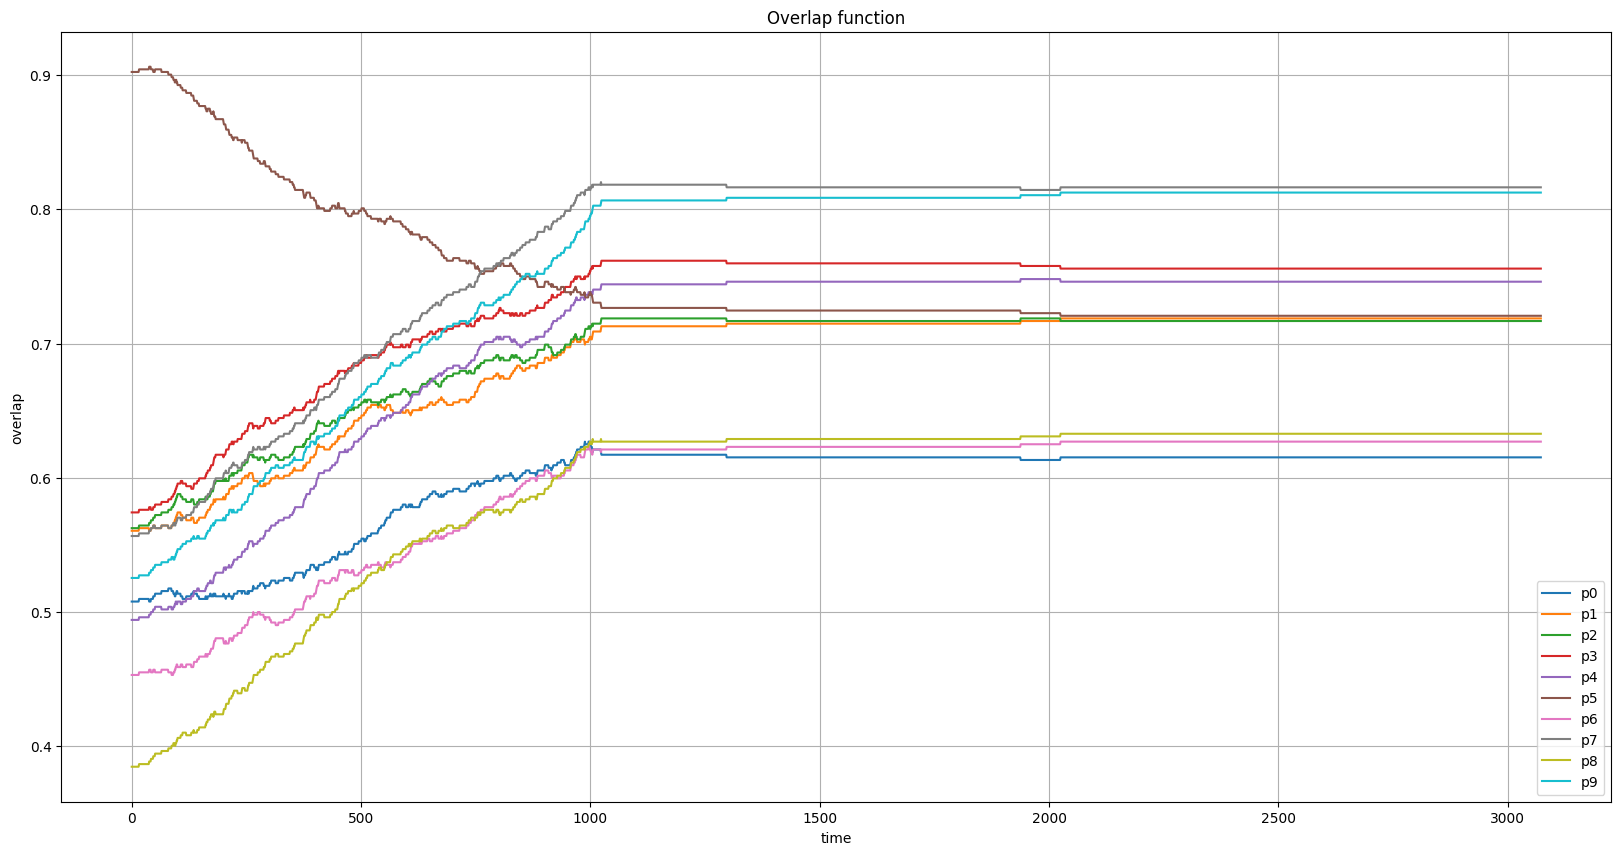

Overlap or pattern 6


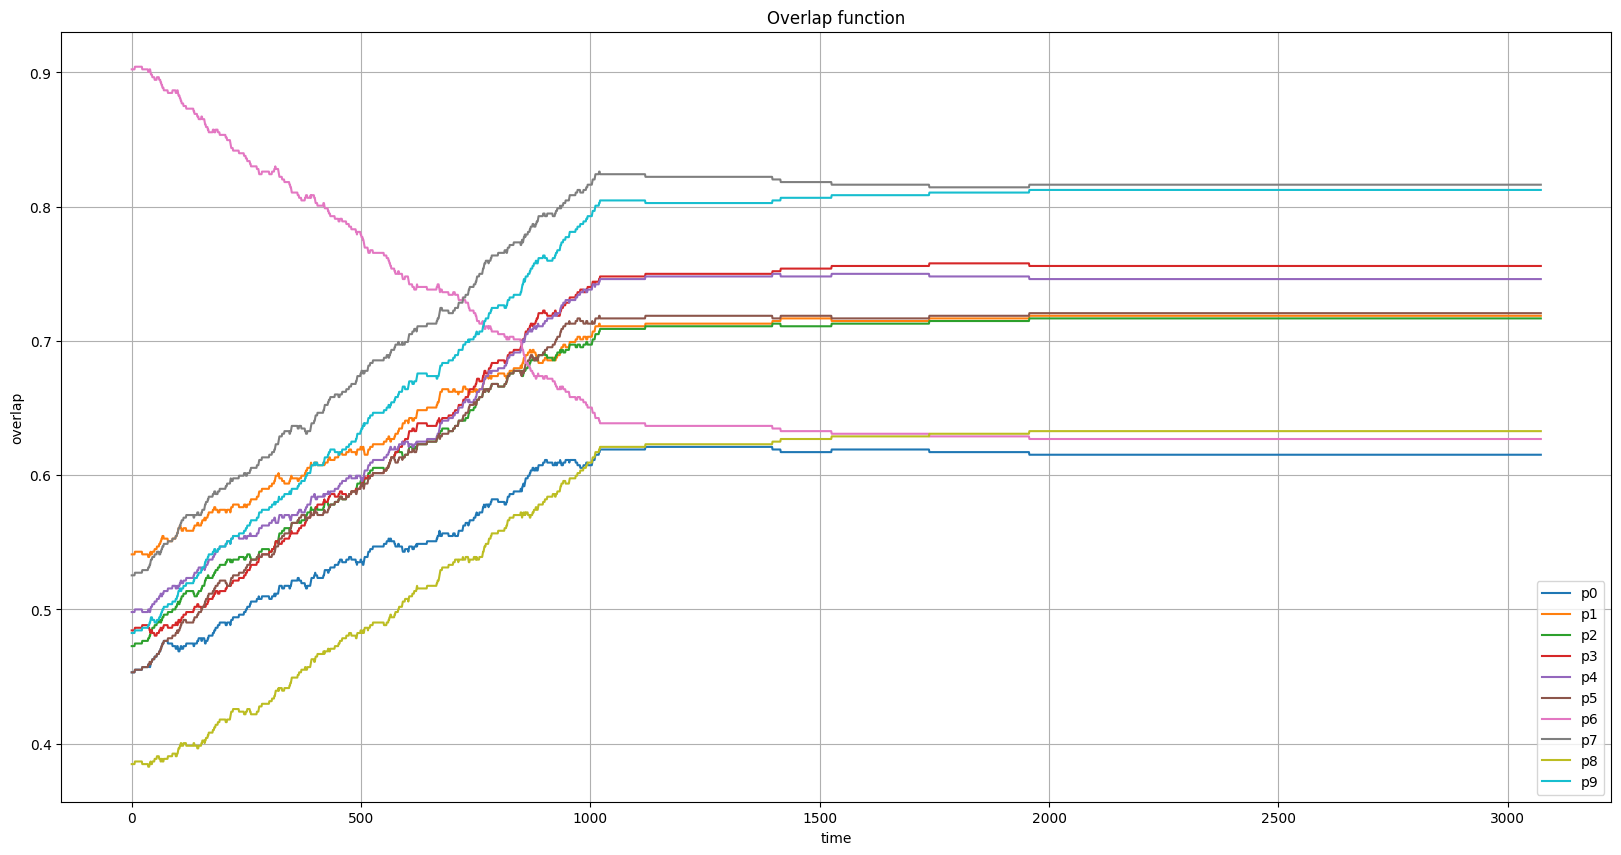

Overlap or pattern 7


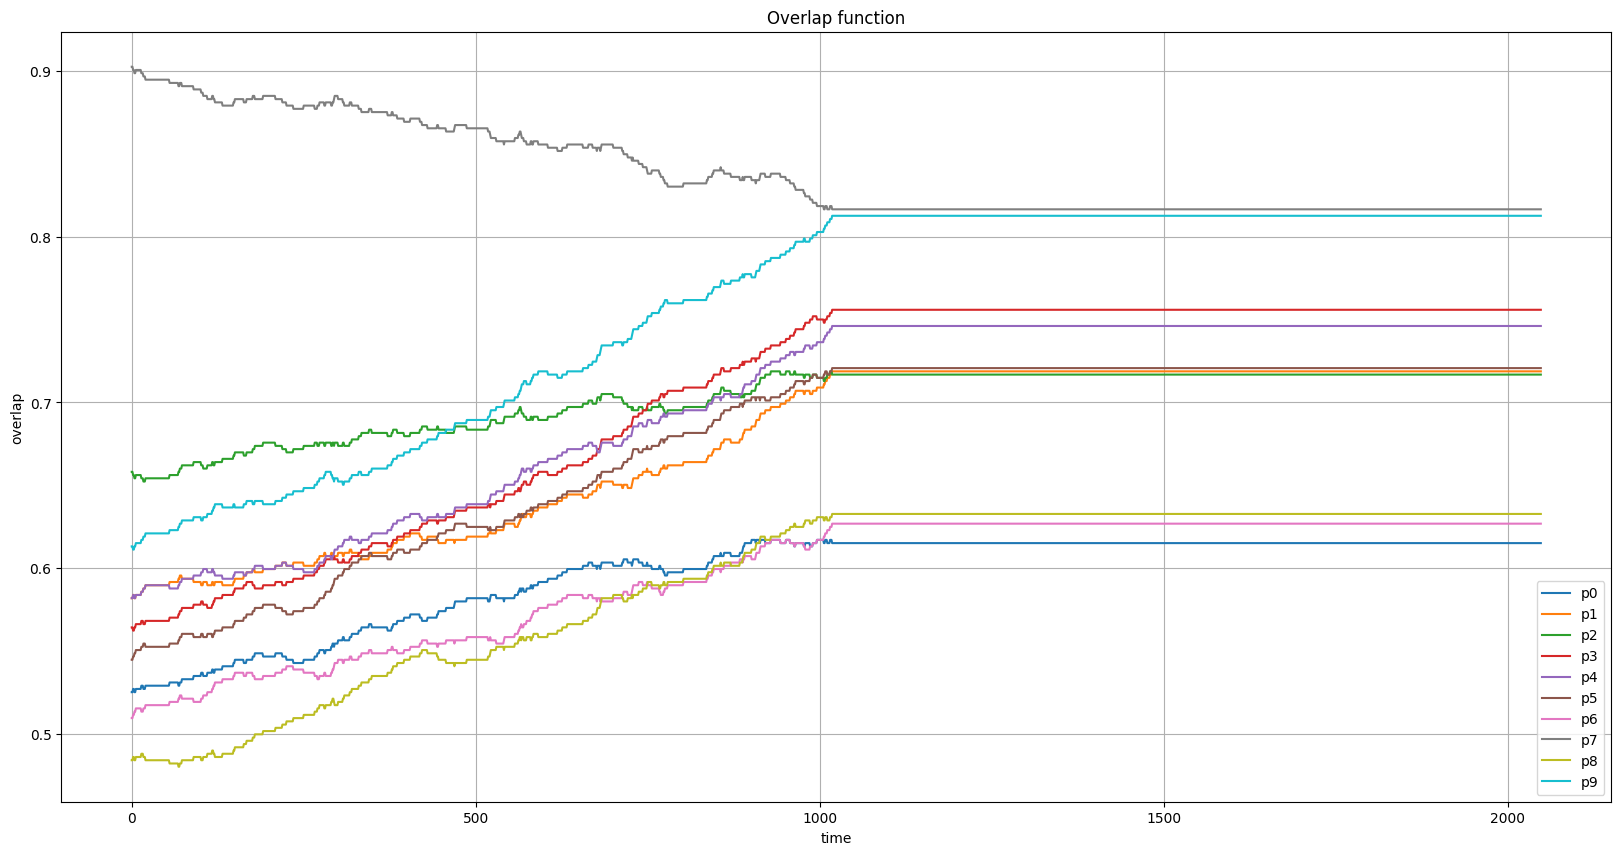

Overlap or pattern 8


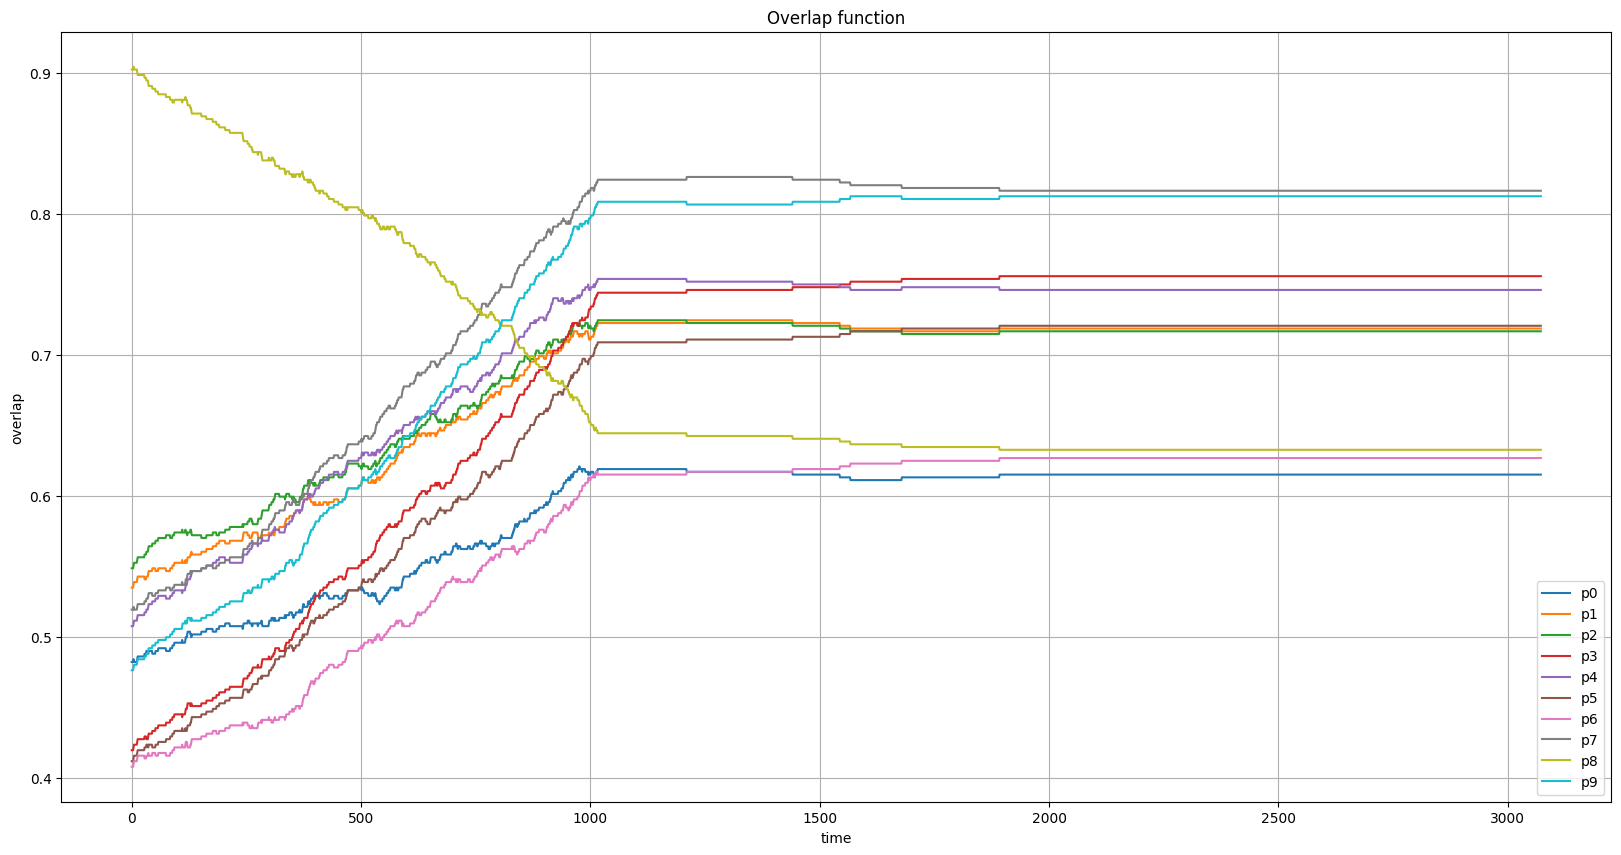

Overlap or pattern 9


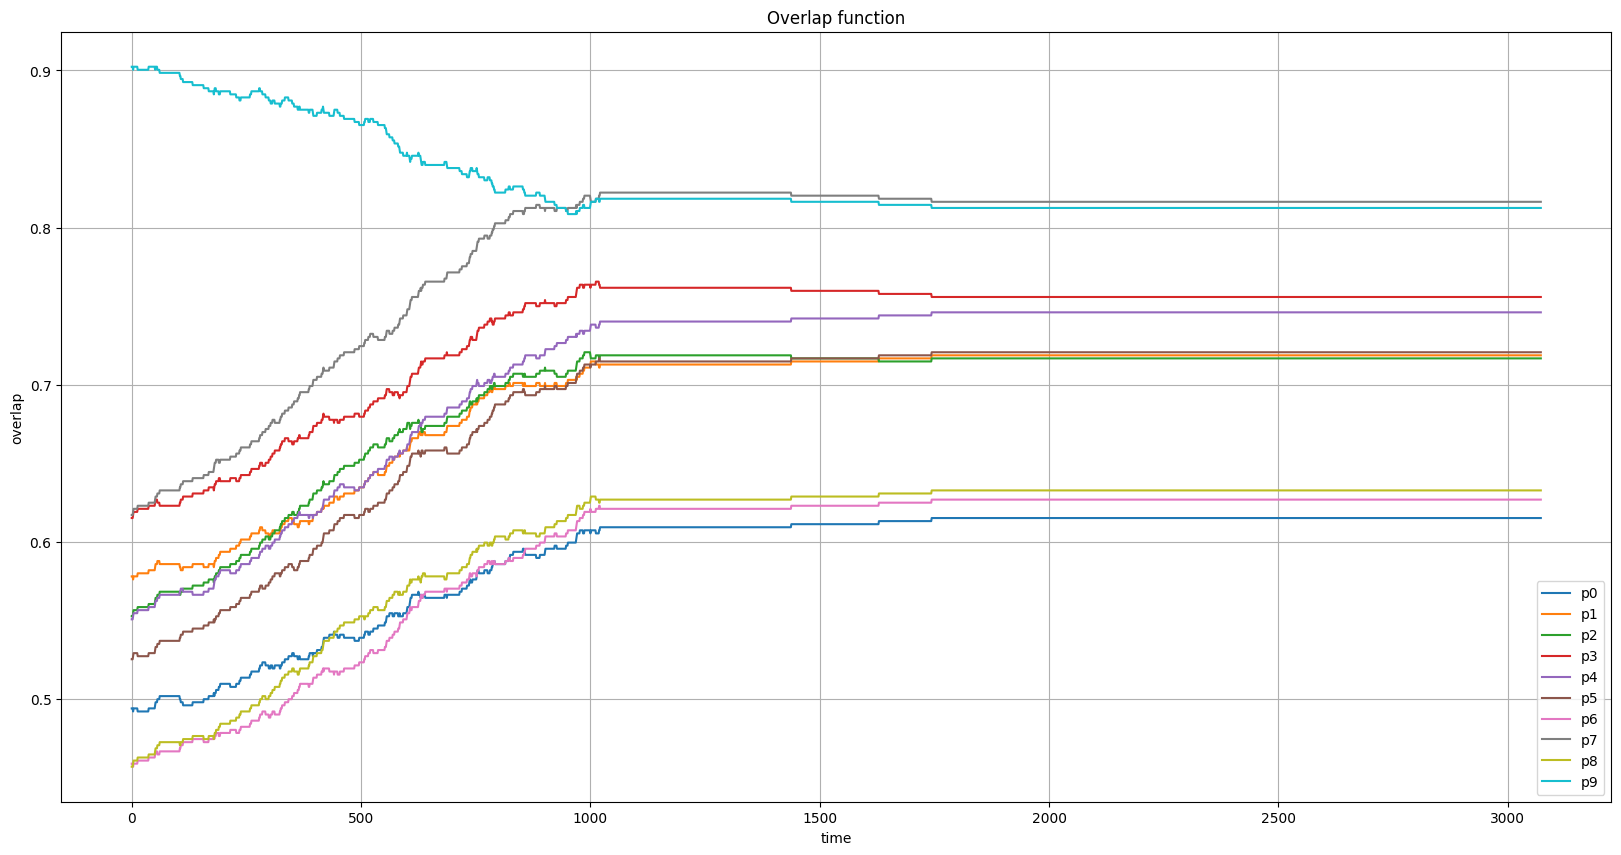

In [22]:
ad_model = HopfieldNetwork(ad_patterns[:3], bias)
perform_ad_retrieval(2, ad_props, ad_model)

for i in range(3, 10):
    new_pattern = ad_patterns[i].reshape(1, -1)
    # add new pattern
    ad_model.patterns = np.concatenate((ad_model.patterns, new_pattern), axis=0)
    # incremental update
    ad_model.W += new_pattern.T @ new_pattern
    np.fill_diagonal(ad_model.W, 0)
    # perform retrieval
    perform_ad_retrieval(i, ad_props, ad_model)

Plot averages of discrepancies.

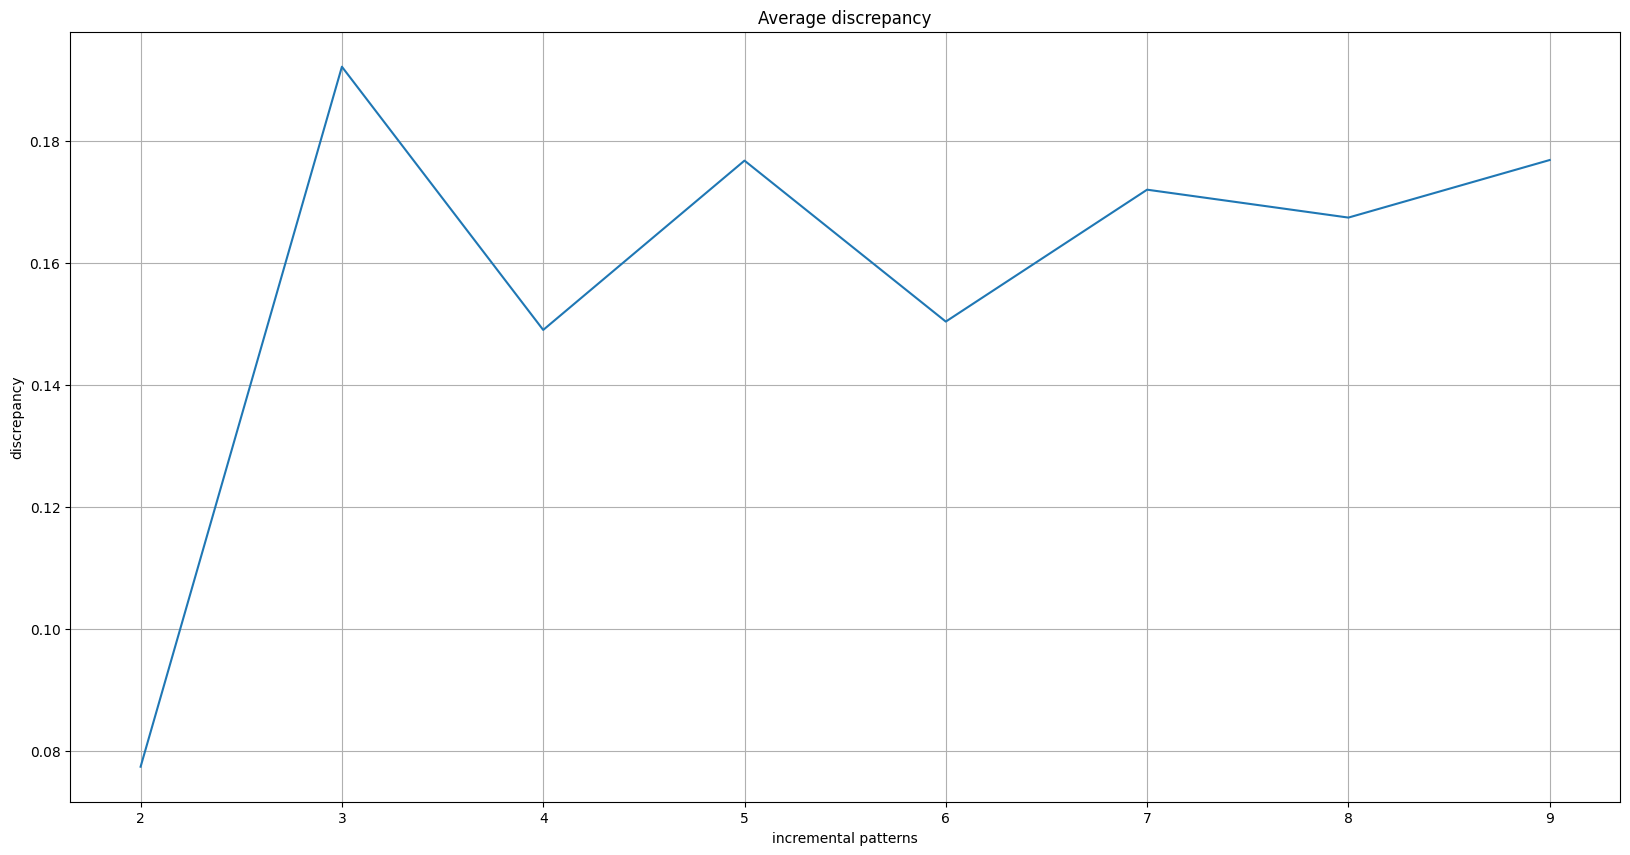

In [23]:
plt.figure(figsize=(20, 10))
plt.title('Average discrepancy')
plt.plot(list(range(2, 10)), avg_discrepancies)
plt.ylabel('discrepancy')
plt.xlabel('incremental patterns')
plt.grid(True)
plt.savefig('hopfield_plots/[BONUS TRACK 2] average_discrepancy.png')
plt.show()